#### Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Task 1 Cleaning the Data

In [3]:
df = pd.read_csv("MeleeWeapon.csv")

###### Remove NaN/Exalted Weapons

In [4]:
df.columns = df.columns.str.replace(' ', '_')
df = df[df.Type != "Exalted Weapon"] #Remove Exalted Weapons
df = df[df.Name != "Unarmed"] #Remove the unarmed weapon which only appears in one mission
df.dropna(subset = ["Released_Update"], inplace = True) #Removes weapons not released in Global build

###### Remove letters from ints

In [5]:
df['Released_Update'] = df['Released_Update'].map(lambda x: x.lstrip('UH'))
df['Slam_Radius'] = df['Slam_Radius'].map(lambda x: x.rstrip('m'))
df['Range'] = df['Range'].map(lambda x: x.rstrip('m'))
df['Critical_Damage'] = df['Critical_Damage'].map(lambda x: x.rstrip('x'))

In [6]:
df['Slam_Radius'] = df['Slam_Radius'].astype('int32')
df['Critical_Damage'] = df['Critical_Damage'].astype('float')
df['Released_Update'] = df['Released_Update'].replace('Vanilla', 0)
df['Range'] = df['Range'].astype('float')

###### Change Percentage to Float

In [7]:
df['Critical_Chance'] = df['Critical_Chance'].str.rstrip('%').astype('float') / 100.0

In [8]:
CleanedWeapon = df
CleanedWeapon.to_csv("CleanedWeapon.csv")

# Task 2 What is the distribution of the Damage Per Second(DPS) of the melee weapon

###### Functions

In [9]:
CleanedWeapon['RawDPS'] = (CleanedWeapon['Total_Damage'] * CleanedWeapon['Attack_Speed'])
CleanedWeapon['CritPreNerf'] = CleanedWeapon['Critical_Chance']*7.6
CleanedWeapon['CritPostNerf'] = CleanedWeapon['Critical_Chance']*5.4

def BeforeCritDamage(df):
    critMultMax = 1 + ((int(df.CritPreNerf)+1) * (df.Critical_Damage - 1))
    critMultMin = 1 + ((int(df.CritPreNerf)) * (df.Critical_Damage - 1))
    critaverage = (df.CritPreNerf - int(df.CritPreNerf))*10
    tempdam = 0
    for i in range(0,10):
        if(i < int(critaverage)):
            tempdam += (df.Total_Damage * critMultMax)
        else:
            tempdam += (df.Total_Damage * critMultMin)
    return tempdam/10

def PostCritDamage(df):
    critMultMax = 1 + ((int(df.CritPostNerf)+1) * (df.Critical_Damage - 1))
    critMultMin = 1 + ((int(df.CritPostNerf)) * (df.Critical_Damage - 1))
    critaverage = (df.CritPostNerf - int(df.CritPostNerf))*10
    tempdam = 0
    for i in range(0,10):
        if(i < int(critaverage)):
            tempdam += (df.Total_Damage * critMultMax)
        else:
            tempdam += (df.Total_Damage * critMultMin)
    return tempdam/10

CleanedWeapon['PreNerfDamage'] = CleanedWeapon.apply(BeforeCritDamage, axis=1)
CleanedWeapon['PostNerfDamage'] = CleanedWeapon.apply(PostCritDamage, axis=1)

def AverageCritDamage(df):
    critaverage = df.Critical_Chance*10
    tempdam = 0
    for i in range(0,10):
        if(i < int(critaverage)):
            tempdam += df.Total_Damage*df.Critical_Damage
        else:
            tempdam += df.Total_Damage
    return tempdam/10

CleanedWeapon['AverageCritDamage'] = CleanedWeapon.apply(AverageCritDamage, axis=1)

CleanedWeapon.to_csv("CleanedWeapon.csv", index=False)

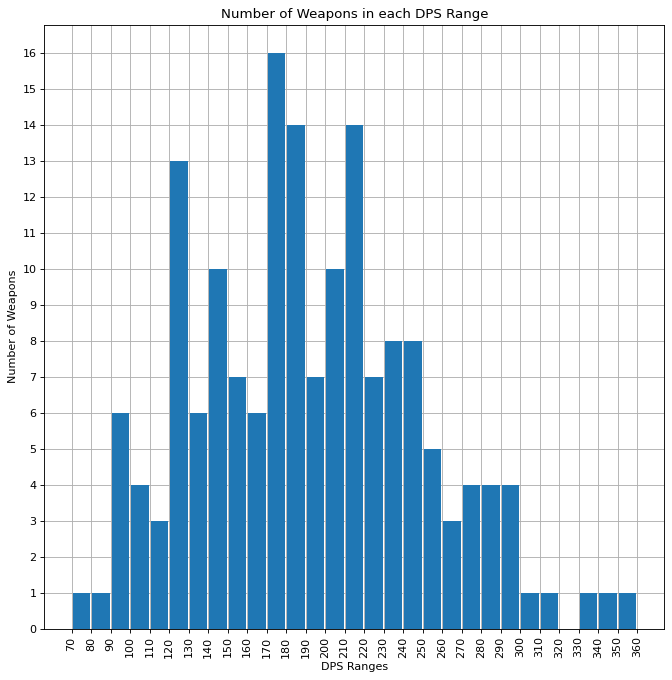

In [10]:
plt.figure(figsize=(10, 10), dpi=80)
n, bins, patches = plt.hist(CleanedWeapon['Total_Damage'],bins=29, zorder=2, rwidth=0.9)
plt.grid()
plt.xticks(bins, rotation='vertical')
plt.yticks(np.arange(0, 17, 1.0))
plt.title("Number of Weapons in each DPS Range")
plt.xlabel("DPS Ranges")
plt.ylabel("Number of Weapons")
plt.show()

In [11]:
CleanedWeapon['RawDPS'].mean()

183.5020921686747

In [12]:
CleanedWeapon['RawDPS'].median()

183.8

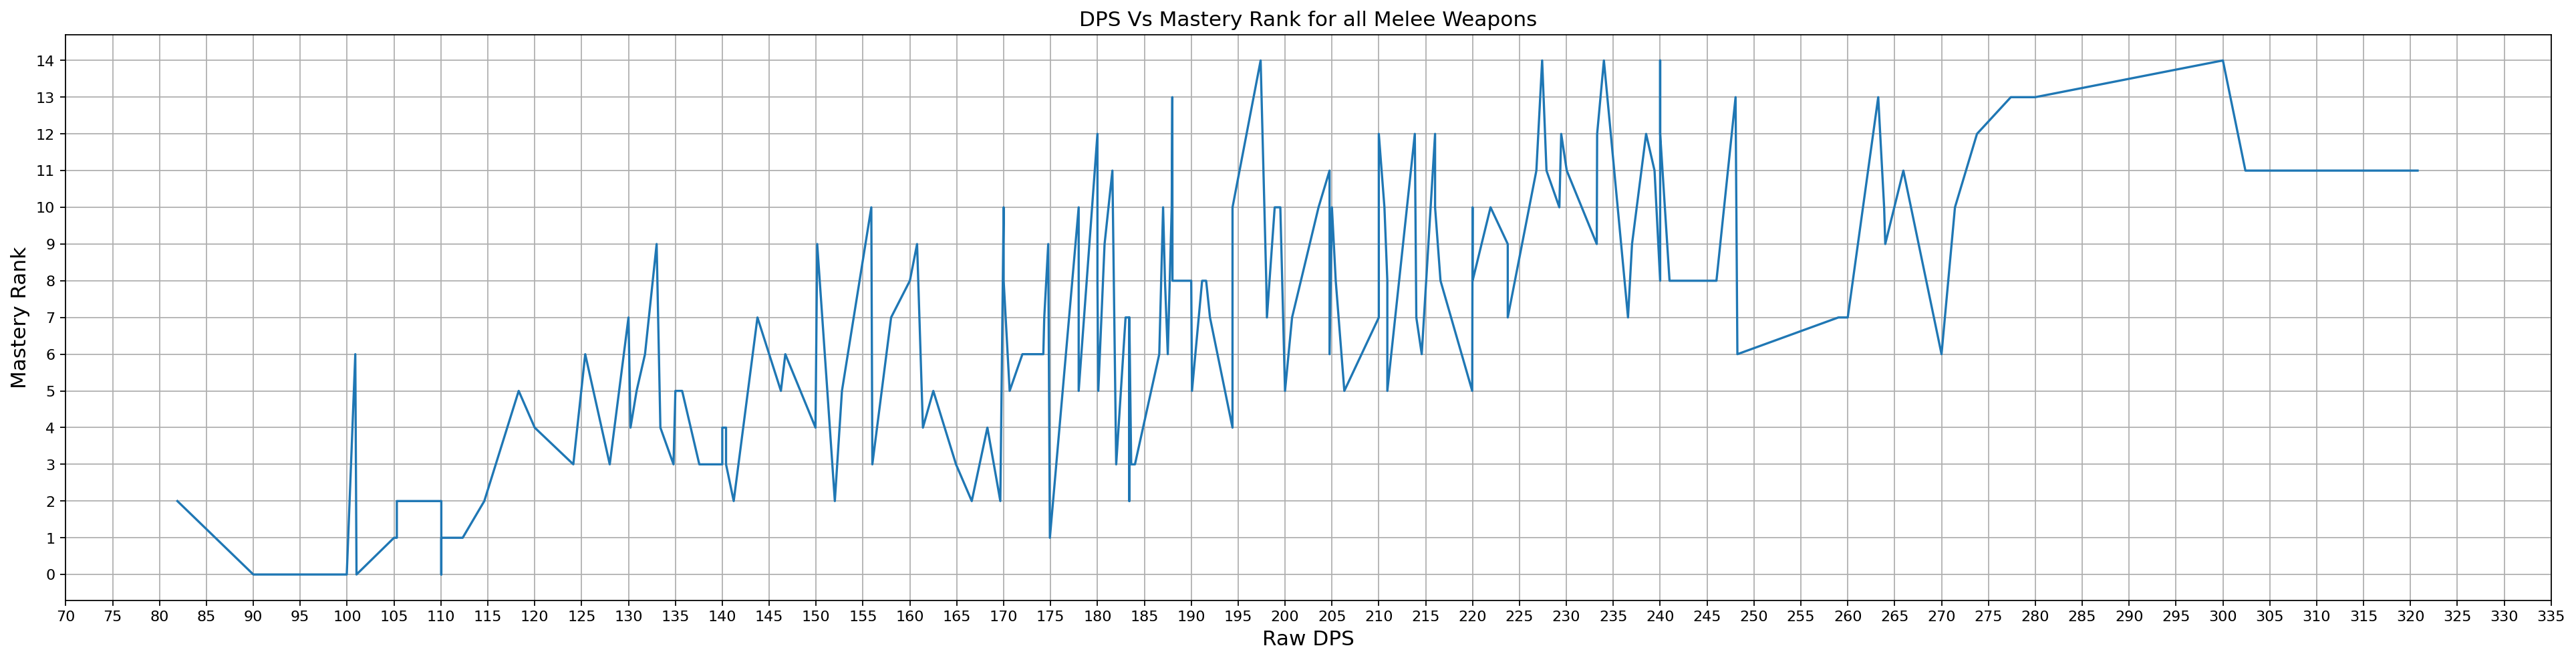

In [13]:
Sort_RawDF = CleanedWeapon.sort_values(by=['RawDPS'])
plt.figure(figsize=(30, 7), dpi=160)
plt.plot(Sort_RawDF['RawDPS'],Sort_RawDF['Mastery_Rank'])
plt.xticks(np.arange(70, 340, 5.0))
plt.yticks(np.arange(0, 15, 1.0))
plt.title("DPS Vs Mastery Rank for all Melee Weapons", fontsize = 14)
plt.xlabel("Raw DPS", fontsize = 14)
plt.ylabel("Mastery Rank", fontsize = 14)
plt.grid()
plt.show()

# Task 3 Crit Damage Viable Weapons

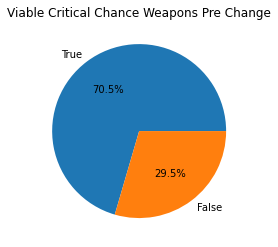

In [14]:
def ViableCritWeapon(crit):
    if(crit >= 1):
        return True
    else:
        return False

CleanedWeapon['ViableCritPreNerf'] = CleanedWeapon['CritPreNerf'].apply(lambda x:ViableCritWeapon(x))
CleanedWeapon['ViableCritPostNerf'] = CleanedWeapon['CritPostNerf'].apply(lambda x:ViableCritWeapon(x))

CleanedWeapon['ViableCritPreNerf'].value_counts().plot(kind='pie',autopct='%1.1f%%',title="Viable Critical Chance Weapons Pre Change")
plt.ylabel("")
plt.show()

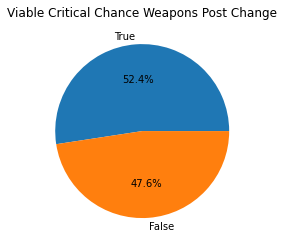

In [15]:
CleanedWeapon['ViableCritPostNerf'].value_counts().plot(kind='pie',autopct='%1.1f%%',title="Viable Critical Chance Weapons Post Change")
plt.ylabel("")
plt.show()

# Task 4 Condition Overload

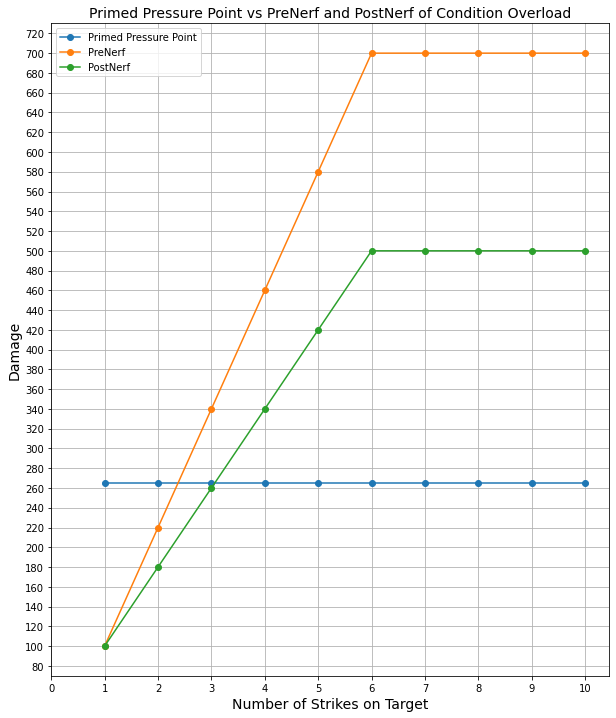

In [16]:
# How bad is the change for Condition Overload 120% to 80%
ConOver = pd.read_csv('conditionoverload.csv')

plt.figure(figsize=(10, 12))
plt.plot(ConOver.index+1, ConOver['Base'], label="Primed Pressure Point", marker='o')
plt.plot(ConOver.index+1, ConOver['PreNerf'], label="PreNerf", marker='o')
plt.plot(ConOver.index+1, ConOver['PostNerf'], label="PostNerf", marker='o')
plt.xticks(np.arange(0, 11, 1))
plt.yticks(np.arange(80, 740, 20.0))
plt.title("Primed Pressure Point vs PreNerf and PostNerf of Condition Overload", fontsize = 14)
plt.xlabel("Number of Strikes on Target", fontsize = 14)
plt.ylabel("Damage", fontsize = 14)
plt.legend()
plt.grid()
plt.show()

# Task 5 DPS versus Mastery Rank for each weapon type

In [17]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], str(point['val']), horizontalalignment='right', verticalalignment='bottom', fontsize=12)

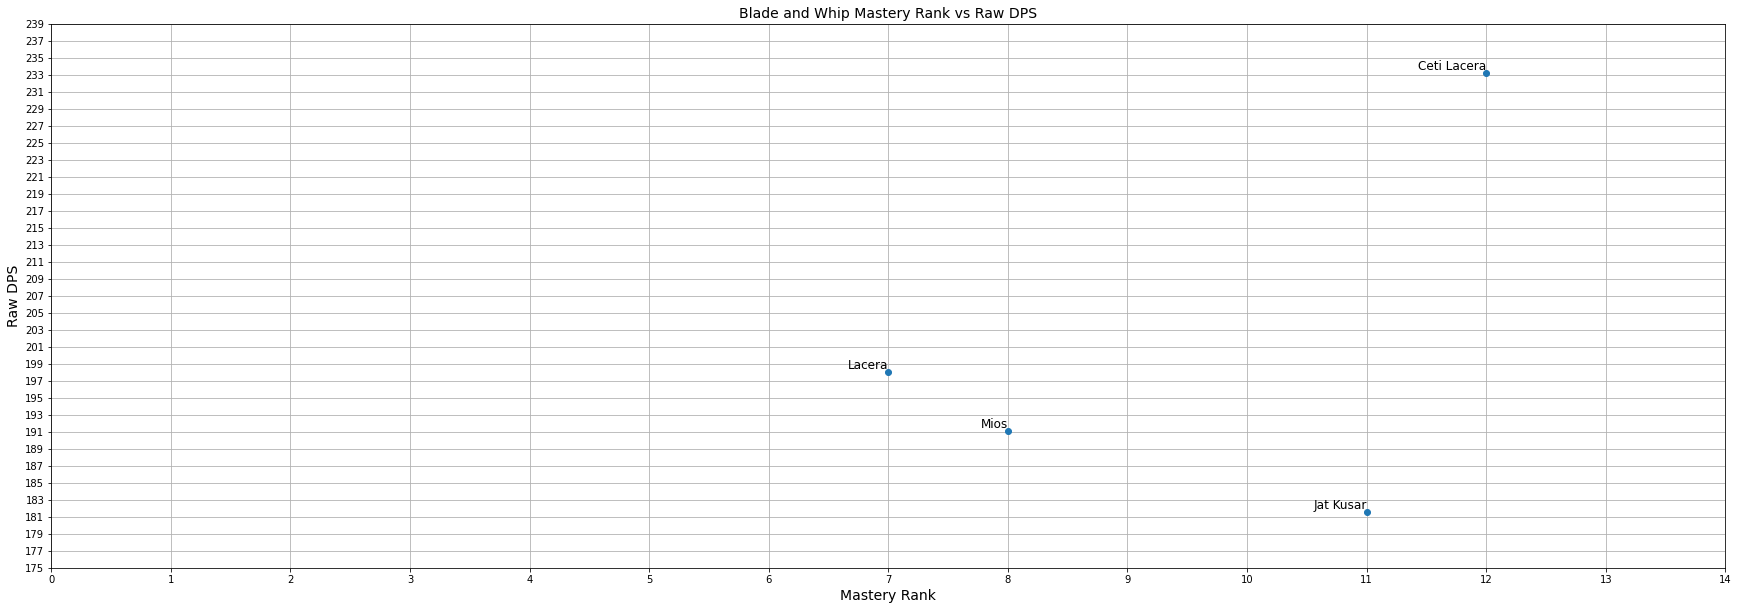

In [18]:
BLWPDF = CleanedWeapon.loc[CleanedWeapon['Type'] == "Blade and Whip"]
BLWPDF = BLWPDF.sort_values(by=['Mastery_Rank'])

plt.figure(figsize=(30, 10))
ax = BLWPDF.set_index('Mastery_Rank')['RawDPS'].plot(style='o')

label_point(BLWPDF.Mastery_Rank, BLWPDF.RawDPS, BLWPDF.Name, ax)
plt.xticks(np.arange(0, 15, 1))
plt.yticks(np.arange(175, 240, 2.0))
plt.title("Blade and Whip Mastery Rank vs Raw DPS", fontsize = 14)
plt.xlabel("Mastery Rank", fontsize = 14)
plt.ylabel("Raw DPS", fontsize = 14)
plt.grid()
plt.show()

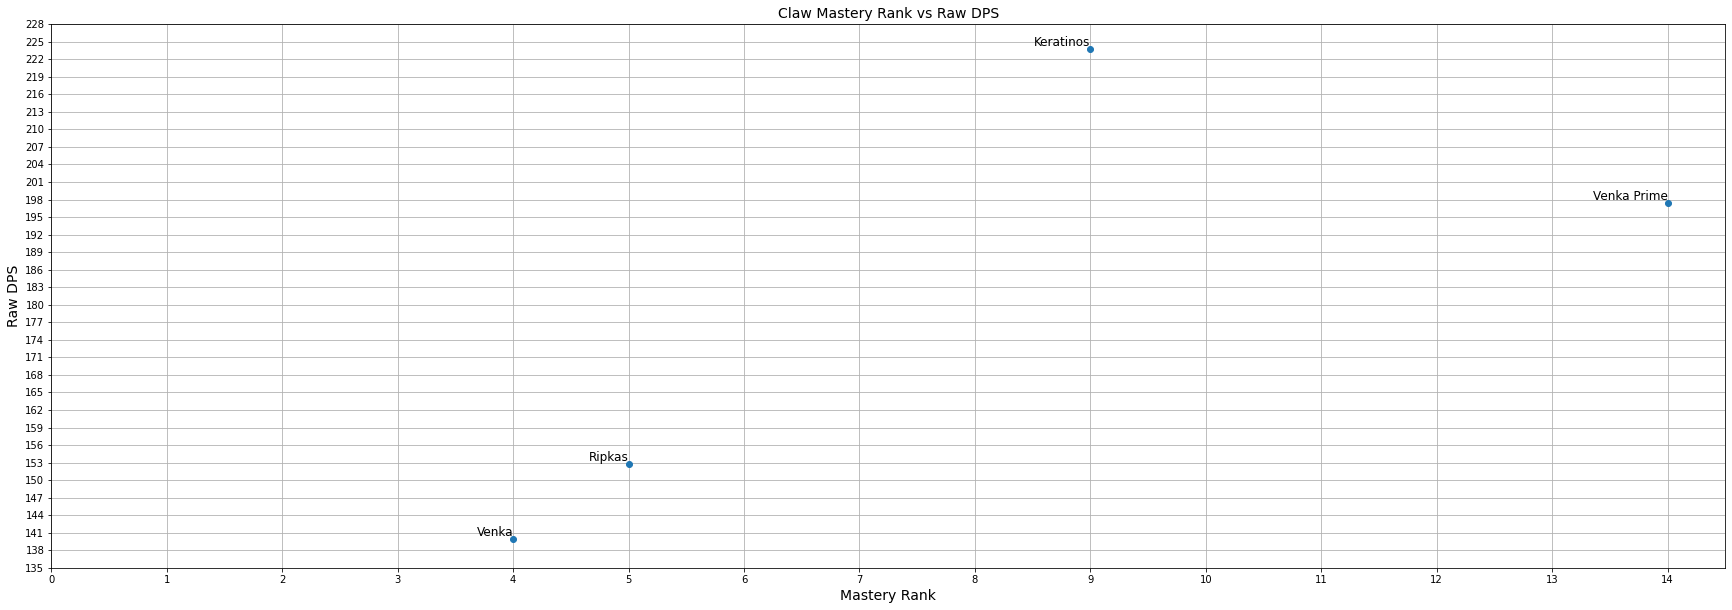

In [19]:
ClawDF = CleanedWeapon.loc[CleanedWeapon['Type'] == "Claws"]
ClawDF = ClawDF.sort_values(by=['Mastery_Rank'])

plt.figure(figsize=(30, 10))
ax = ClawDF.set_index('Mastery_Rank')['RawDPS'].plot(style='o')

label_point(ClawDF.Mastery_Rank, ClawDF.RawDPS, ClawDF.Name, ax)
plt.xticks(np.arange(0, 15, 1))
plt.yticks(np.arange(135, 230, 3.0))
plt.title("Claw Mastery Rank vs Raw DPS", fontsize = 14)
plt.xlabel("Mastery Rank", fontsize = 14)
plt.ylabel("Raw DPS", fontsize = 14)
plt.grid()
plt.show()

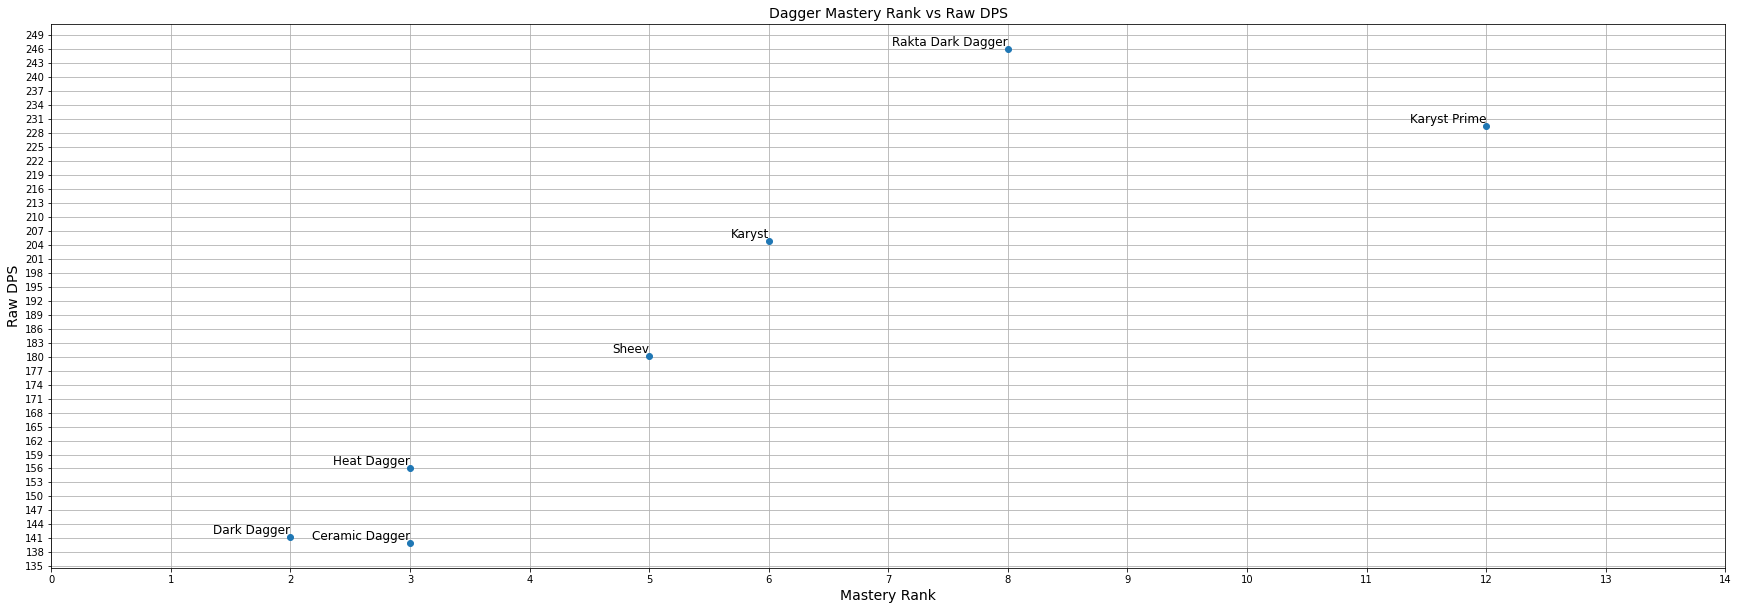

In [20]:
DaggerDF = CleanedWeapon.loc[CleanedWeapon['Type'] == "Dagger"]
DaggerDF = DaggerDF.sort_values(by=['Mastery_Rank'])

plt.figure(figsize=(30, 10))
ax = DaggerDF.set_index('Mastery_Rank')['RawDPS'].plot(style='o')

label_point(DaggerDF.Mastery_Rank, DaggerDF.RawDPS, DaggerDF.Name, ax)
plt.xticks(np.arange(0, 15, 1))
plt.yticks(np.arange(135, 250, 3.0))
plt.title("Dagger Mastery Rank vs Raw DPS", fontsize = 14)
plt.xlabel("Mastery Rank", fontsize = 14)
plt.ylabel("Raw DPS", fontsize = 14)
plt.grid()
plt.show()

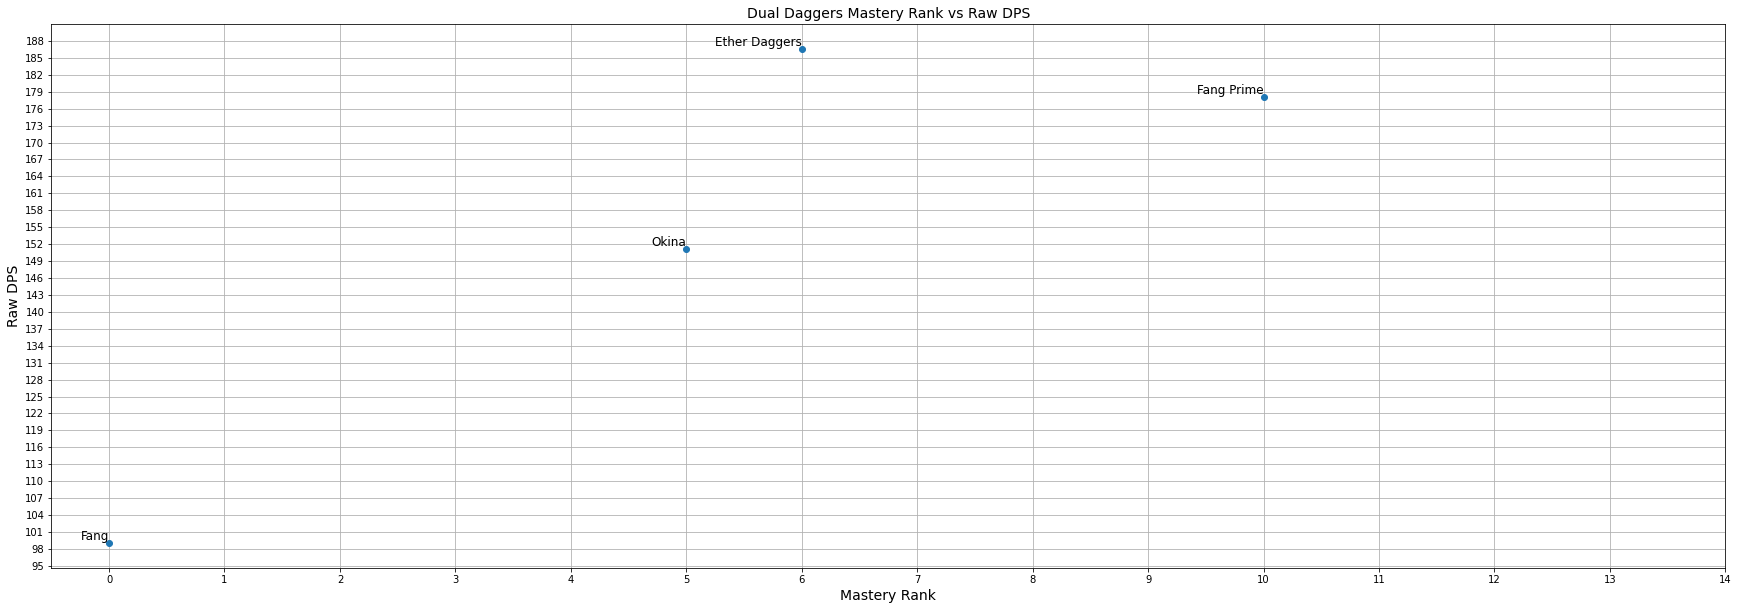

In [21]:
DDaggerDF = CleanedWeapon.loc[CleanedWeapon['Type'] == "Dual Daggers"]
DDaggerDF = DDaggerDF.sort_values(by=['Mastery_Rank'])

plt.figure(figsize=(30, 10))
ax = DDaggerDF.set_index('Mastery_Rank')['RawDPS'].plot(style='o')

label_point(DDaggerDF.Mastery_Rank, DDaggerDF.RawDPS, DDaggerDF.Name, ax)
plt.xticks(np.arange(0, 15, 1))
plt.yticks(np.arange(95, 190, 3.0))
plt.title("Dual Daggers Mastery Rank vs Raw DPS", fontsize = 14)
plt.xlabel("Mastery Rank", fontsize = 14)
plt.ylabel("Raw DPS", fontsize = 14)
plt.grid()
plt.show()

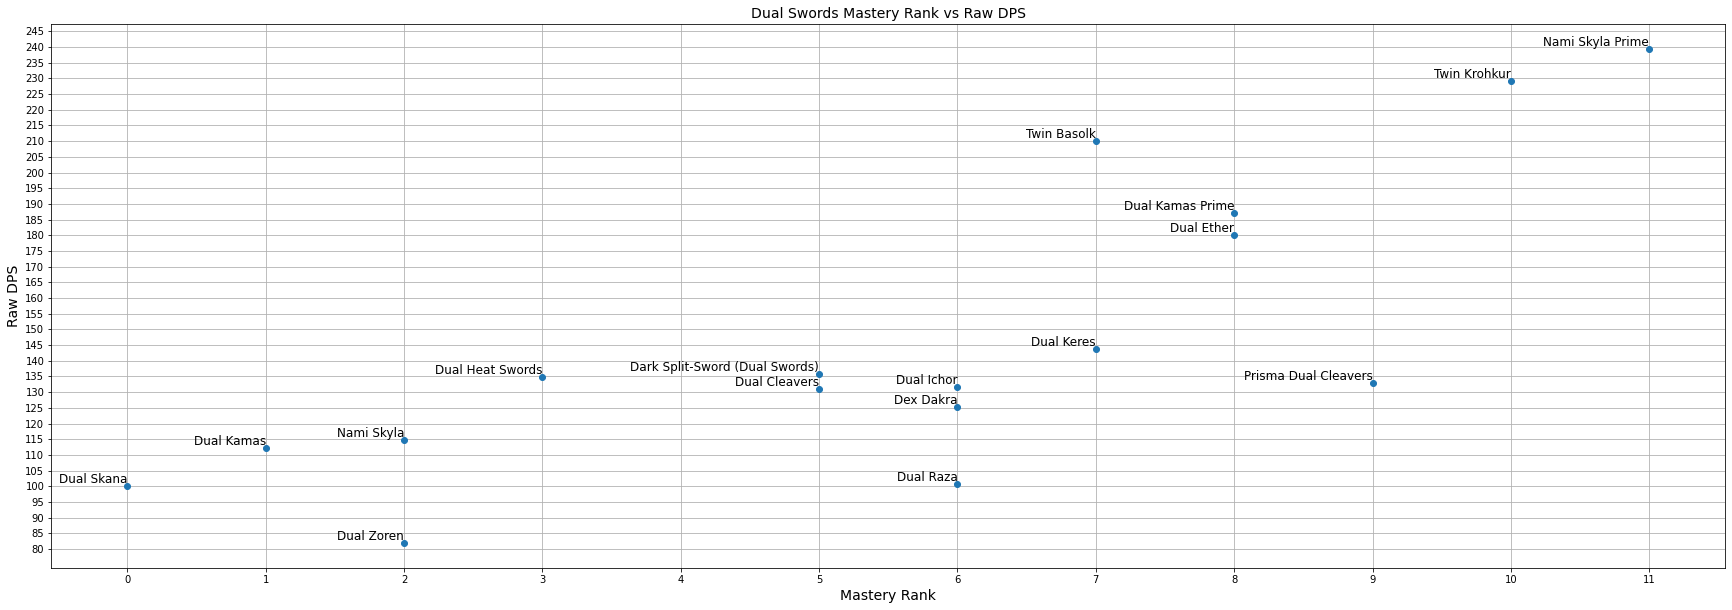

In [22]:
DualDF = CleanedWeapon.loc[CleanedWeapon['Type'] == "Dual Swords"]
DualDF = DualDF.sort_values(by=['Mastery_Rank'])

plt.figure(figsize=(30, 10))
ax = DualDF.set_index('Mastery_Rank')['RawDPS'].plot(style='o')

label_point(DualDF.Mastery_Rank, DualDF.RawDPS, DualDF.Name, ax)
plt.xticks(np.arange(0, 12, 1))
plt.yticks(np.arange(80, 250, 5.0))
plt.title("Dual Swords Mastery Rank vs Raw DPS", fontsize = 14)
plt.xlabel("Mastery Rank", fontsize = 14)
plt.ylabel("Raw DPS", fontsize = 14)
plt.grid()
plt.show()

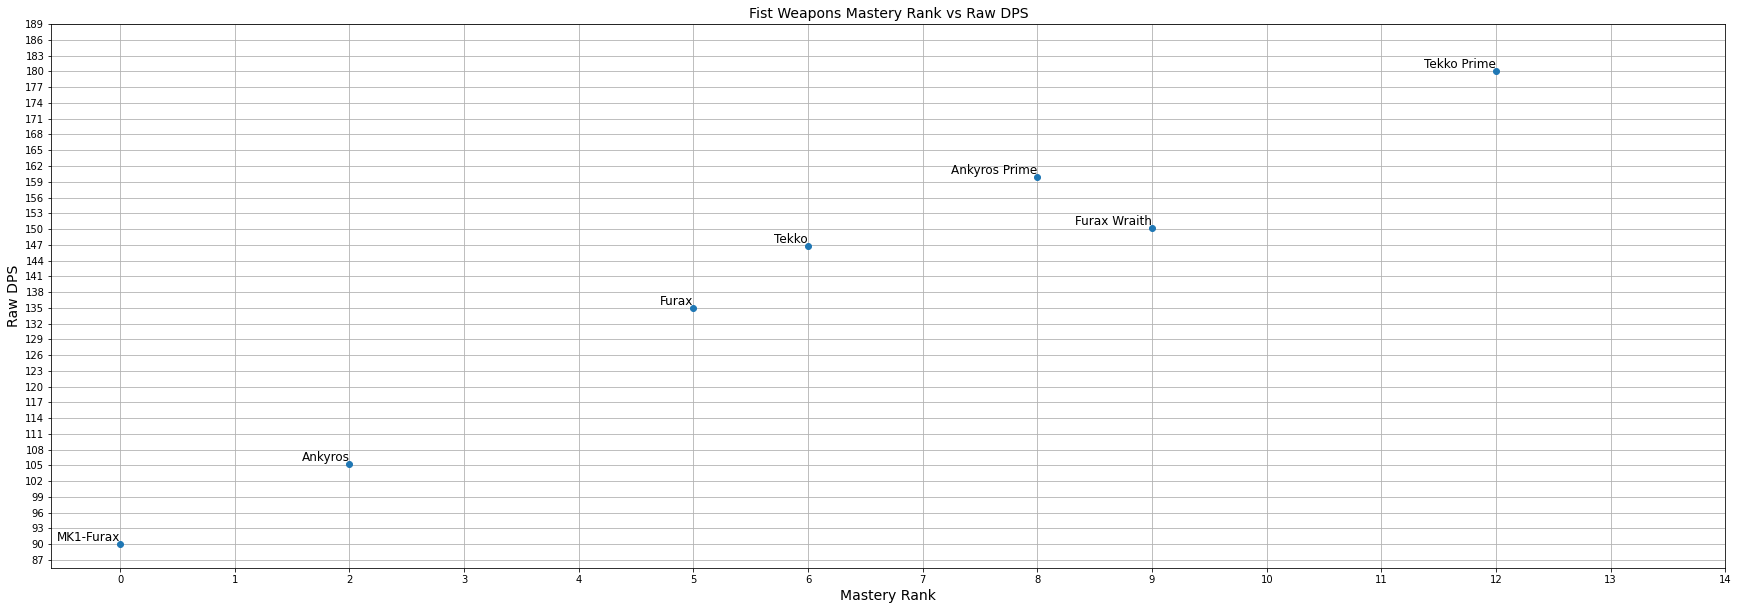

In [23]:
FistDF = CleanedWeapon.loc[CleanedWeapon['Type'] == "Fist"]
FistDF = FistDF.sort_values(by=['Mastery_Rank'])

plt.figure(figsize=(30, 10))
ax = FistDF.set_index('Mastery_Rank')['RawDPS'].plot(style='o')

label_point(FistDF.Mastery_Rank, FistDF.RawDPS, FistDF.Name, ax)
plt.xticks(np.arange(0, 15, 1))
plt.yticks(np.arange(87, 190, 3.0))
plt.title("Fist Weapons Mastery Rank vs Raw DPS", fontsize = 14)
plt.xlabel("Mastery Rank", fontsize = 14)
plt.ylabel("Raw DPS", fontsize = 14)
plt.grid()
plt.show()

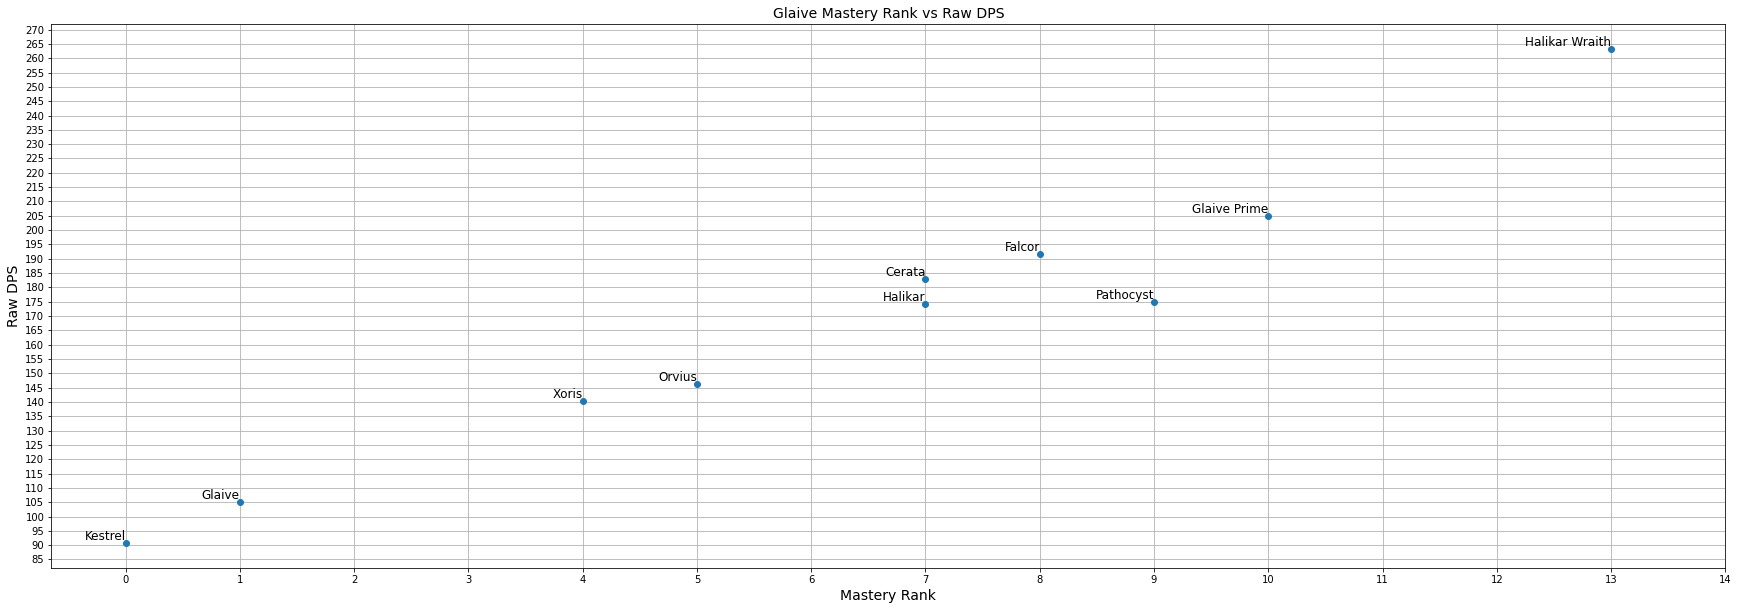

In [24]:
GlaiveDF = CleanedWeapon.loc[CleanedWeapon['Type'] == "Glaive"]
GlaiveDF = GlaiveDF.sort_values(by=['Mastery_Rank'])

plt.figure(figsize=(30, 10))
ax = GlaiveDF.set_index('Mastery_Rank')['RawDPS'].plot(style='o')

label_point(GlaiveDF.Mastery_Rank, GlaiveDF.RawDPS, GlaiveDF.Name, ax)
plt.xticks(np.arange(0, 15, 1))
plt.yticks(np.arange(85, 275, 5.0))
plt.title("Glaive Mastery Rank vs Raw DPS", fontsize = 14)
plt.xlabel("Mastery Rank", fontsize = 14)
plt.ylabel("Raw DPS", fontsize = 14)
plt.grid()
plt.show()

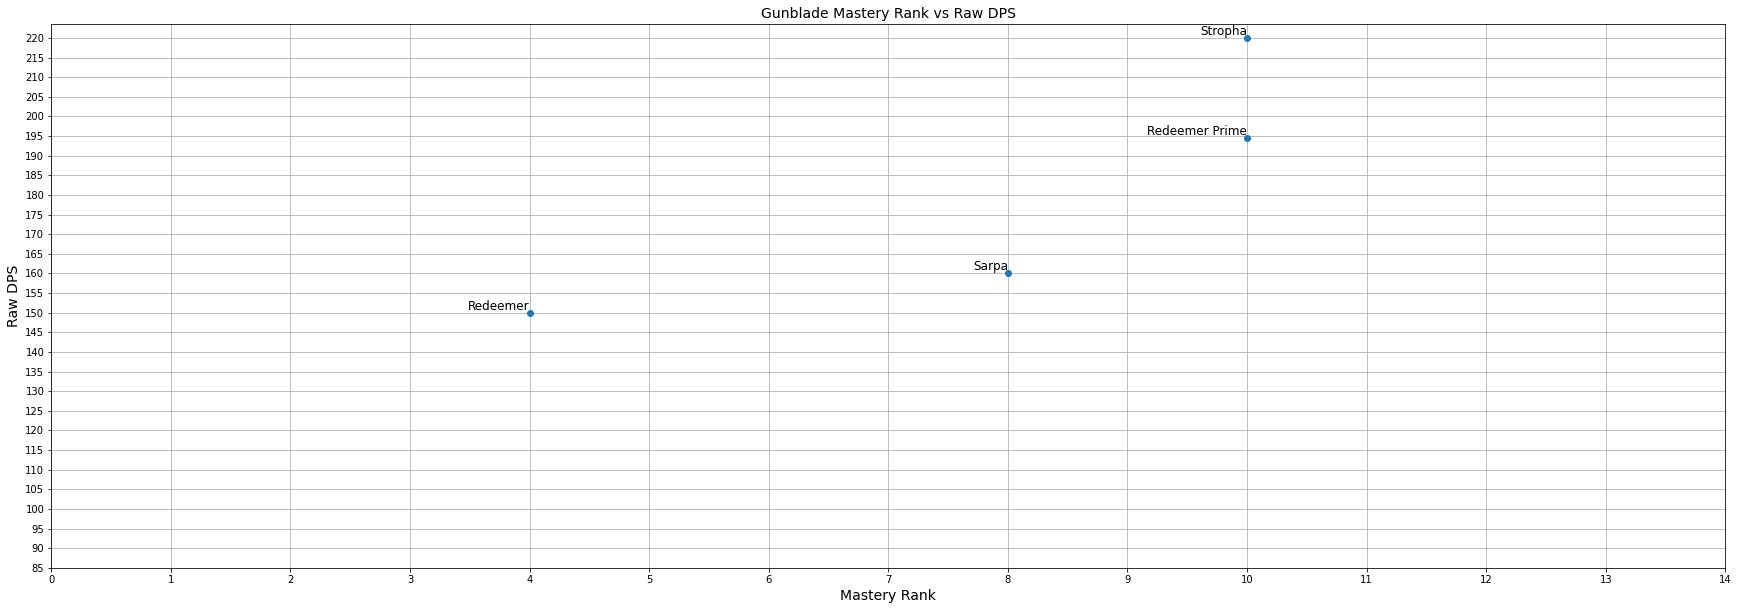

In [25]:
GunBladeDF = CleanedWeapon.loc[CleanedWeapon['Type'] == "Gunblade"]
GunBladeDF = GunBladeDF.sort_values(by=['Mastery_Rank'])

plt.figure(figsize=(30, 10))
ax = GunBladeDF.set_index('Mastery_Rank')['RawDPS'].plot(style='o')

label_point(GunBladeDF.Mastery_Rank, GunBladeDF.RawDPS, GunBladeDF.Name, ax)
plt.xticks(np.arange(0, 15, 1))
plt.yticks(np.arange(85, 225, 5.0))
plt.title("Gunblade Mastery Rank vs Raw DPS", fontsize = 14)
plt.xlabel("Mastery Rank", fontsize = 14)
plt.ylabel("Raw DPS", fontsize = 14)
plt.grid()
plt.show()

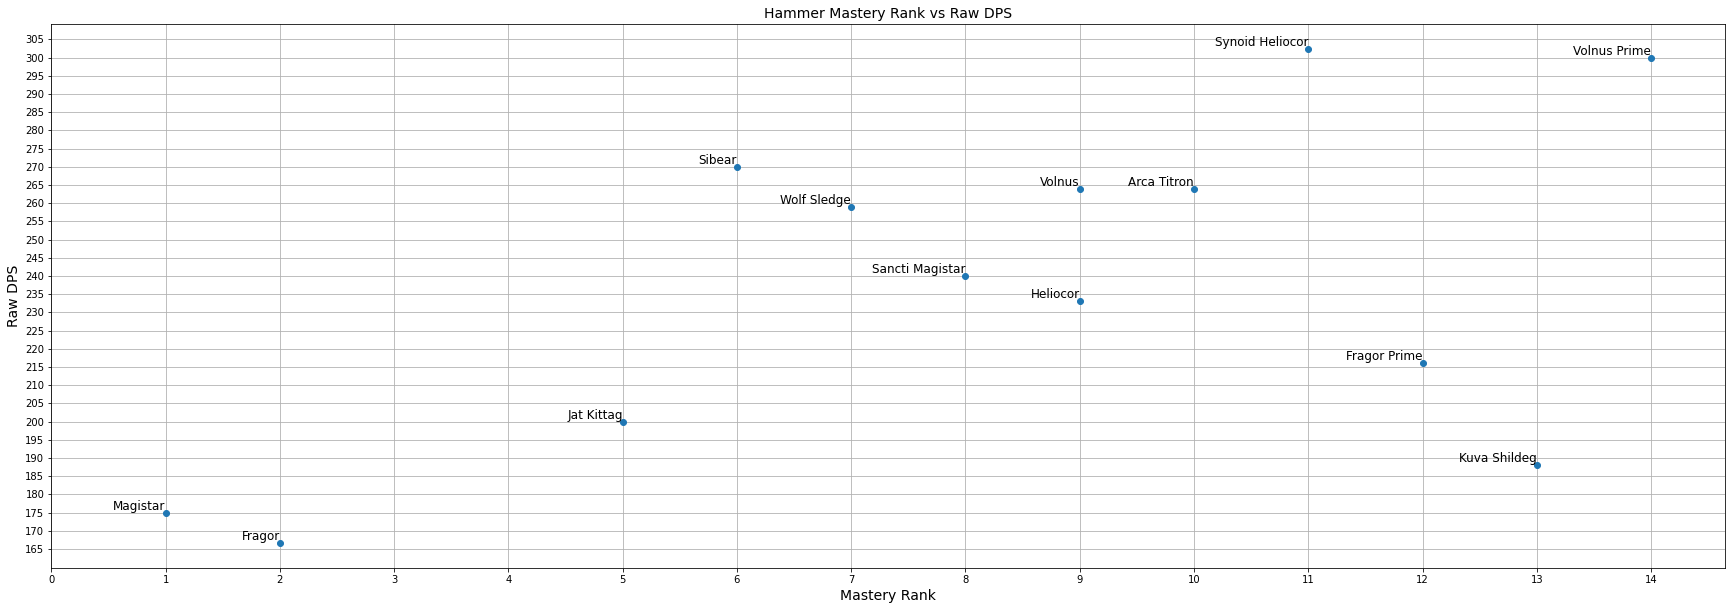

In [26]:
HammerDF = CleanedWeapon.loc[CleanedWeapon['Type'] == "Hammer"]
HammerDF = HammerDF.sort_values(by=['Mastery_Rank'])

plt.figure(figsize=(30, 10))
ax = HammerDF.set_index('Mastery_Rank')['RawDPS'].plot(style='o')

label_point(HammerDF.Mastery_Rank, HammerDF.RawDPS, HammerDF.Name, ax)
plt.xticks(np.arange(0, 15, 1))
plt.yticks(np.arange(165, 310, 5.0))
plt.title("Hammer Mastery Rank vs Raw DPS", fontsize = 14)
plt.xlabel("Mastery Rank", fontsize = 14)
plt.ylabel("Raw DPS", fontsize = 14)
plt.grid()
plt.show()

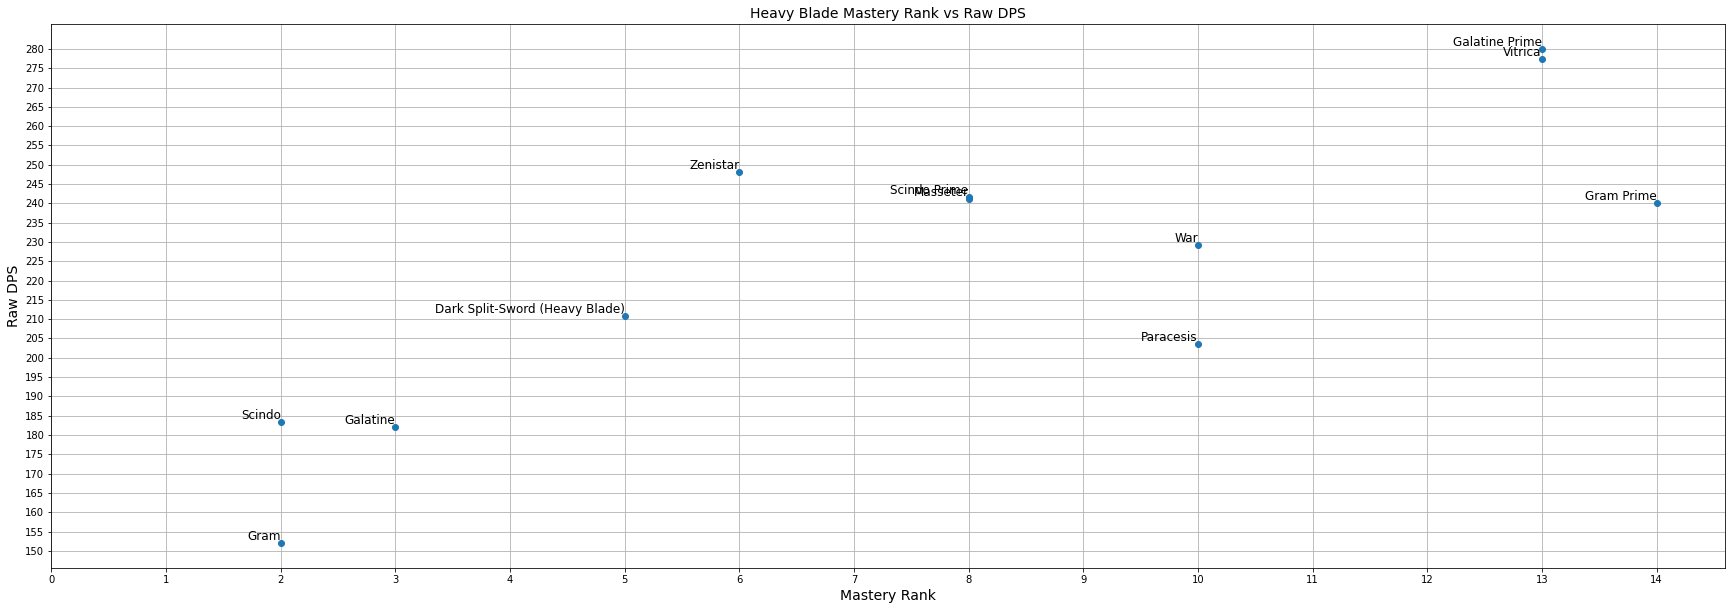

In [27]:
HeavyBLDF = CleanedWeapon.loc[CleanedWeapon['Type'] == "Heavy Blade"]
HeavyBLDF = HeavyBLDF.sort_values(by=['Mastery_Rank'])

plt.figure(figsize=(30, 10))
ax = HeavyBLDF.set_index('Mastery_Rank')['RawDPS'].plot(style='o')

label_point(HeavyBLDF.Mastery_Rank, HeavyBLDF.RawDPS, HeavyBLDF.Name, ax)
plt.xticks(np.arange(0, 15, 1))
plt.yticks(np.arange(150, 285, 5.0))
plt.title("Heavy Blade Mastery Rank vs Raw DPS", fontsize = 14)
plt.xlabel("Mastery Rank", fontsize = 14)
plt.ylabel("Raw DPS", fontsize = 14)
plt.grid()
plt.show()

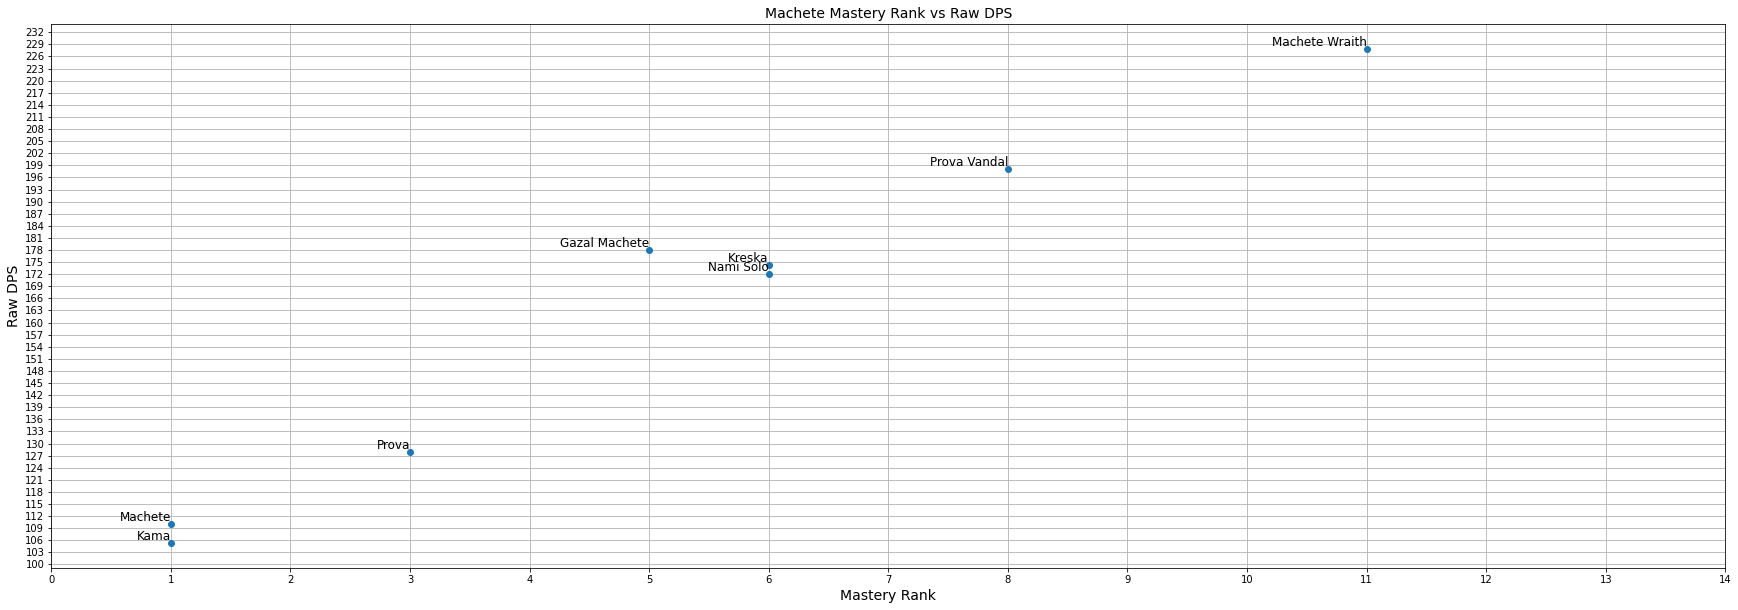

In [28]:
MacheteDF = CleanedWeapon.loc[CleanedWeapon['Type'] == "Machete"]
MacheteDF = MacheteDF.sort_values(by=['Mastery_Rank'])

plt.figure(figsize=(30, 10))
ax = MacheteDF.set_index('Mastery_Rank')['RawDPS'].plot(style='o')

label_point(MacheteDF.Mastery_Rank, MacheteDF.RawDPS, MacheteDF.Name, ax)
plt.xticks(np.arange(0, 15, 1))
plt.yticks(np.arange(100, 235, 3.0))
plt.title("Machete Mastery Rank vs Raw DPS", fontsize = 14)
plt.xlabel("Mastery Rank", fontsize = 14)
plt.ylabel("Raw DPS", fontsize = 14)
plt.grid()
plt.show()

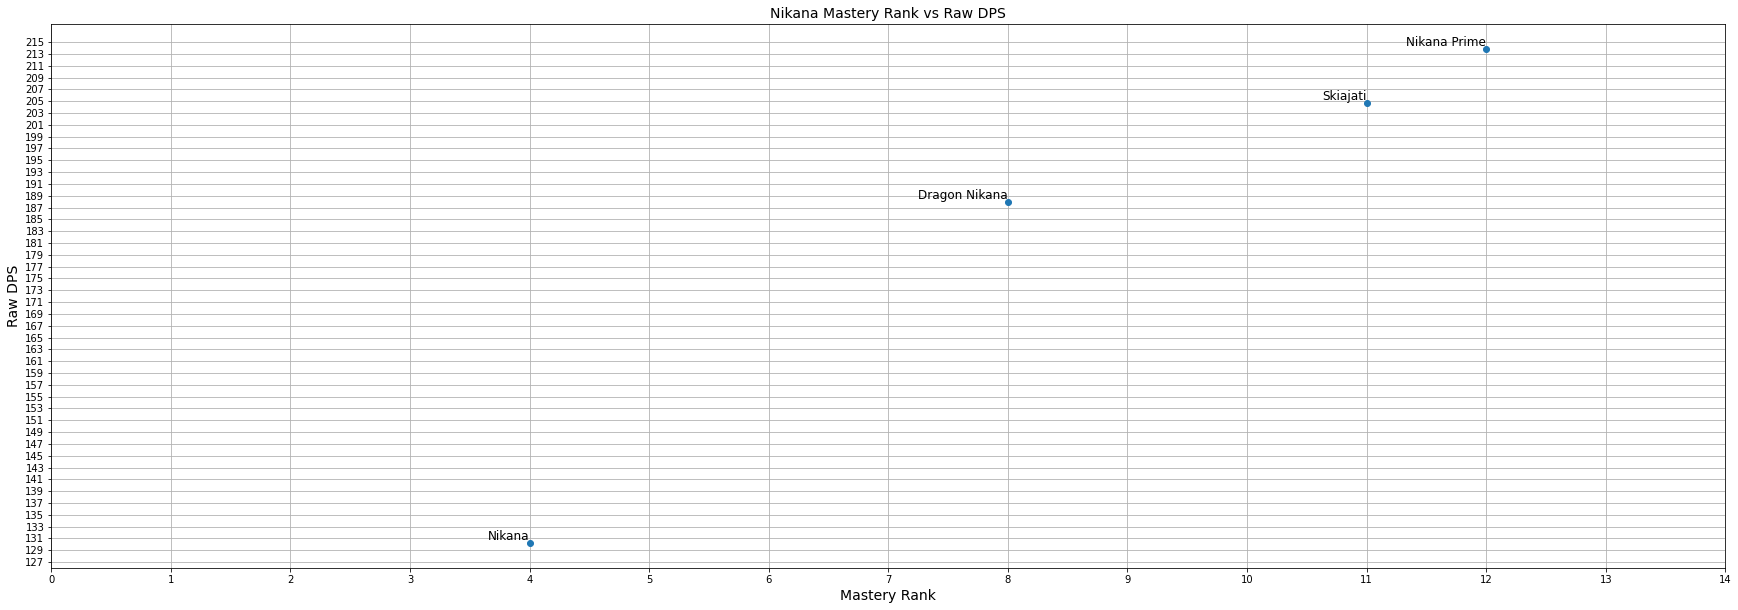

In [29]:
NikanaDF = CleanedWeapon.loc[CleanedWeapon['Type'] == "Nikana"]
NikanaDF = NikanaDF.sort_values(by=['Mastery_Rank'])

plt.figure(figsize=(30, 10))
ax = NikanaDF.set_index('Mastery_Rank')['RawDPS'].plot(style='o')

label_point(NikanaDF.Mastery_Rank, NikanaDF.RawDPS, NikanaDF.Name, ax)
plt.xticks(np.arange(0, 15, 1))
plt.yticks(np.arange(127, 217, 2.0))
plt.title("Nikana Mastery Rank vs Raw DPS", fontsize = 14)
plt.xlabel("Mastery Rank", fontsize = 14)
plt.ylabel("Raw DPS", fontsize = 14)
plt.grid()
plt.show()

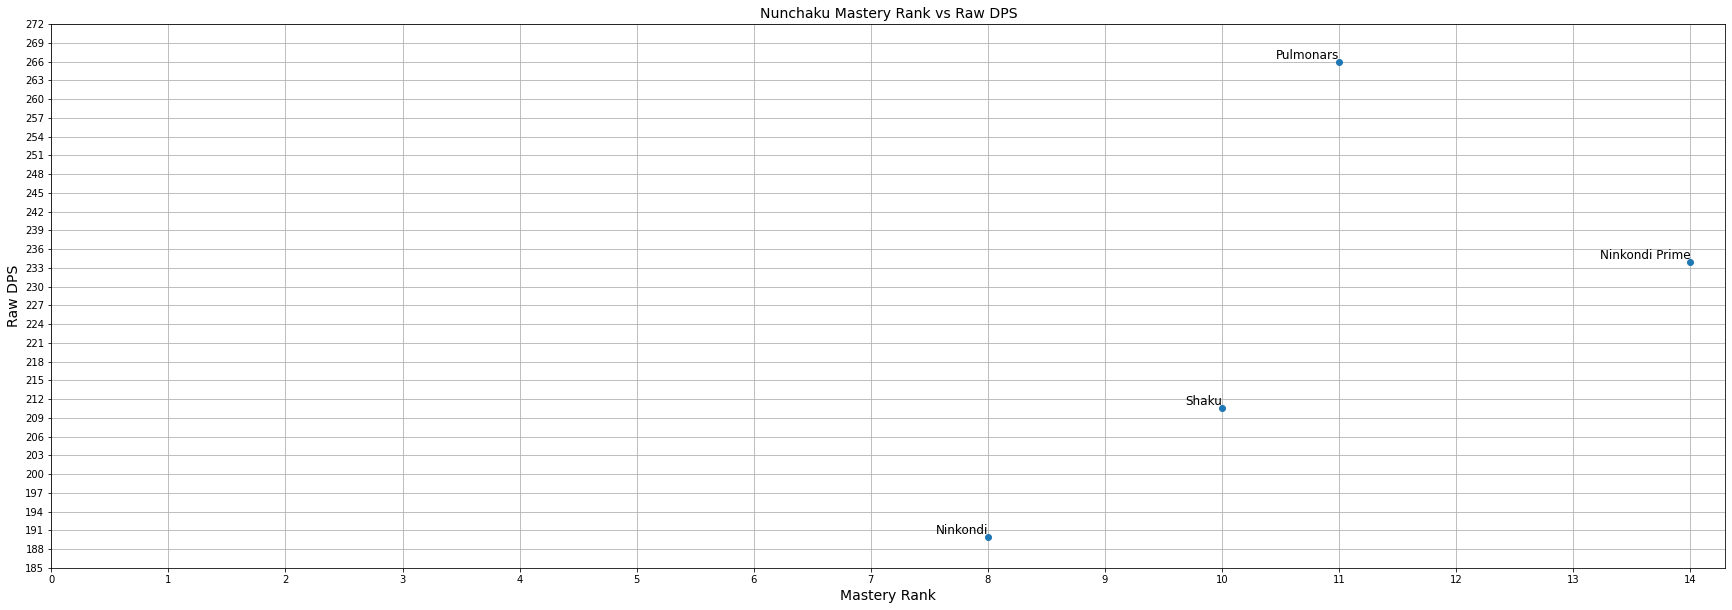

In [30]:
NunchakuDF = CleanedWeapon.loc[CleanedWeapon['Type'] == "Nunchaku"]
NunchakuDF = NunchakuDF.sort_values(by=['Mastery_Rank'])

plt.figure(figsize=(30, 10))
ax = NunchakuDF.set_index('Mastery_Rank')['RawDPS'].plot(style='o')

label_point(NunchakuDF.Mastery_Rank, NunchakuDF.RawDPS, NunchakuDF.Name, ax)
plt.xticks(np.arange(0, 15, 1))
plt.yticks(np.arange(185, 275, 3.0))
plt.title("Nunchaku Mastery Rank vs Raw DPS", fontsize = 14)
plt.xlabel("Mastery Rank", fontsize = 14)
plt.ylabel("Raw DPS", fontsize = 14)
plt.grid()
plt.show()

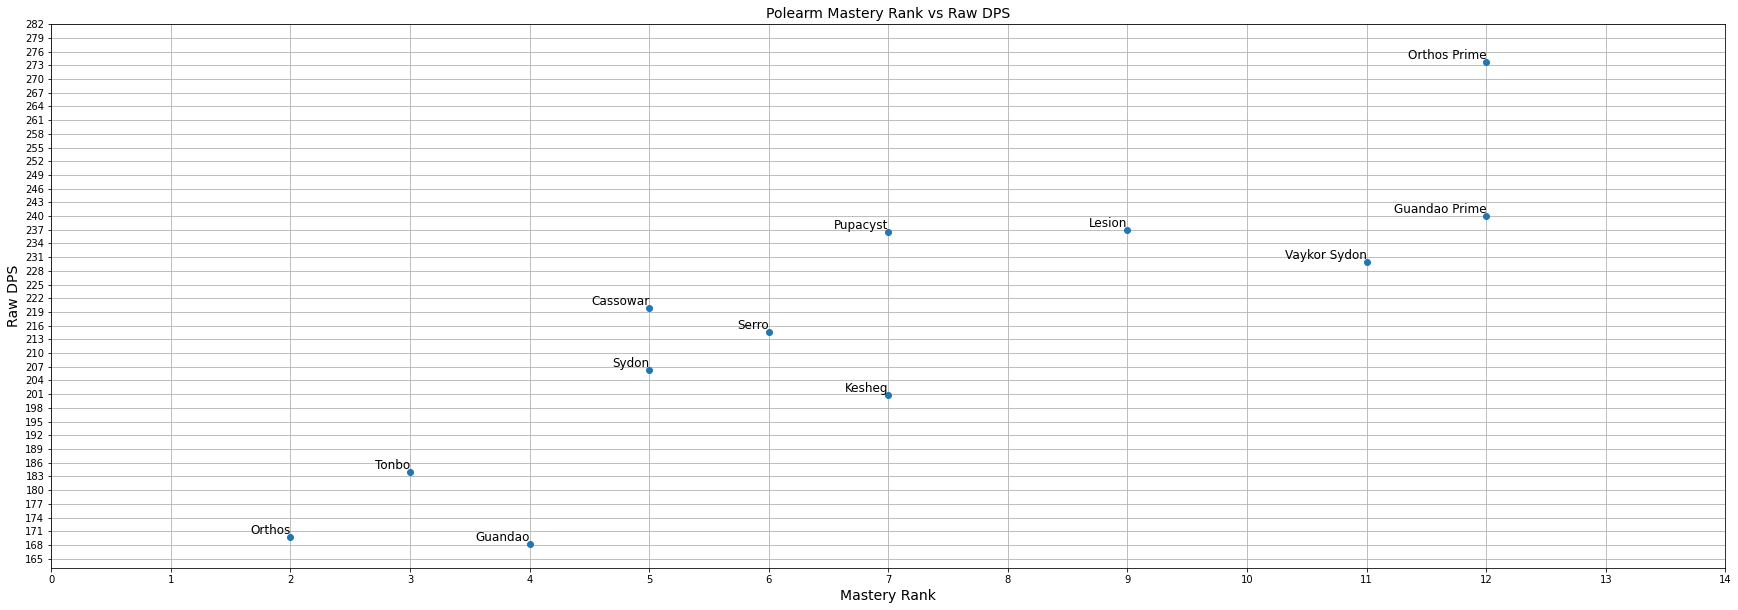

In [31]:
PolearmDF = CleanedWeapon.loc[CleanedWeapon['Type'] == "Polearm"]
PolearmDF = PolearmDF.sort_values(by=['Mastery_Rank'])

plt.figure(figsize=(30, 10))
ax = PolearmDF.set_index('Mastery_Rank')['RawDPS'].plot(style='o')

label_point(PolearmDF.Mastery_Rank, PolearmDF.RawDPS, PolearmDF.Name, ax)
plt.xticks(np.arange(0, 15, 1))
plt.yticks(np.arange(165, 285, 3.0))
plt.title("Polearm Mastery Rank vs Raw DPS", fontsize = 14)
plt.xlabel("Mastery Rank", fontsize = 14)
plt.ylabel("Raw DPS", fontsize = 14)
plt.grid()
plt.show()

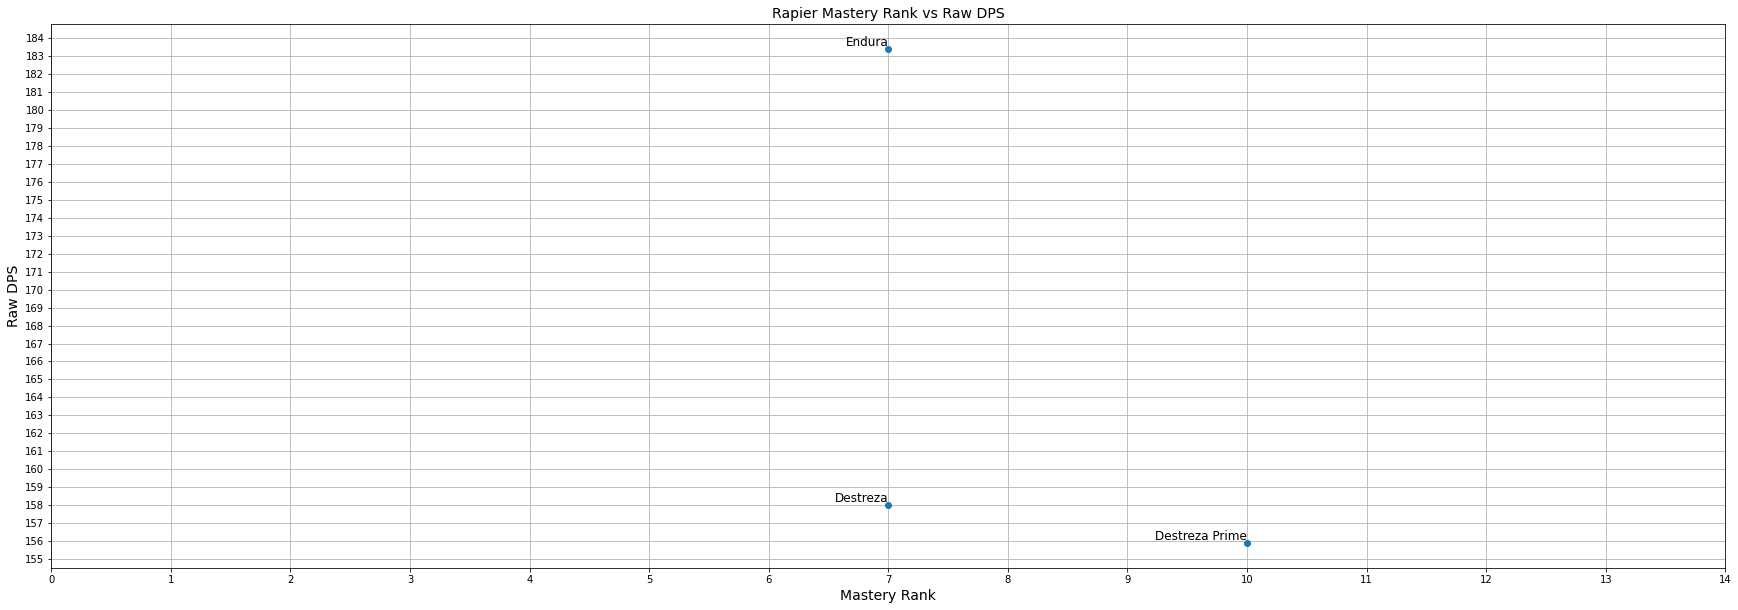

In [32]:
RapierDF = CleanedWeapon.loc[CleanedWeapon['Type'] == "Rapier"]
RapierDF = RapierDF.sort_values(by=['Mastery_Rank'])

plt.figure(figsize=(30, 10))
ax = RapierDF.set_index('Mastery_Rank')['RawDPS'].plot(style='o')

label_point(RapierDF.Mastery_Rank, RapierDF.RawDPS, RapierDF.Name, ax)
plt.xticks(np.arange(0, 15, 1))
plt.yticks(np.arange(155, 185, 1.0))
plt.title("Rapier Mastery Rank vs Raw DPS", fontsize = 14)
plt.xlabel("Mastery Rank", fontsize = 14)
plt.ylabel("Raw DPS", fontsize = 14)
plt.grid()
plt.show()

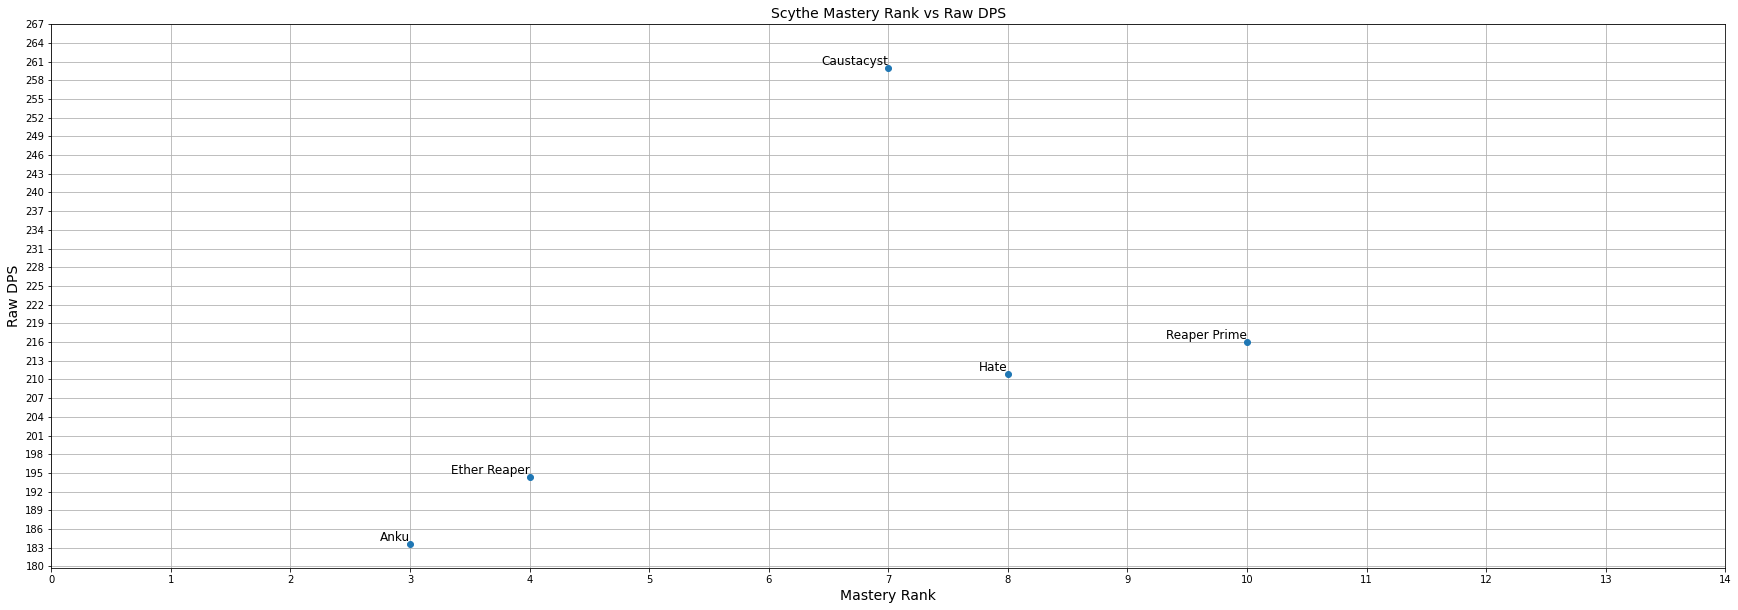

In [33]:
ScytheDF = CleanedWeapon.loc[CleanedWeapon['Type'] == "Scythe"]
ScytheDF = ScytheDF.sort_values(by=['Mastery_Rank'])

plt.figure(figsize=(30, 10))
ax = ScytheDF.set_index('Mastery_Rank')['RawDPS'].plot(style='o')

label_point(ScytheDF.Mastery_Rank, ScytheDF.RawDPS, ScytheDF.Name, ax)
plt.xticks(np.arange(0, 15, 1))
plt.yticks(np.arange(180, 270, 3.0))
plt.title("Scythe Mastery Rank vs Raw DPS", fontsize = 14)
plt.xlabel("Mastery Rank", fontsize = 14)
plt.ylabel("Raw DPS", fontsize = 14)
plt.grid()
plt.show()

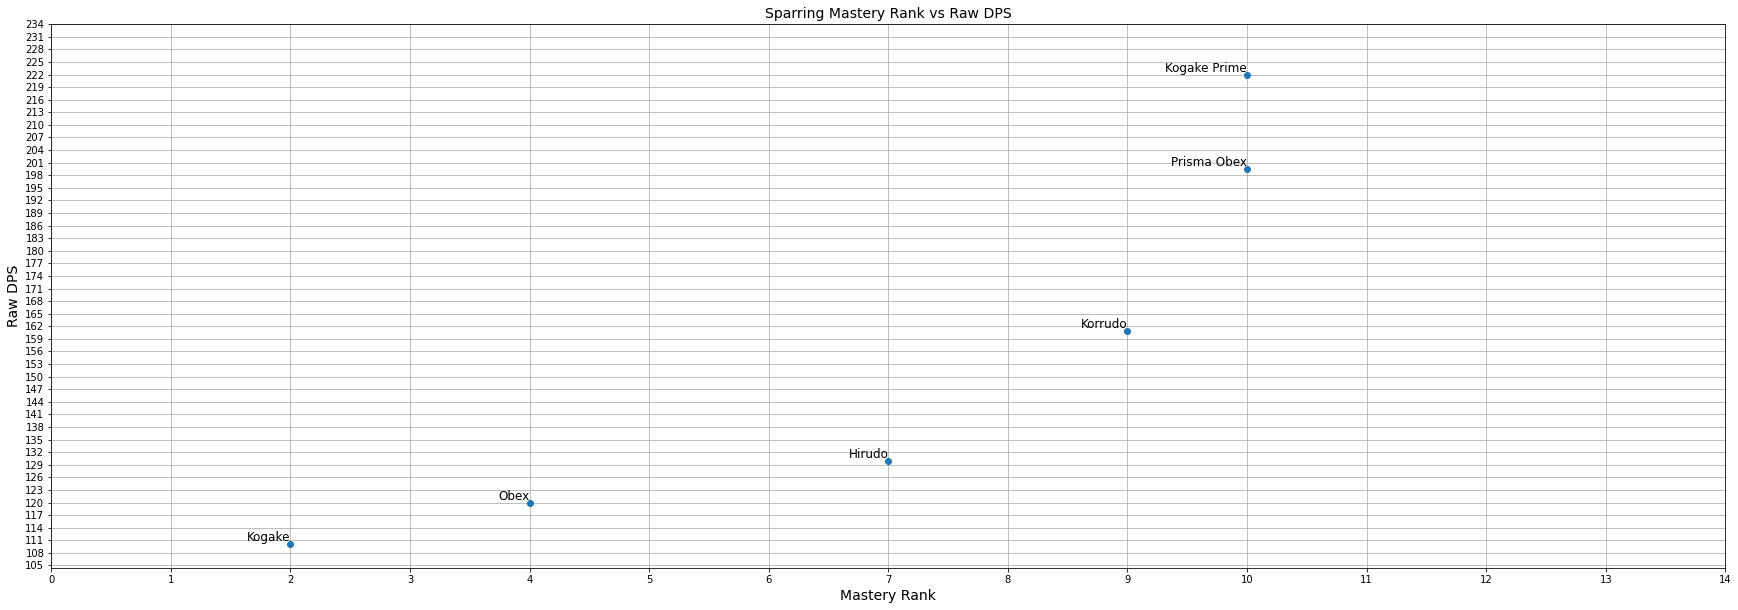

In [34]:
SparringDF = CleanedWeapon.loc[CleanedWeapon['Type'] == "Sparring"]
SparringDF = SparringDF.sort_values(by=['Mastery_Rank'])

plt.figure(figsize=(30, 10))
ax = SparringDF.set_index('Mastery_Rank')['RawDPS'].plot(style='o')

label_point(SparringDF.Mastery_Rank, SparringDF.RawDPS, SparringDF.Name, ax)
plt.xticks(np.arange(0, 15, 1))
plt.yticks(np.arange(105, 235, 3.0))
plt.title("Sparring Mastery Rank vs Raw DPS", fontsize = 14)
plt.xlabel("Mastery Rank", fontsize = 14)
plt.ylabel("Raw DPS", fontsize = 14)
plt.grid()
plt.show()

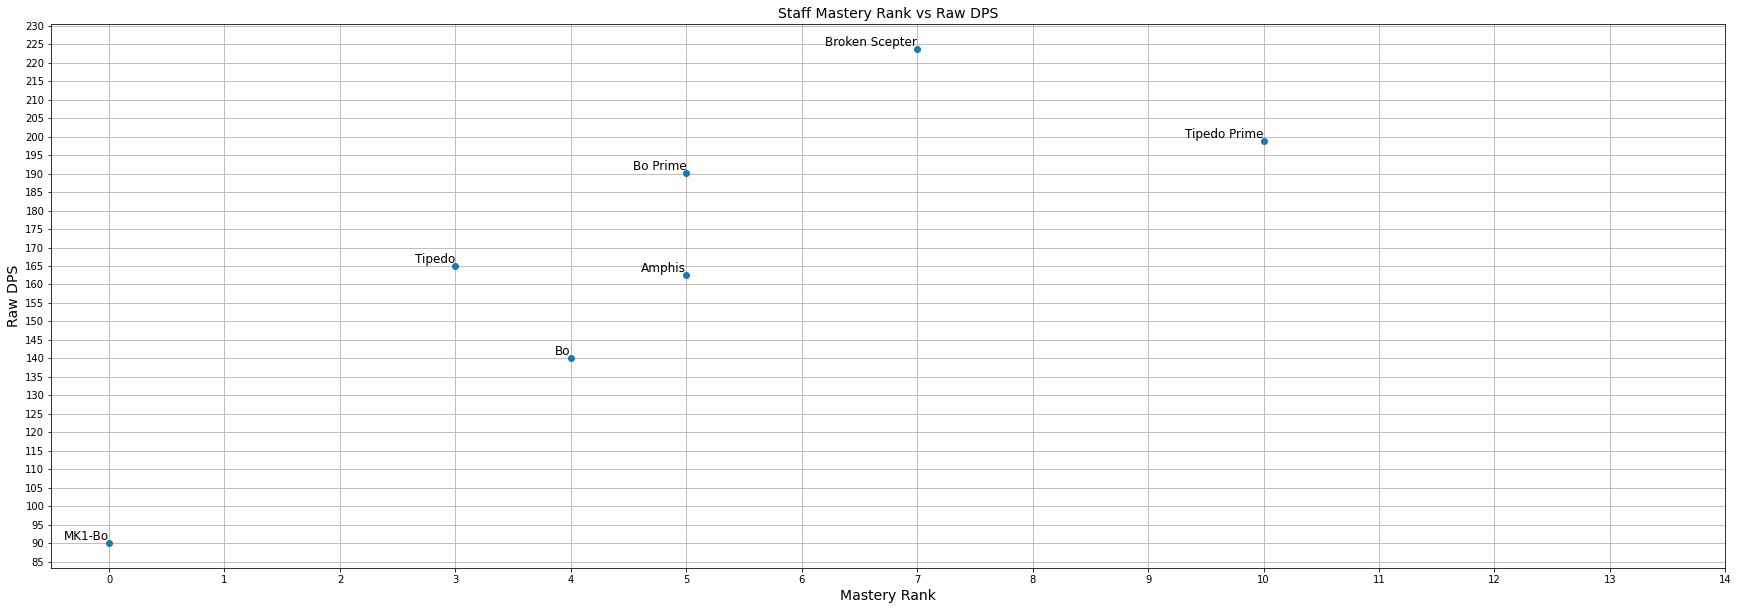

In [35]:
StaffDF = CleanedWeapon.loc[CleanedWeapon['Type'] == "Staff"]
StaffDF = StaffDF.sort_values(by=['Mastery_Rank'])

plt.figure(figsize=(30, 10))
ax = StaffDF.set_index('Mastery_Rank')['RawDPS'].plot(style='o')

label_point(StaffDF.Mastery_Rank, StaffDF.RawDPS, StaffDF.Name, ax)
plt.xticks(np.arange(0, 15, 1))
plt.yticks(np.arange(85, 235, 5.0))
plt.title("Staff Mastery Rank vs Raw DPS", fontsize = 14)
plt.xlabel("Mastery Rank", fontsize = 14)
plt.ylabel("Raw DPS", fontsize = 14)
plt.grid()
plt.show()

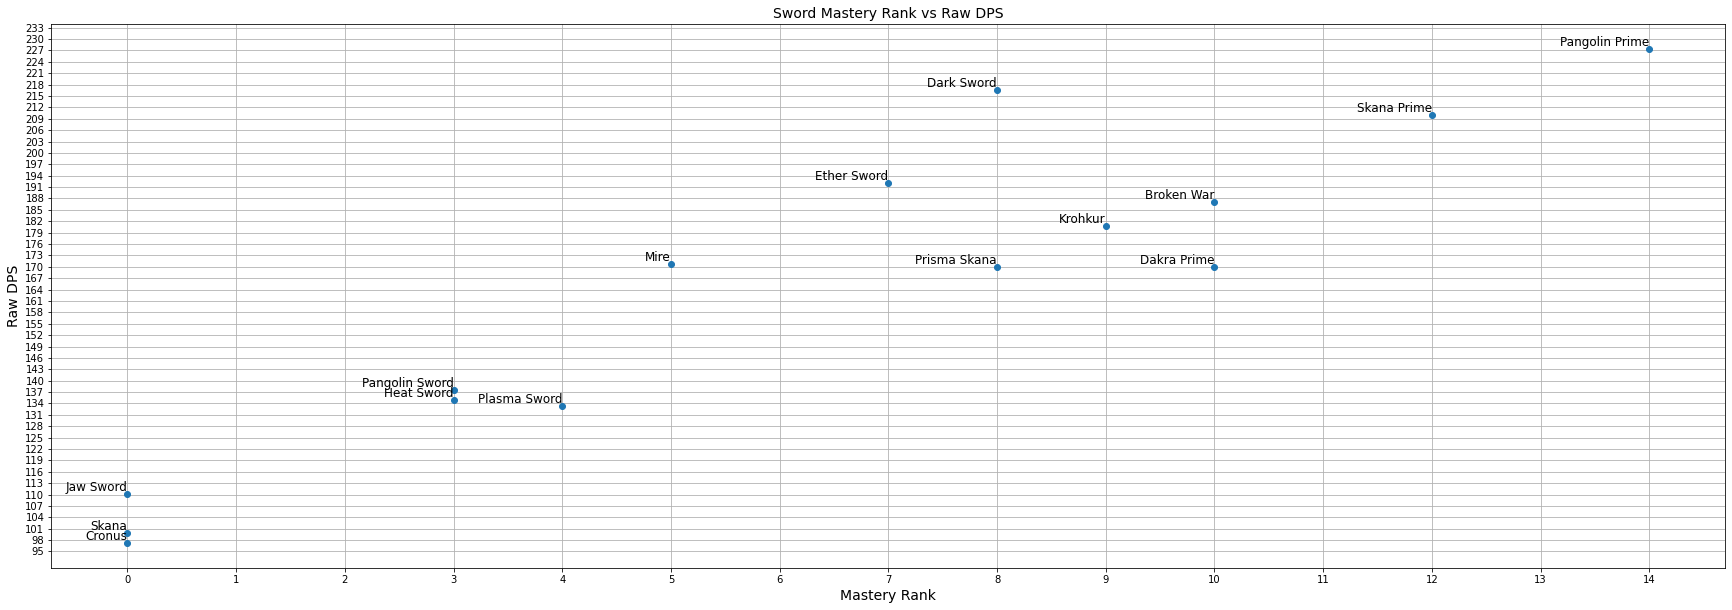

In [36]:
SwordDF = CleanedWeapon.loc[CleanedWeapon['Type'] == "Sword"]
SwordDF = SwordDF.sort_values(by=['Mastery_Rank'])

plt.figure(figsize=(30, 10))
ax = SwordDF.set_index('Mastery_Rank')['RawDPS'].plot(style='o')

label_point(SwordDF.Mastery_Rank, SwordDF.RawDPS, SwordDF.Name, ax)
plt.xticks(np.arange(0, 15, 1))
plt.yticks(np.arange(95, 235, 3.0))
plt.title("Sword Mastery Rank vs Raw DPS", fontsize = 14)
plt.xlabel("Mastery Rank", fontsize = 14)
plt.ylabel("Raw DPS", fontsize = 14)
plt.grid()
plt.show()

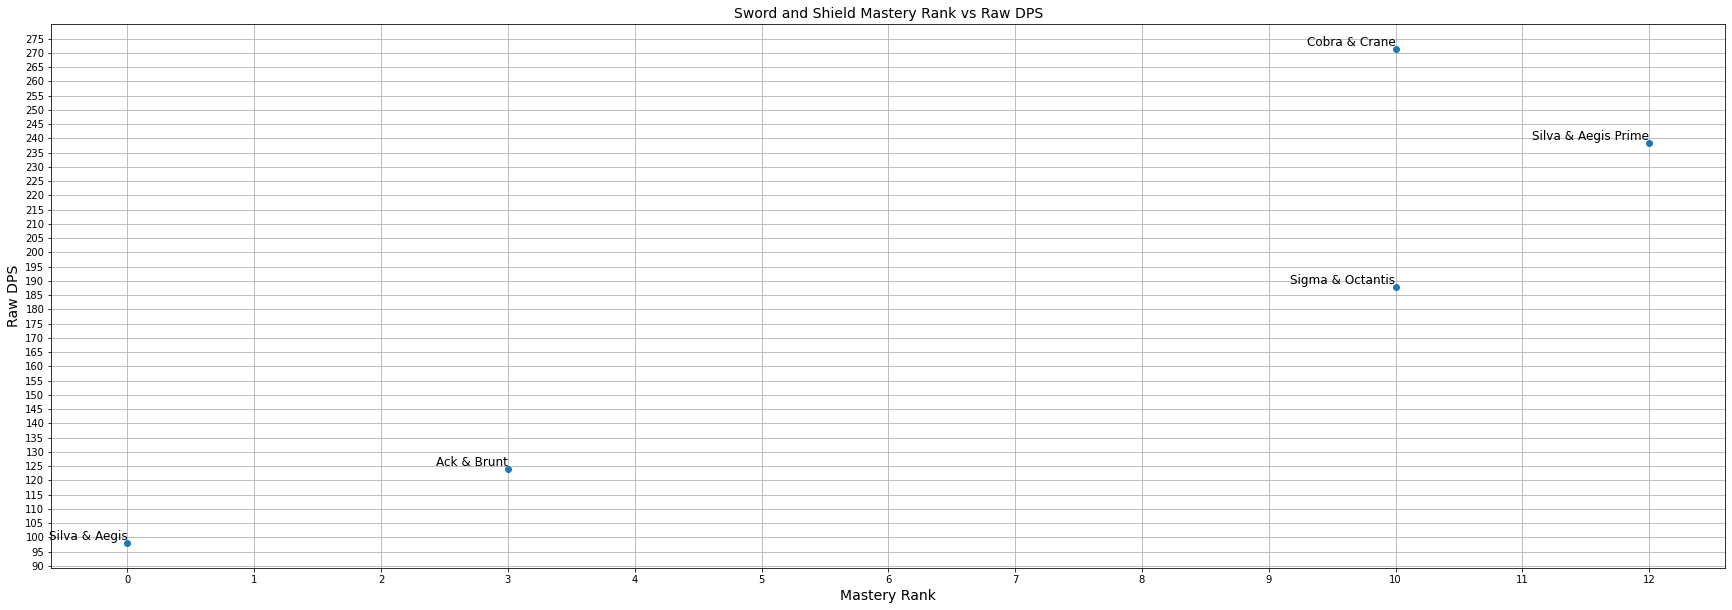

In [37]:
SWSHDF = CleanedWeapon.loc[CleanedWeapon['Type'] == "Sword and Shield"]
SWSHDF = SWSHDF.sort_values(by=['Mastery_Rank'])

plt.figure(figsize=(30, 10))
ax = SWSHDF.set_index('Mastery_Rank')['RawDPS'].plot(style='o')

label_point(SWSHDF.Mastery_Rank, SWSHDF.RawDPS, SWSHDF.Name, ax)
plt.xticks(np.arange(0, 13, 1))
plt.yticks(np.arange(90, 280, 5.0))
plt.title("Sword and Shield Mastery Rank vs Raw DPS", fontsize = 14)
plt.xlabel("Mastery Rank", fontsize = 14)
plt.ylabel("Raw DPS", fontsize = 14)
plt.grid()
plt.show()

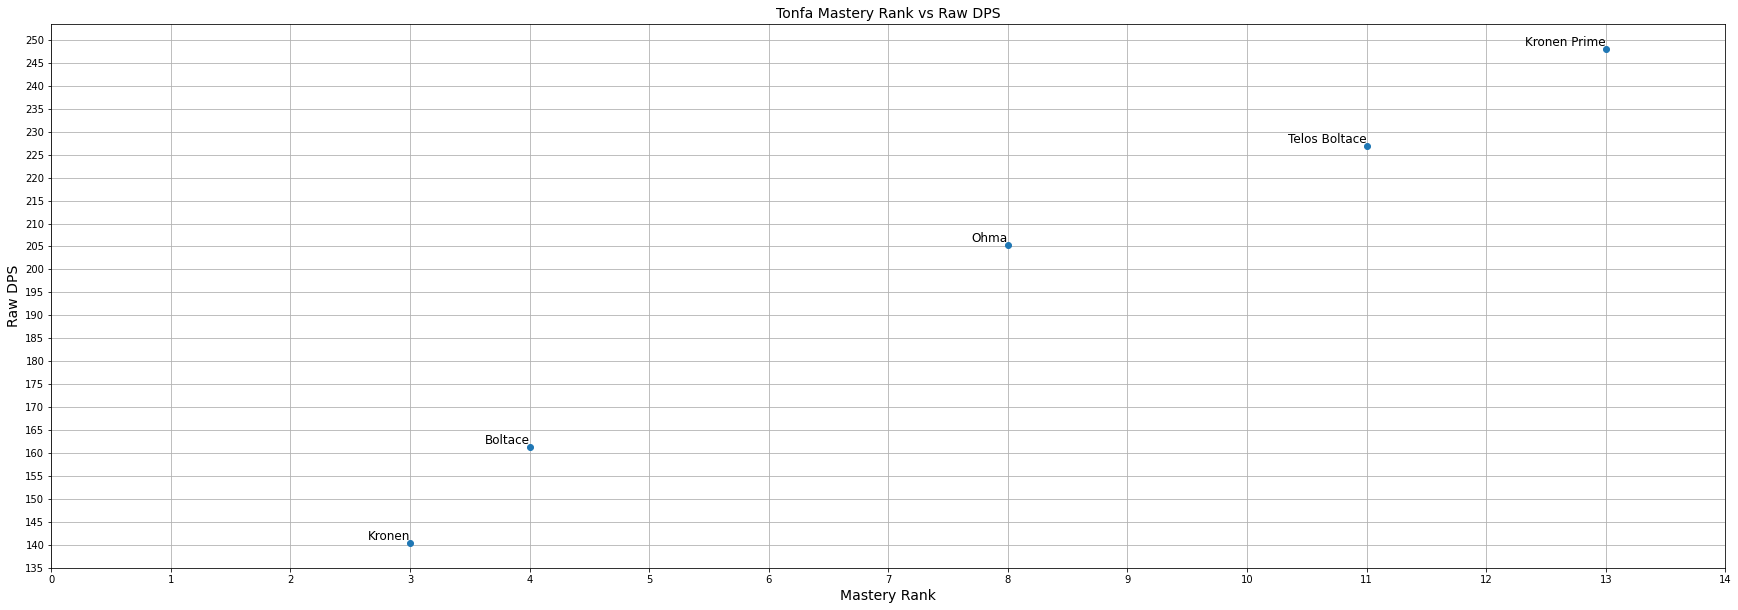

In [38]:
TonfaDF = CleanedWeapon.loc[CleanedWeapon['Type'] == "Tonfa"]
TonfaDF = TonfaDF.sort_values(by=['Mastery_Rank'])

plt.figure(figsize=(30, 10))
ax = TonfaDF.set_index('Mastery_Rank')['RawDPS'].plot(style='o')

label_point(TonfaDF.Mastery_Rank, TonfaDF.RawDPS, TonfaDF.Name, ax)
plt.xticks(np.arange(0, 15, 1))
plt.yticks(np.arange(135, 255, 5.0))
plt.title("Tonfa Mastery Rank vs Raw DPS", fontsize = 14)
plt.xlabel("Mastery Rank", fontsize = 14)
plt.ylabel("Raw DPS", fontsize = 14)
plt.grid()
plt.show()

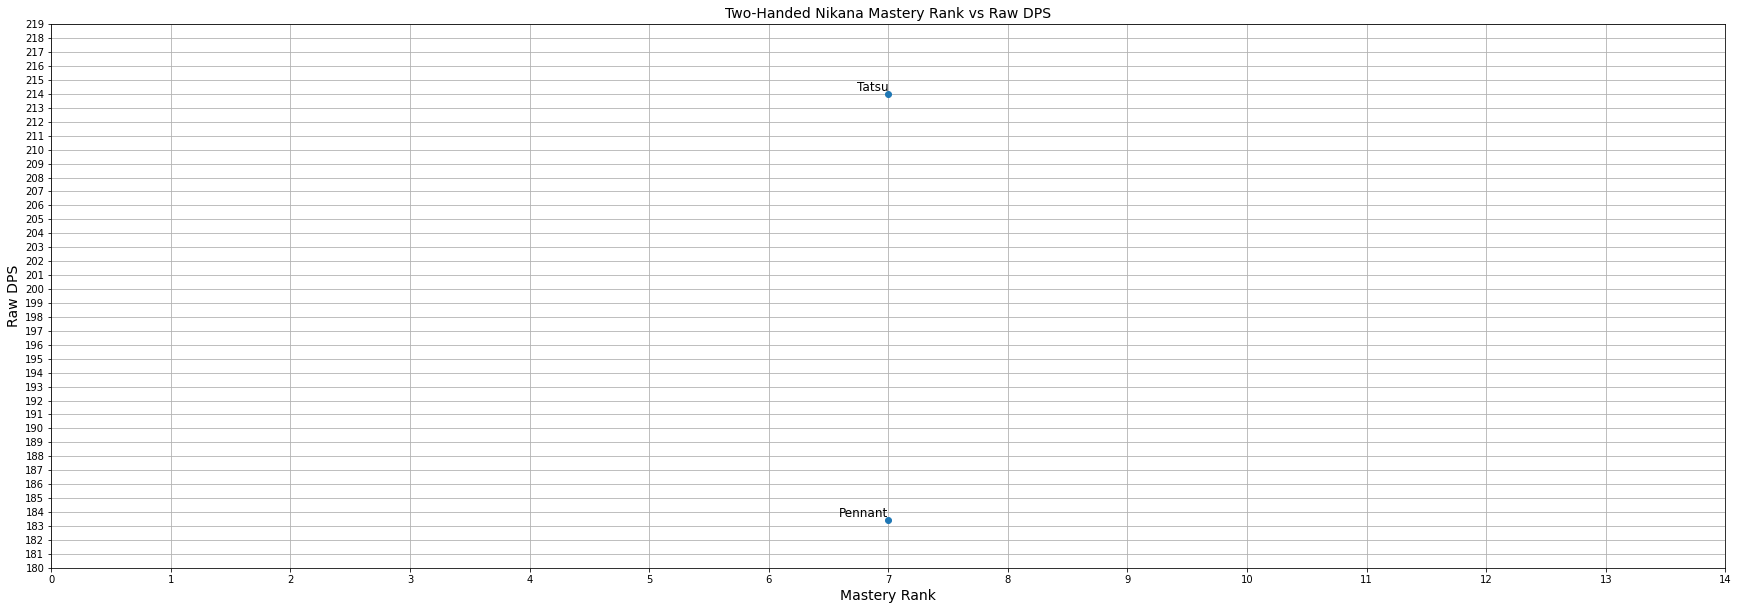

In [39]:
HeavyNikDF = CleanedWeapon.loc[CleanedWeapon['Type'] == "Two-Handed Nikana"]
HeavyNikDF = HeavyNikDF.sort_values(by=['Mastery_Rank'])

plt.figure(figsize=(30, 10))
ax = HeavyNikDF.set_index('Mastery_Rank')['RawDPS'].plot(style='o')

label_point(HeavyNikDF.Mastery_Rank, HeavyNikDF.RawDPS, HeavyNikDF.Name, ax)
plt.xticks(np.arange(0, 15, 1))
plt.yticks(np.arange(180, 220, 1.0))
plt.title("Two-Handed Nikana Mastery Rank vs Raw DPS", fontsize = 14)
plt.xlabel("Mastery Rank", fontsize = 14)
plt.ylabel("Raw DPS", fontsize = 14)
plt.grid()
plt.show()

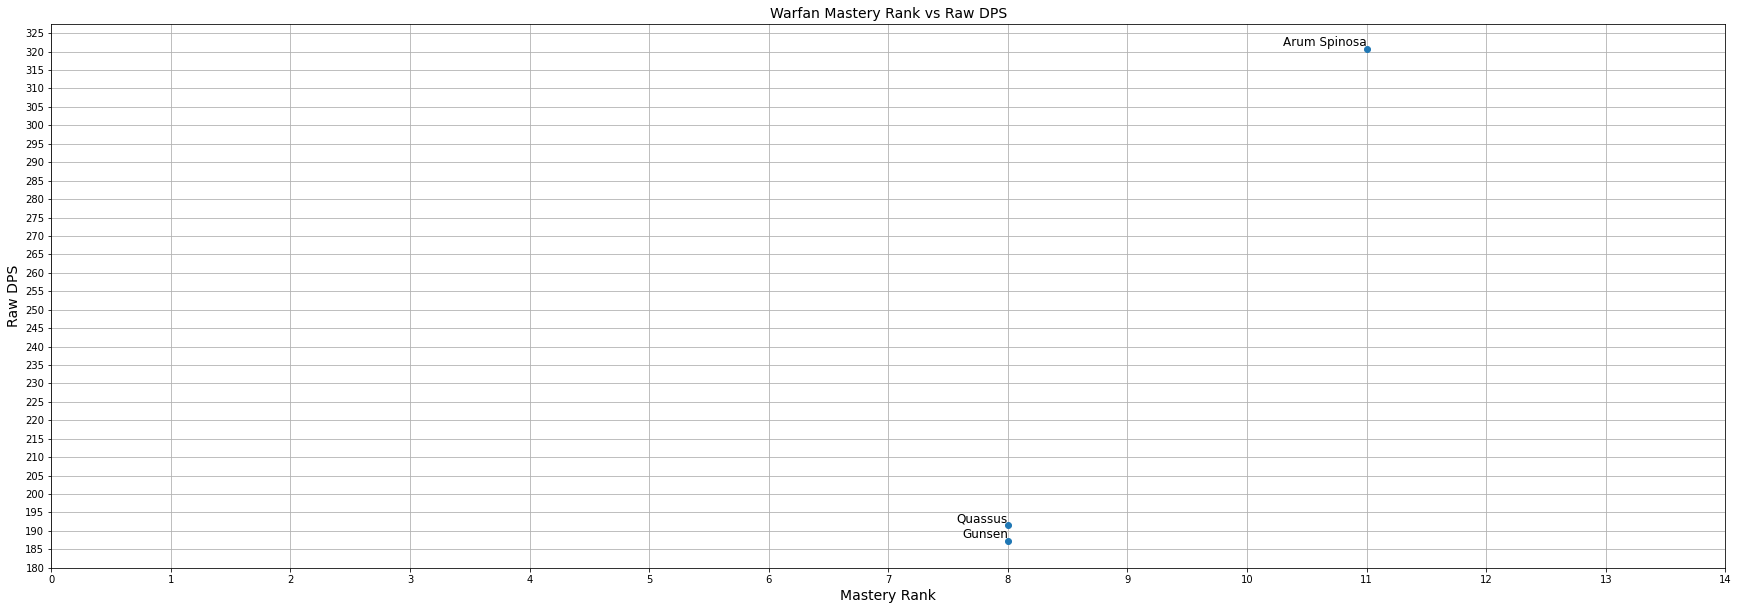

In [40]:
FanDF = CleanedWeapon.loc[CleanedWeapon['Type'] == "Warfan"]
FanDF = FanDF.sort_values(by=['Mastery_Rank'])

plt.figure(figsize=(30, 10))
ax = FanDF.set_index('Mastery_Rank')['RawDPS'].plot(style='o')

label_point(FanDF.Mastery_Rank, FanDF.RawDPS, FanDF.Name, ax)
plt.xticks(np.arange(0, 15, 1))
plt.yticks(np.arange(180, 330, 5.0))
plt.title("Warfan Mastery Rank vs Raw DPS", fontsize = 14)
plt.xlabel("Mastery Rank", fontsize = 14)
plt.ylabel("Raw DPS", fontsize = 14)
plt.grid()
plt.show()

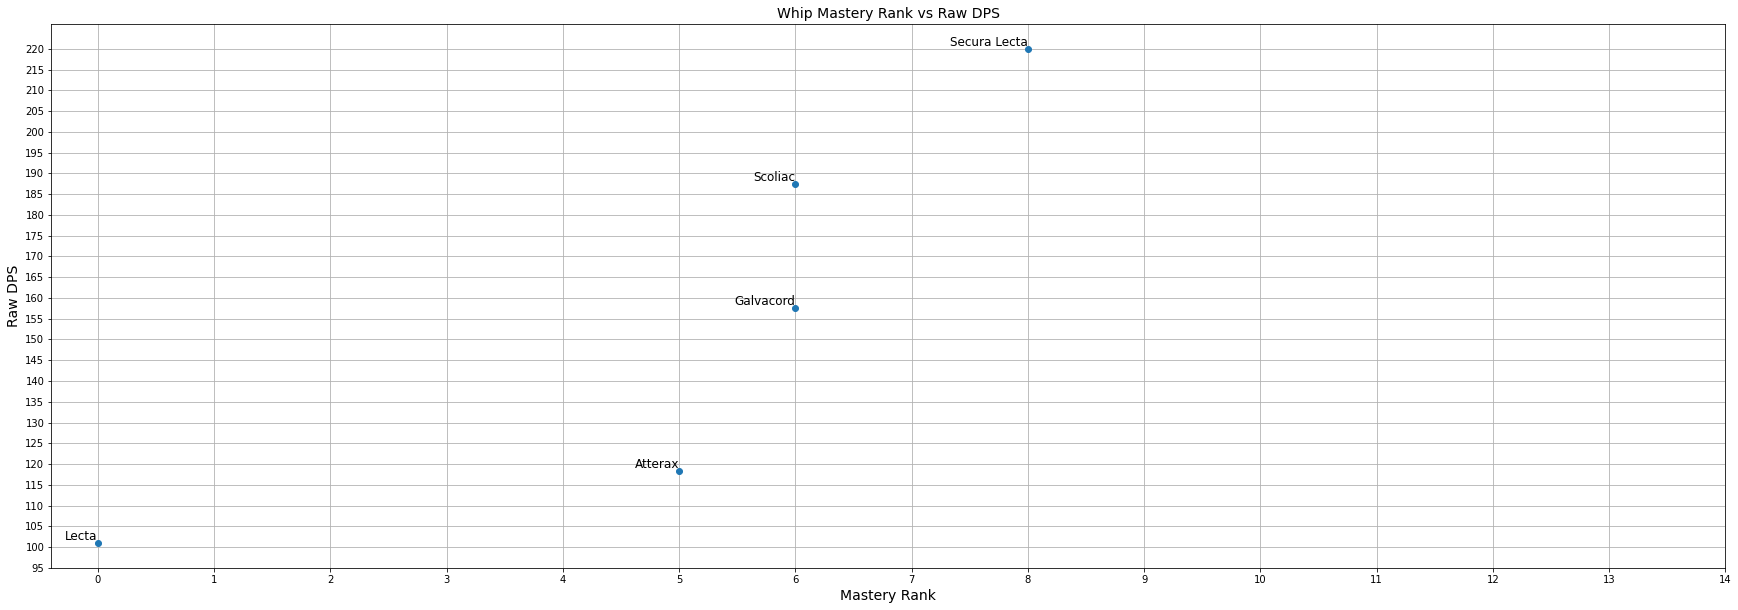

In [41]:
WhipDF = CleanedWeapon.loc[CleanedWeapon['Type'] == "Whip"]
WhipDF = WhipDF.sort_values(by=['Mastery_Rank'])

plt.figure(figsize=(30, 10))
ax = WhipDF.set_index('Mastery_Rank')['RawDPS'].plot(style='o')

label_point(WhipDF.Mastery_Rank, WhipDF.RawDPS, WhipDF.Name, ax)
plt.xticks(np.arange(0, 15, 1))
plt.yticks(np.arange(95, 225, 5.0))
plt.title("Whip Mastery Rank vs Raw DPS", fontsize = 14)
plt.xlabel("Mastery Rank", fontsize = 14)
plt.ylabel("Raw DPS", fontsize = 14)
plt.grid()
plt.show()

# Task 6 Base Crit Damage versus Mastery Rank

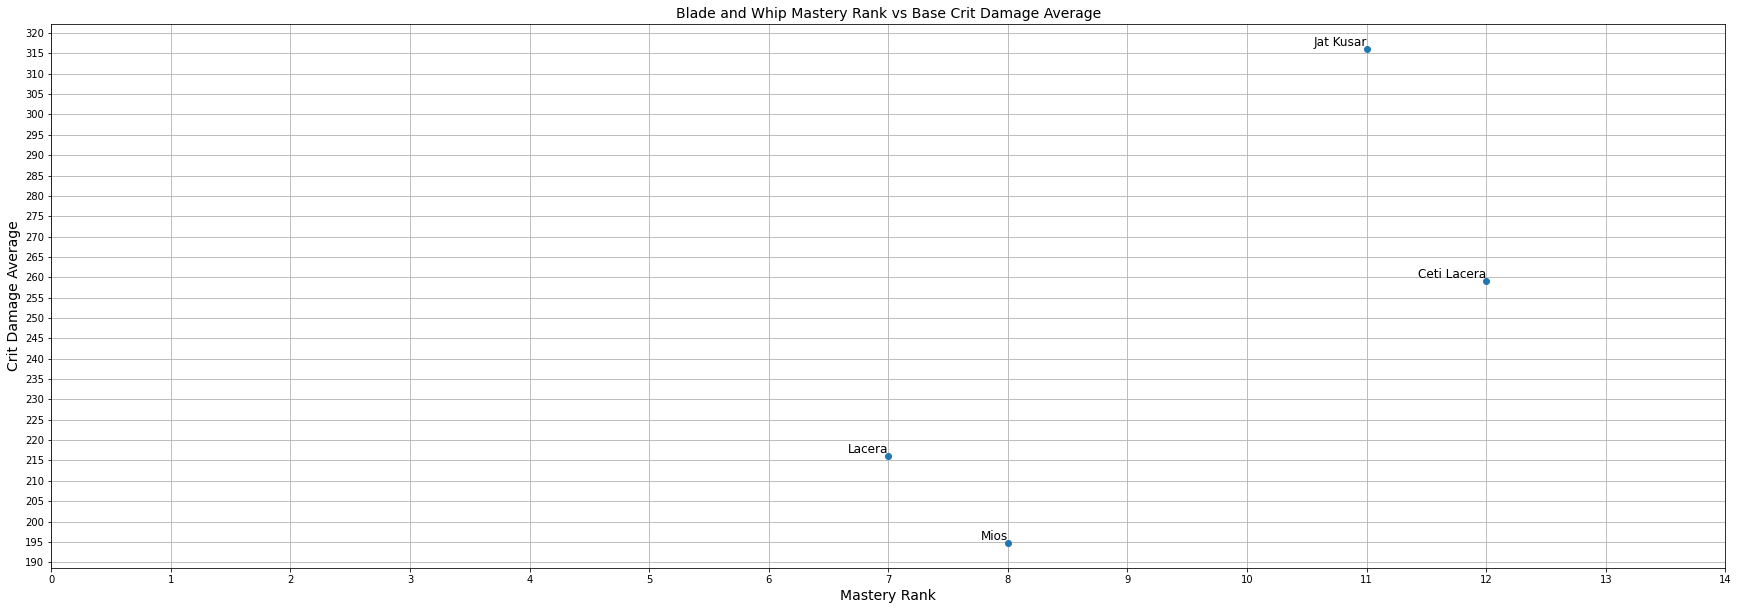

In [42]:
plt.figure(figsize=(30, 10))
ax = BLWPDF.set_index('Mastery_Rank')['AverageCritDamage'].plot(style='o')

label_point(BLWPDF.Mastery_Rank, BLWPDF.AverageCritDamage, BLWPDF.Name, ax)
plt.xticks(np.arange(0, 15, 1))
plt.yticks(np.arange(190, 325, 5.0))
plt.title("Blade and Whip Mastery Rank vs Base Crit Damage Average", fontsize = 14)
plt.xlabel("Mastery Rank", fontsize = 14)
plt.ylabel("Crit Damage Average", fontsize = 14)
plt.grid()
plt.show()

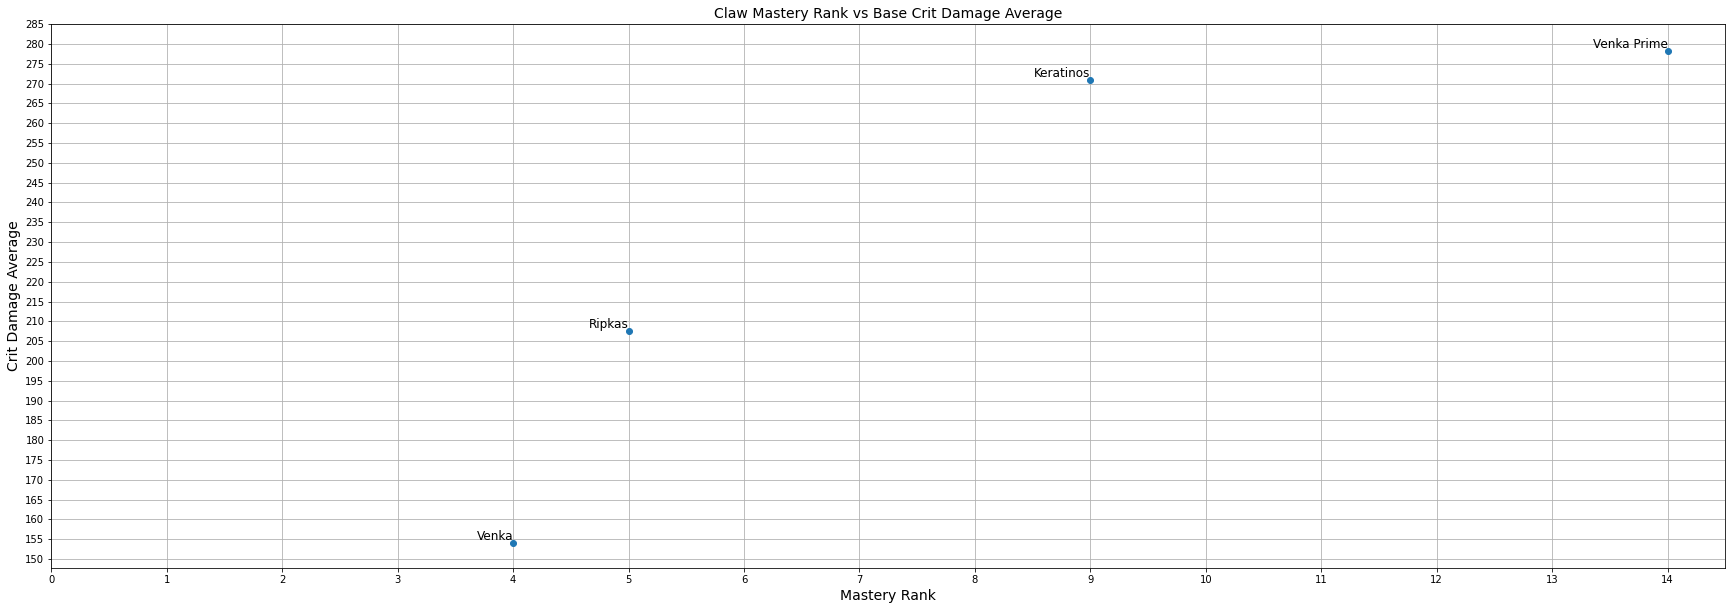

In [43]:
plt.figure(figsize=(30, 10))
ax = ClawDF.set_index('Mastery_Rank')['AverageCritDamage'].plot(style='o')

label_point(ClawDF.Mastery_Rank, ClawDF.AverageCritDamage, ClawDF.Name, ax)
plt.xticks(np.arange(0, 15, 1))
plt.yticks(np.arange(150, 290, 5.0))
plt.title("Claw Mastery Rank vs Base Crit Damage Average", fontsize = 14)
plt.xlabel("Mastery Rank", fontsize = 14)
plt.ylabel("Crit Damage Average", fontsize = 14)
plt.grid()
plt.show()

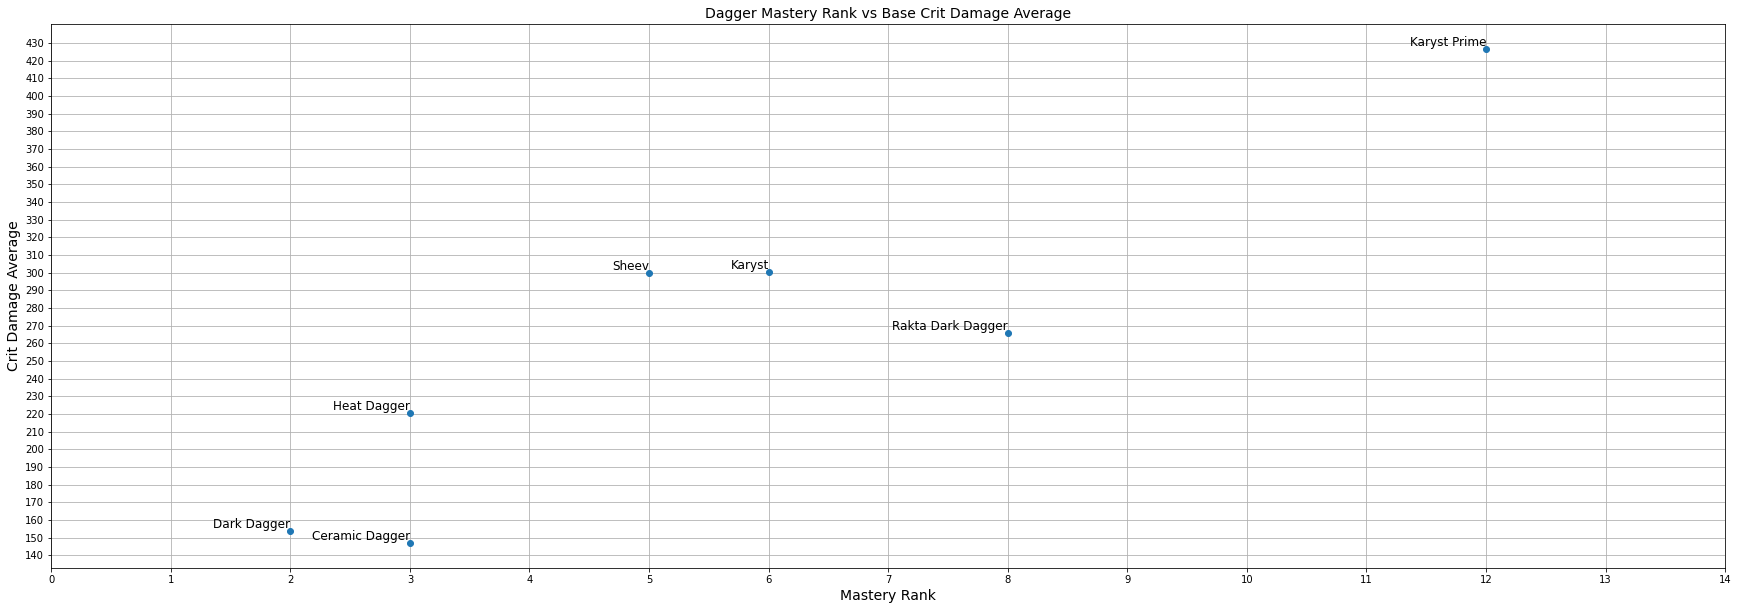

In [44]:
plt.figure(figsize=(30, 10))
ax = DaggerDF.set_index('Mastery_Rank')['AverageCritDamage'].plot(style='o')

label_point(DaggerDF.Mastery_Rank, DaggerDF.AverageCritDamage, DaggerDF.Name, ax)
plt.xticks(np.arange(0, 15, 1))
plt.yticks(np.arange(140, 440, 10.0))
plt.title("Dagger Mastery Rank vs Base Crit Damage Average", fontsize = 14)
plt.xlabel("Mastery Rank", fontsize = 14)
plt.ylabel("Crit Damage Average", fontsize = 14)
plt.grid()
plt.show()

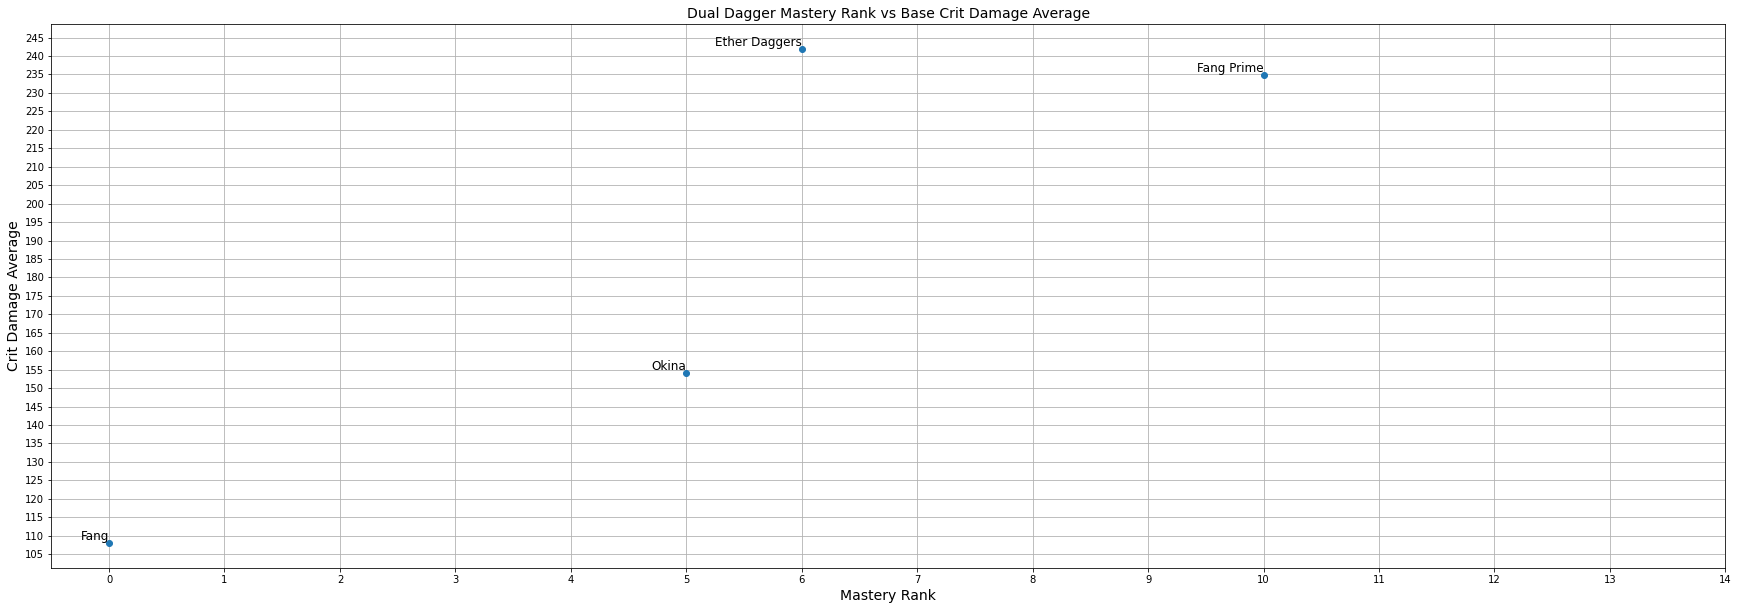

In [45]:
plt.figure(figsize=(30, 10))
ax = DDaggerDF.set_index('Mastery_Rank')['AverageCritDamage'].plot(style='o')

label_point(DDaggerDF.Mastery_Rank, DDaggerDF.AverageCritDamage, DDaggerDF.Name, ax)
plt.xticks(np.arange(0, 15, 1))
plt.yticks(np.arange(105, 250, 5.0))
plt.title("Dual Dagger Mastery Rank vs Base Crit Damage Average", fontsize = 14)
plt.xlabel("Mastery Rank", fontsize = 14)
plt.ylabel("Crit Damage Average", fontsize = 14)
plt.grid()
plt.show()

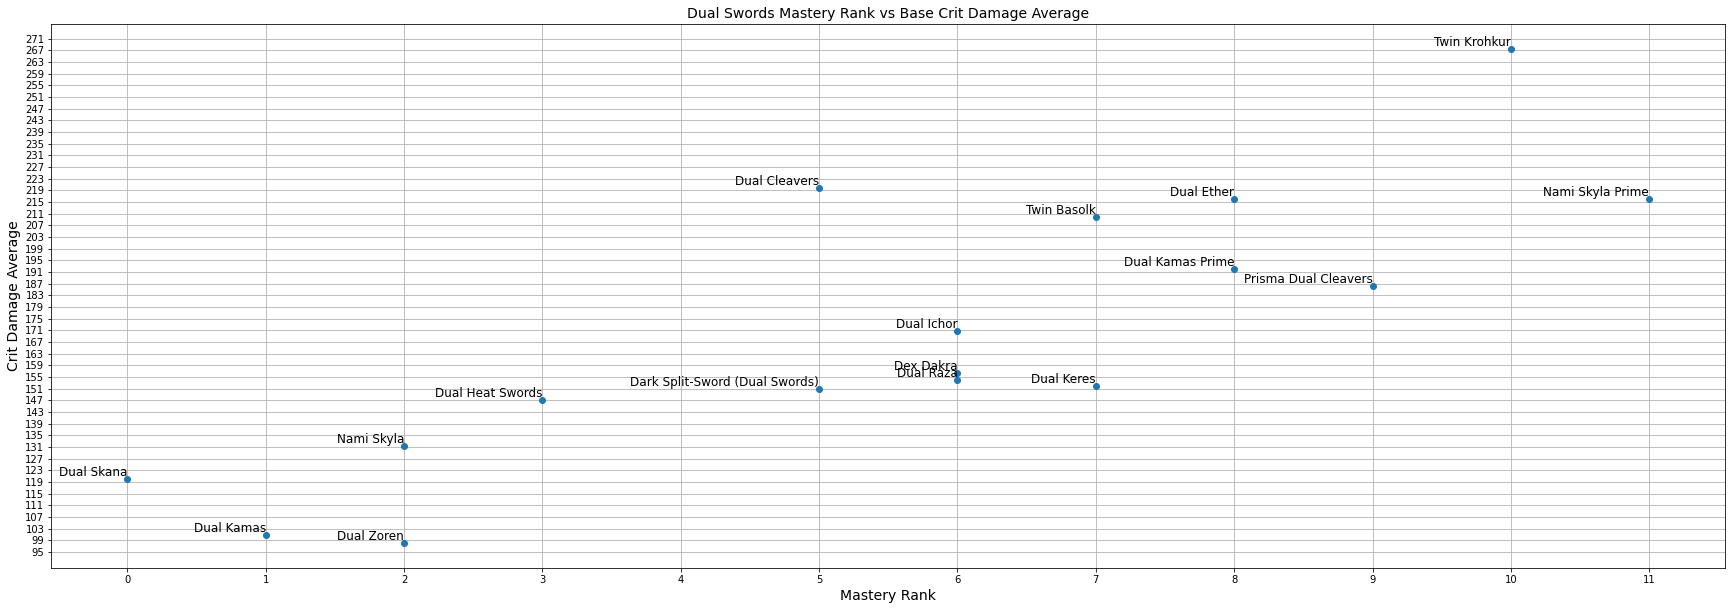

In [46]:
plt.figure(figsize=(30, 10))
ax = DualDF.set_index('Mastery_Rank')['AverageCritDamage'].plot(style='o')

label_point(DualDF.Mastery_Rank, DualDF.AverageCritDamage, DualDF.Name, ax)
plt.xticks(np.arange(0, 12, 1))
plt.yticks(np.arange(95, 275, 4.0))
plt.title("Dual Swords Mastery Rank vs Base Crit Damage Average", fontsize = 14)
plt.xlabel("Mastery Rank", fontsize = 14)
plt.ylabel("Crit Damage Average", fontsize = 14)
plt.grid()
plt.show()

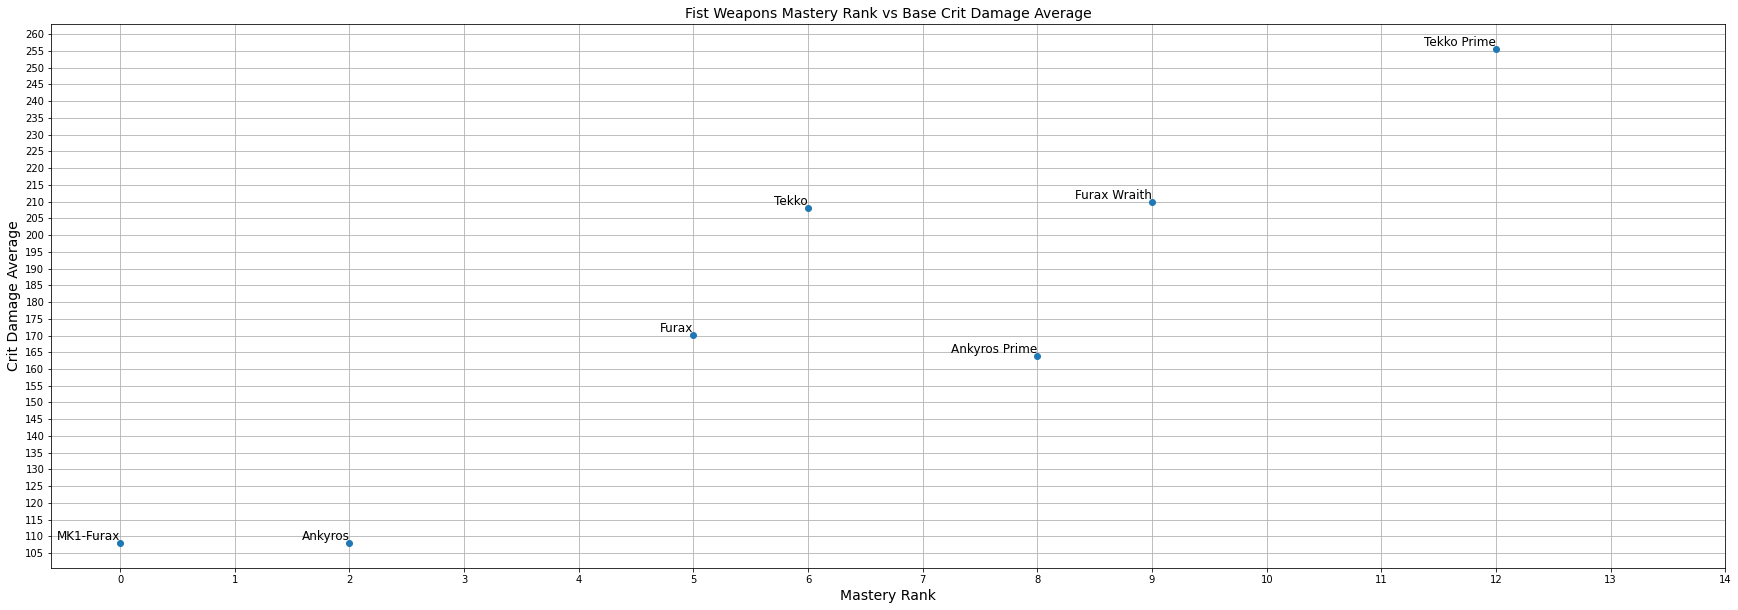

In [47]:
plt.figure(figsize=(30, 10))
ax = FistDF.set_index('Mastery_Rank')['AverageCritDamage'].plot(style='o')

label_point(FistDF.Mastery_Rank, FistDF.AverageCritDamage, FistDF.Name, ax)
plt.xticks(np.arange(0, 15, 1))
plt.yticks(np.arange(105, 265, 5.0))
plt.title("Fist Weapons Mastery Rank vs Base Crit Damage Average", fontsize = 14)
plt.xlabel("Mastery Rank", fontsize = 14)
plt.ylabel("Crit Damage Average", fontsize = 14)
plt.grid()
plt.show()

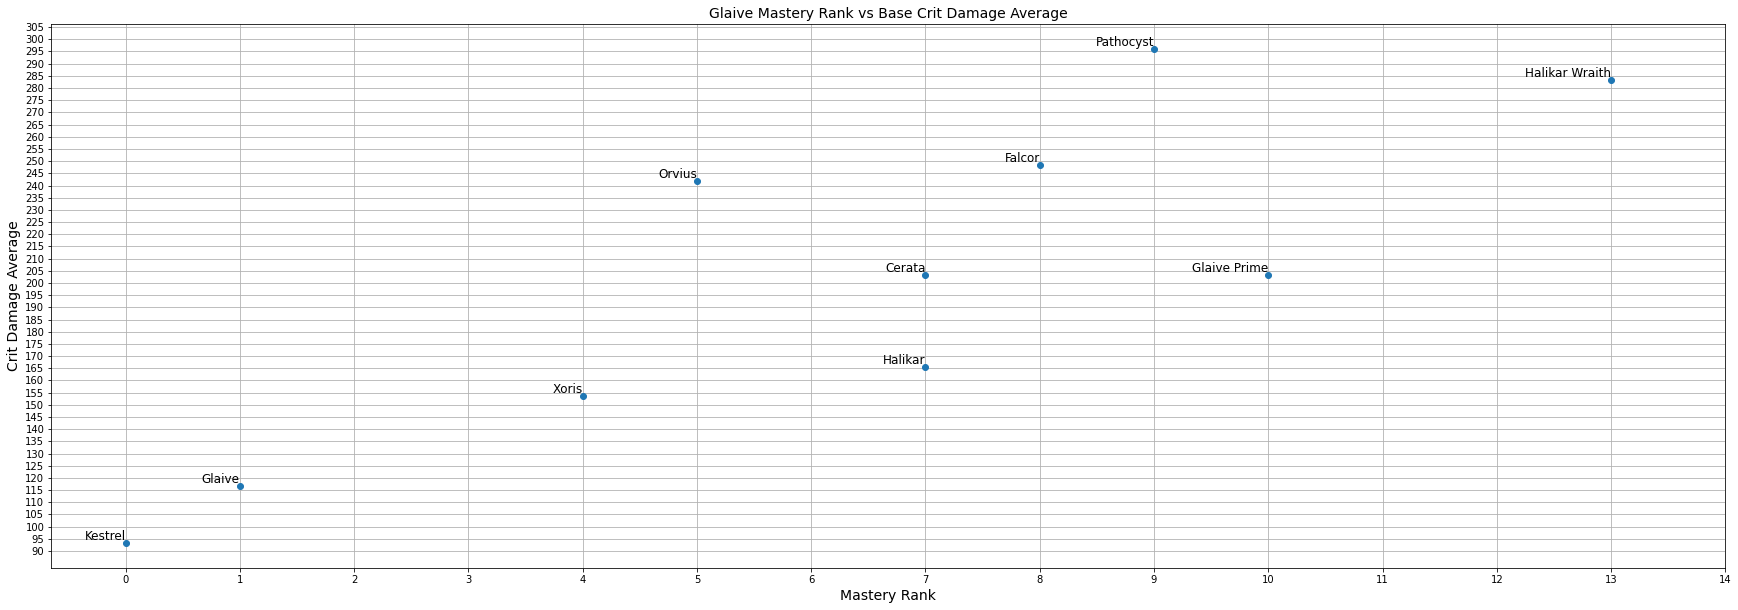

In [48]:
plt.figure(figsize=(30, 10))
ax = GlaiveDF.set_index('Mastery_Rank')['AverageCritDamage'].plot(style='o')

label_point(GlaiveDF.Mastery_Rank, GlaiveDF.AverageCritDamage, GlaiveDF.Name, ax)
plt.xticks(np.arange(0, 15, 1))
plt.yticks(np.arange(90, 310, 5.0))
plt.title("Glaive Mastery Rank vs Base Crit Damage Average", fontsize = 14)
plt.xlabel("Mastery Rank", fontsize = 14)
plt.ylabel("Crit Damage Average", fontsize = 14)
plt.grid()
plt.show()

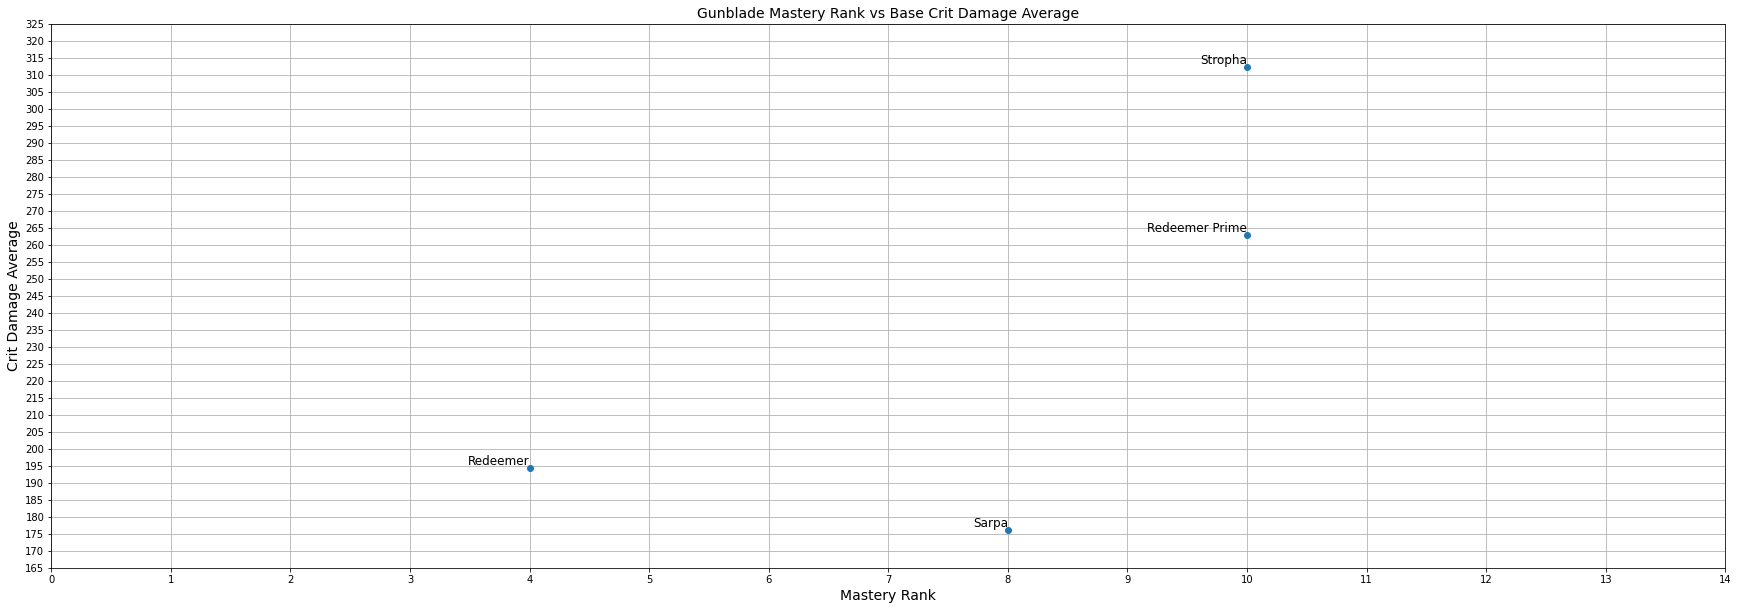

In [49]:
plt.figure(figsize=(30, 10))
ax = GunBladeDF.set_index('Mastery_Rank')['AverageCritDamage'].plot(style='o')

label_point(GunBladeDF.Mastery_Rank, GunBladeDF.AverageCritDamage, GunBladeDF.Name, ax)
plt.xticks(np.arange(0, 15, 1))
plt.yticks(np.arange(165, 330, 5.0))
plt.title("Gunblade Mastery Rank vs Base Crit Damage Average", fontsize = 14)
plt.xlabel("Mastery Rank", fontsize = 14)
plt.ylabel("Crit Damage Average", fontsize = 14)
plt.grid()
plt.show()

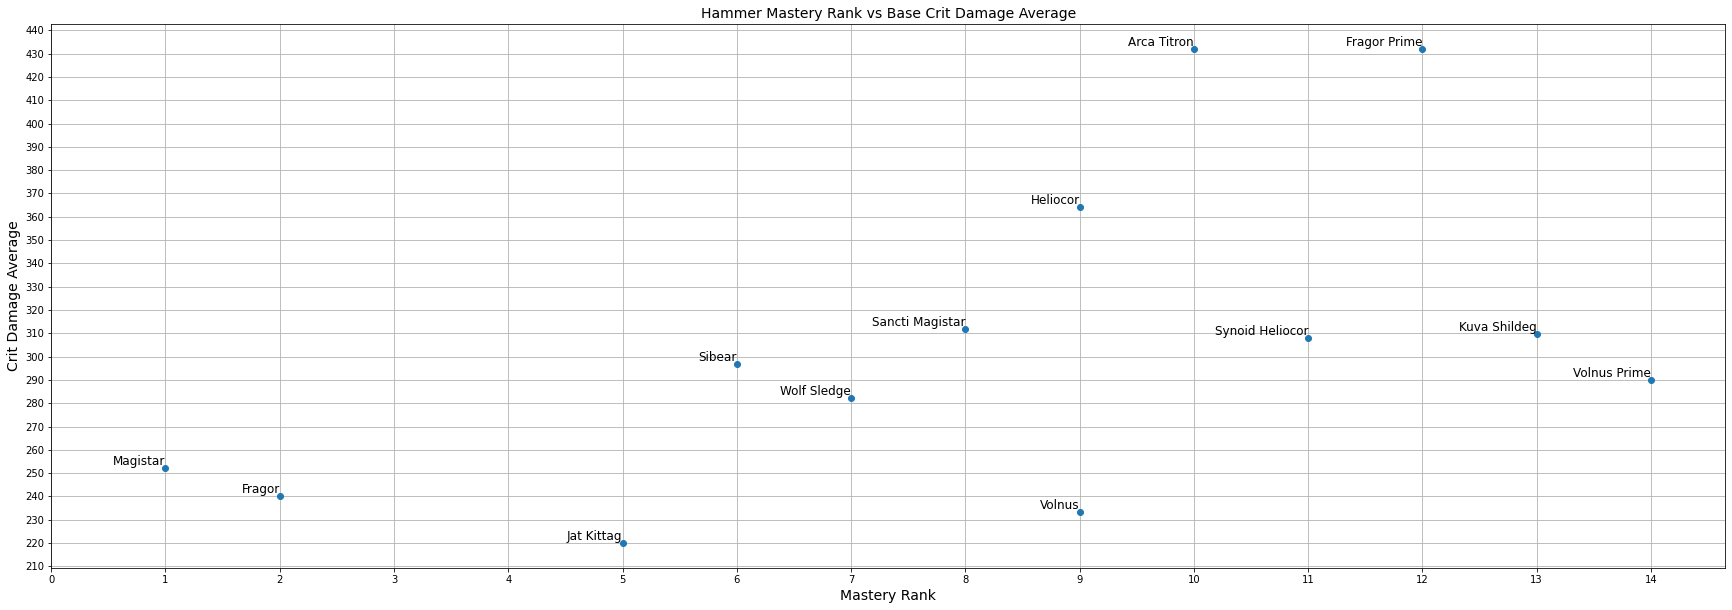

In [50]:
plt.figure(figsize=(30, 10))
ax = HammerDF.set_index('Mastery_Rank')['AverageCritDamage'].plot(style='o')

label_point(HammerDF.Mastery_Rank, HammerDF.AverageCritDamage, HammerDF.Name, ax)
plt.xticks(np.arange(0, 15, 1))
plt.yticks(np.arange(210, 450, 10.0))
plt.title("Hammer Mastery Rank vs Base Crit Damage Average", fontsize = 14)
plt.xlabel("Mastery Rank", fontsize = 14)
plt.ylabel("Crit Damage Average", fontsize = 14)
plt.grid()
plt.show()

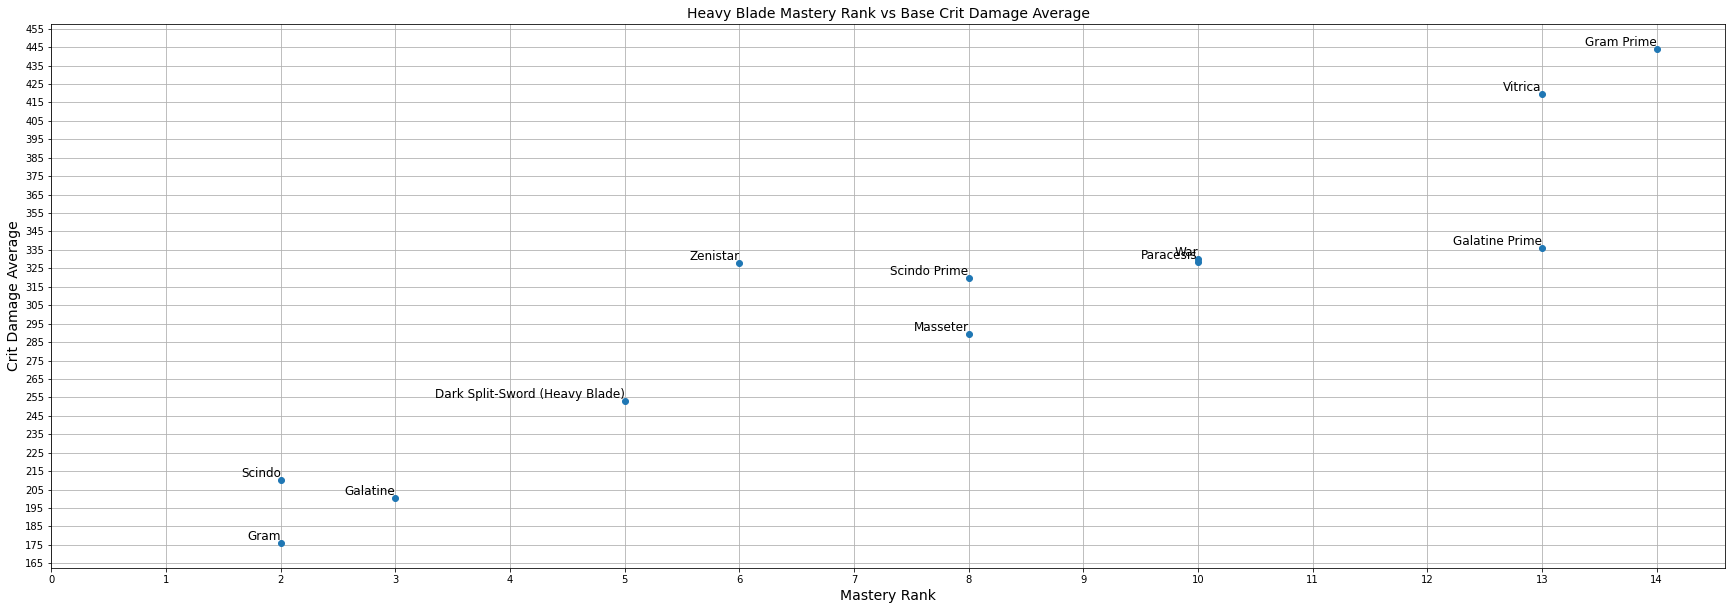

In [51]:
plt.figure(figsize=(30, 10))
ax = HeavyBLDF.set_index('Mastery_Rank')['AverageCritDamage'].plot(style='o')

label_point(HeavyBLDF.Mastery_Rank, HeavyBLDF.AverageCritDamage, HeavyBLDF.Name, ax)
plt.xticks(np.arange(0, 15, 1))
plt.yticks(np.arange(165, 460, 10.0))
plt.title("Heavy Blade Mastery Rank vs Base Crit Damage Average", fontsize = 14)
plt.xlabel("Mastery Rank", fontsize = 14)
plt.ylabel("Crit Damage Average", fontsize = 14)
plt.grid()
plt.show()

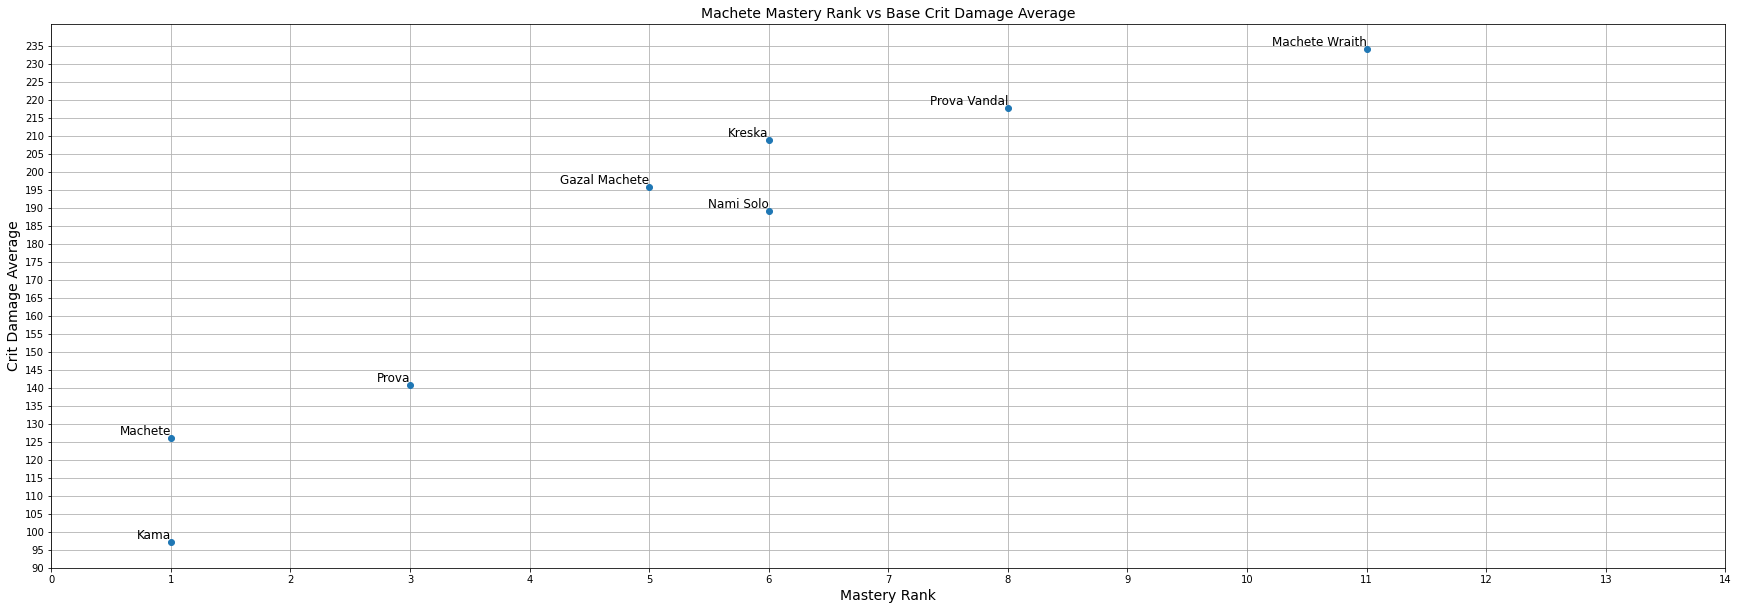

In [52]:
plt.figure(figsize=(30, 10))
ax = MacheteDF.set_index('Mastery_Rank')['AverageCritDamage'].plot(style='o')

label_point(MacheteDF.Mastery_Rank, MacheteDF.AverageCritDamage, MacheteDF.Name, ax)
plt.xticks(np.arange(0, 15, 1))
plt.yticks(np.arange(90, 240, 5.0))
plt.title("Machete Mastery Rank vs Base Crit Damage Average", fontsize = 14)
plt.xlabel("Mastery Rank", fontsize = 14)
plt.ylabel("Crit Damage Average", fontsize = 14)
plt.grid()
plt.show()

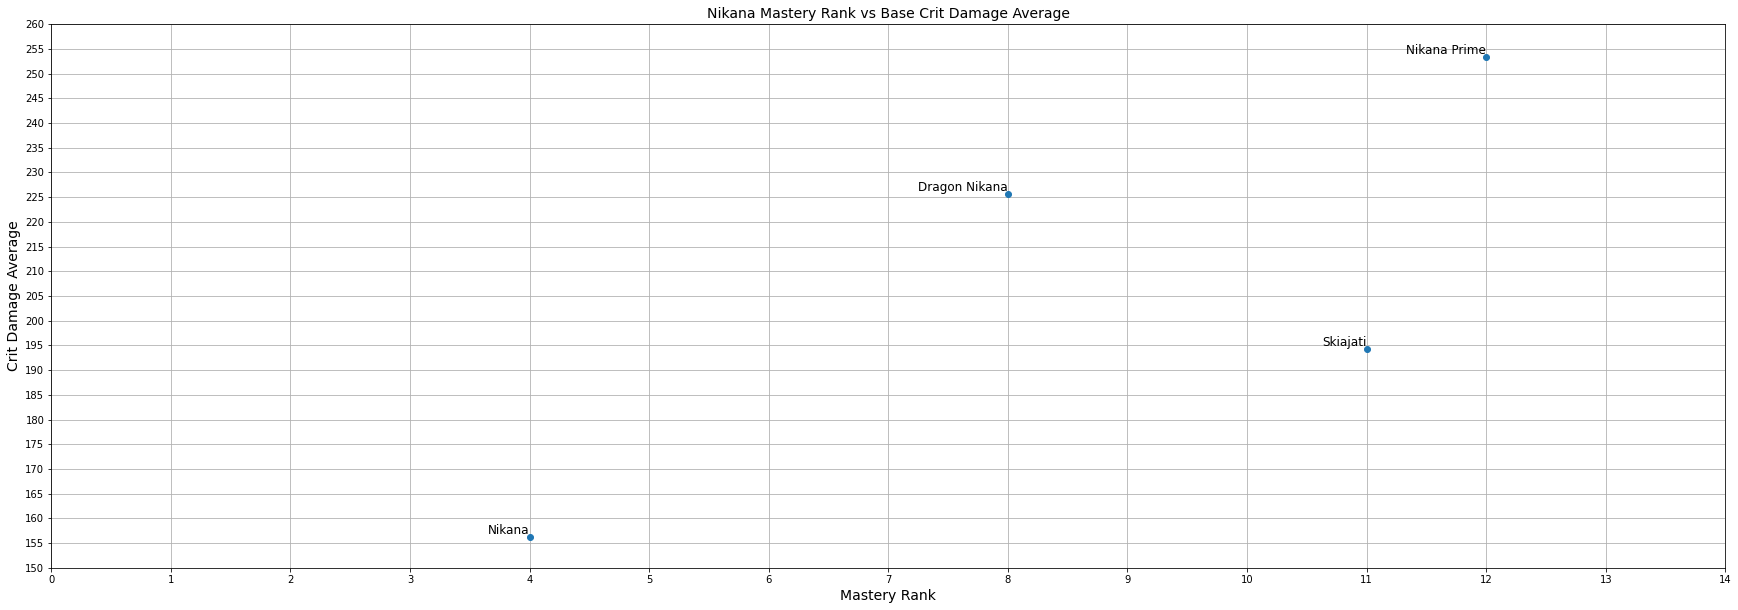

In [53]:
plt.figure(figsize=(30, 10))
ax = NikanaDF.set_index('Mastery_Rank')['AverageCritDamage'].plot(style='o')

label_point(NikanaDF.Mastery_Rank, NikanaDF.AverageCritDamage, NikanaDF.Name, ax)
plt.xticks(np.arange(0, 15, 1))
plt.yticks(np.arange(150, 265, 5.0))
plt.title("Nikana Mastery Rank vs Base Crit Damage Average", fontsize = 14)
plt.xlabel("Mastery Rank", fontsize = 14)
plt.ylabel("Crit Damage Average", fontsize = 14)
plt.grid()
plt.show()

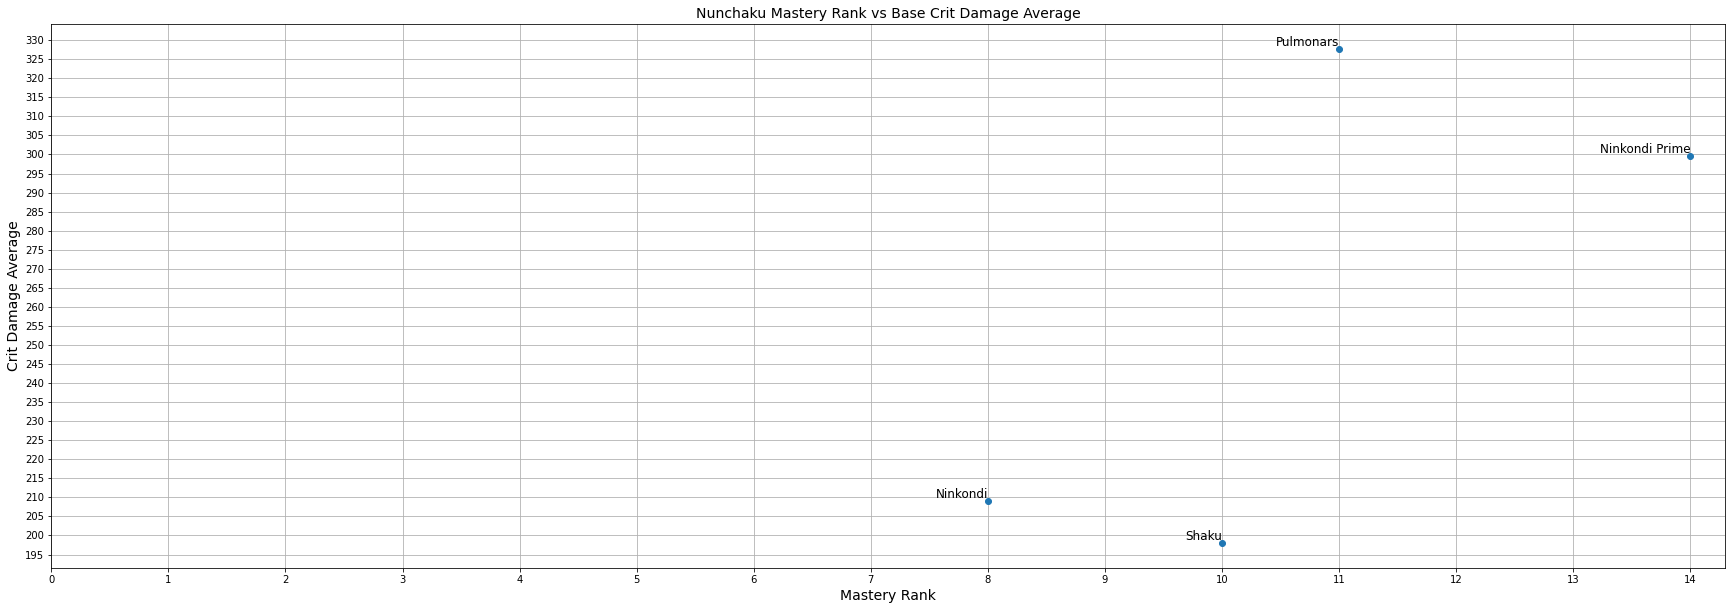

In [54]:
plt.figure(figsize=(30, 10))
ax = NunchakuDF.set_index('Mastery_Rank')['AverageCritDamage'].plot(style='o')

label_point(NunchakuDF.Mastery_Rank, NunchakuDF.AverageCritDamage, NunchakuDF.Name, ax)
plt.xticks(np.arange(0, 15, 1))
plt.yticks(np.arange(195, 335, 5.0))
plt.title("Nunchaku Mastery Rank vs Base Crit Damage Average", fontsize = 14)
plt.xlabel("Mastery Rank", fontsize = 14)
plt.ylabel("Crit Damage Average", fontsize = 14)
plt.grid()
plt.show()

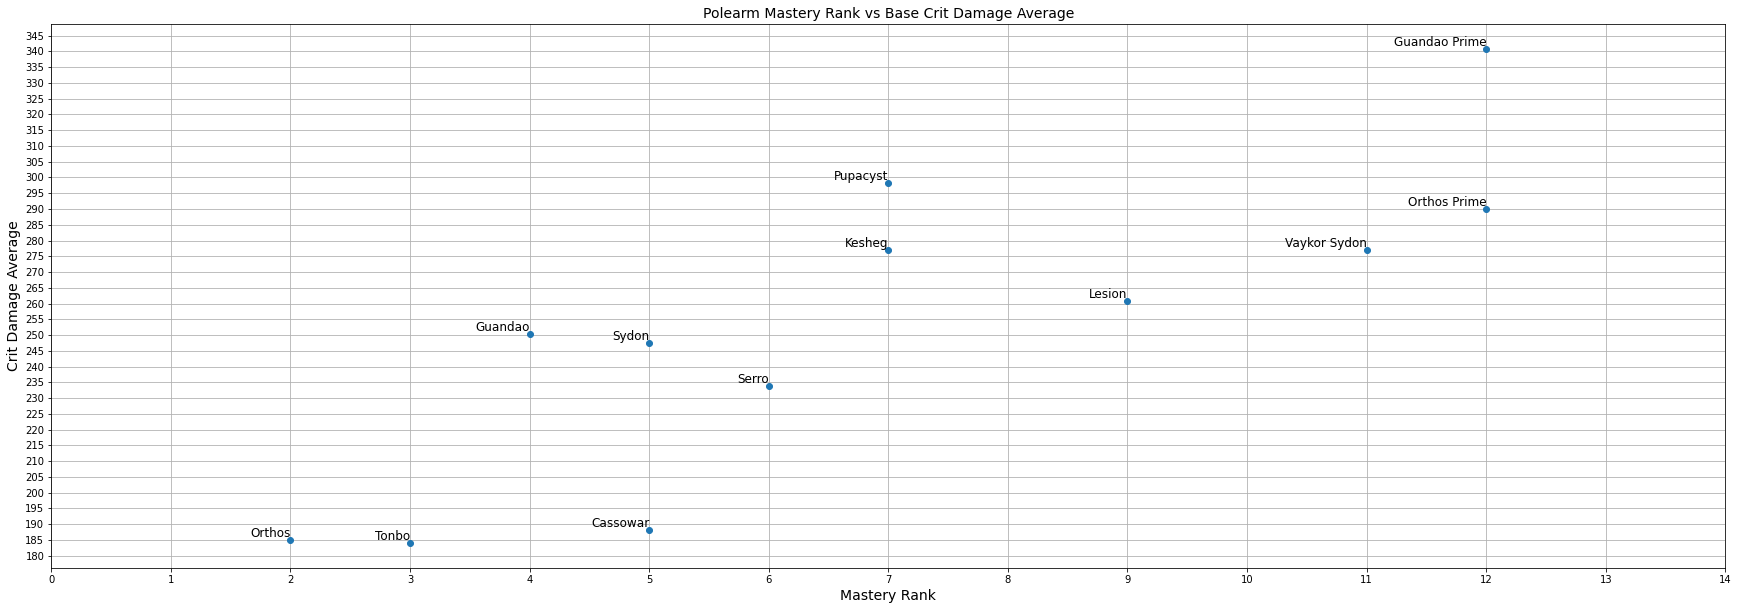

In [55]:
plt.figure(figsize=(30, 10))
ax = PolearmDF.set_index('Mastery_Rank')['AverageCritDamage'].plot(style='o')

label_point(PolearmDF.Mastery_Rank, PolearmDF.AverageCritDamage, PolearmDF.Name, ax)
plt.xticks(np.arange(0, 15, 1))
plt.yticks(np.arange(180, 350, 5.0))
plt.title("Polearm Mastery Rank vs Base Crit Damage Average", fontsize = 14)
plt.xlabel("Mastery Rank", fontsize = 14)
plt.ylabel("Crit Damage Average", fontsize = 14)
plt.grid()
plt.show()

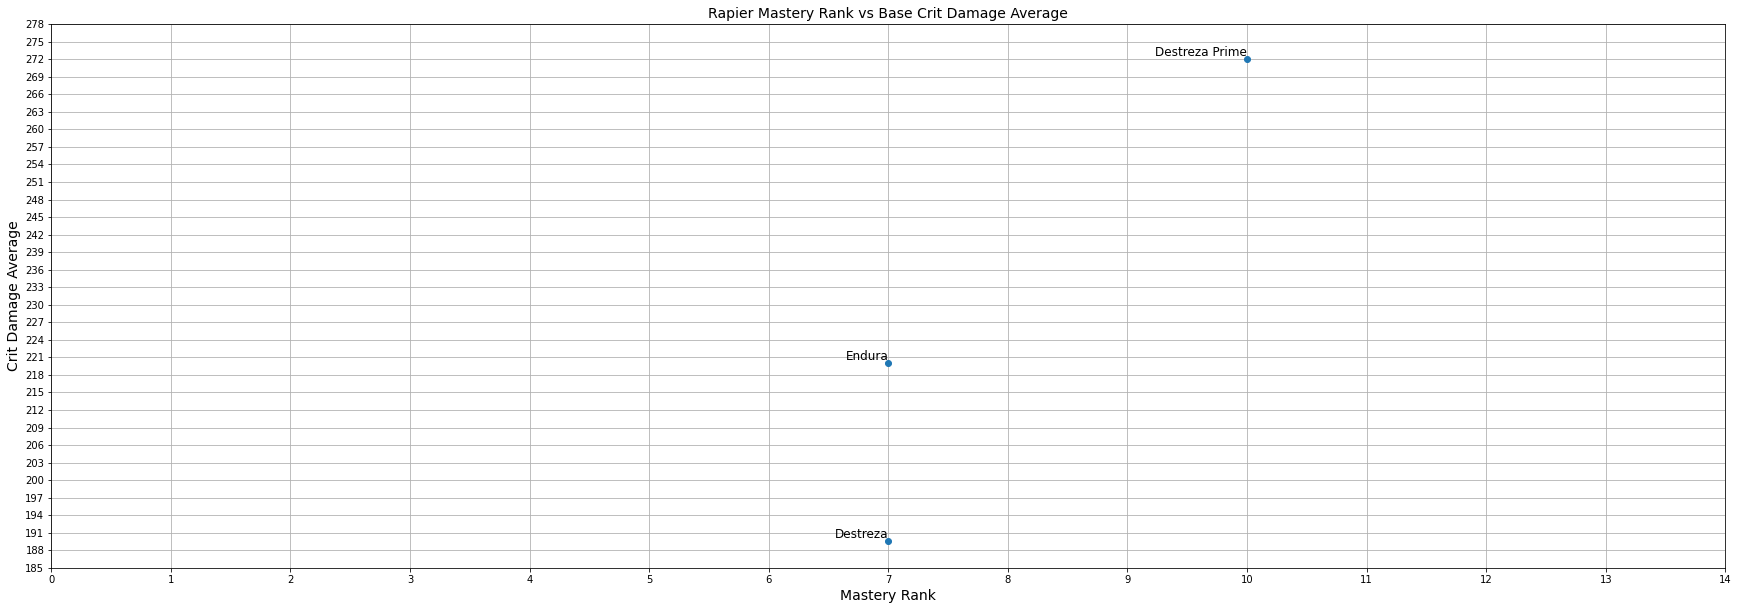

In [56]:
plt.figure(figsize=(30, 10))
ax = RapierDF.set_index('Mastery_Rank')['AverageCritDamage'].plot(style='o')

label_point(RapierDF.Mastery_Rank, RapierDF.AverageCritDamage, RapierDF.Name, ax)
plt.xticks(np.arange(0, 15, 1))
plt.yticks(np.arange(185, 280, 3.0))
plt.title("Rapier Mastery Rank vs Base Crit Damage Average", fontsize = 14)
plt.xlabel("Mastery Rank", fontsize = 14)
plt.ylabel("Crit Damage Average", fontsize = 14)
plt.grid()
plt.show()

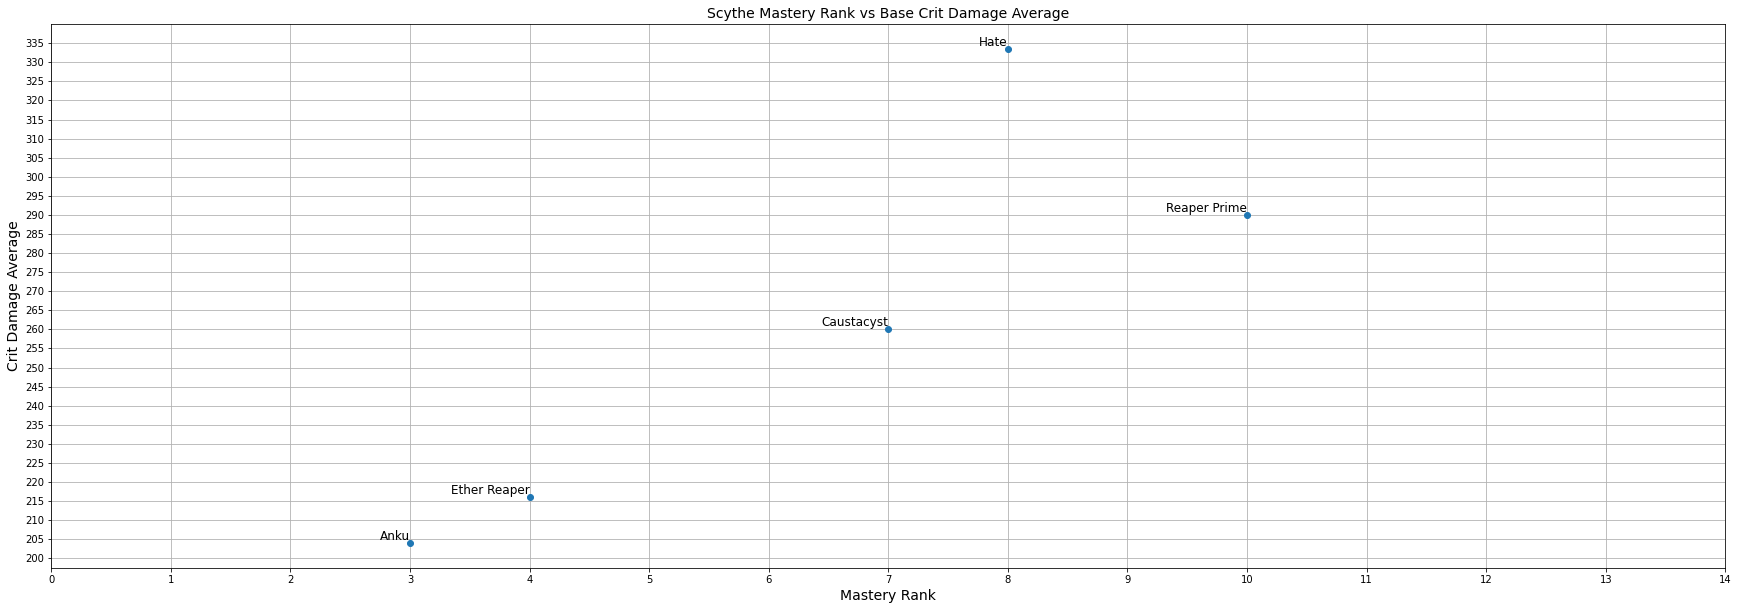

In [57]:
plt.figure(figsize=(30, 10))
ax = ScytheDF.set_index('Mastery_Rank')['AverageCritDamage'].plot(style='o')

label_point(ScytheDF.Mastery_Rank, ScytheDF.AverageCritDamage, ScytheDF.Name, ax)
plt.xticks(np.arange(0, 15, 1))
plt.yticks(np.arange(200, 340, 5.0))
plt.title("Scythe Mastery Rank vs Base Crit Damage Average", fontsize = 14)
plt.xlabel("Mastery Rank", fontsize = 14)
plt.ylabel("Crit Damage Average", fontsize = 14)
plt.grid()
plt.show()

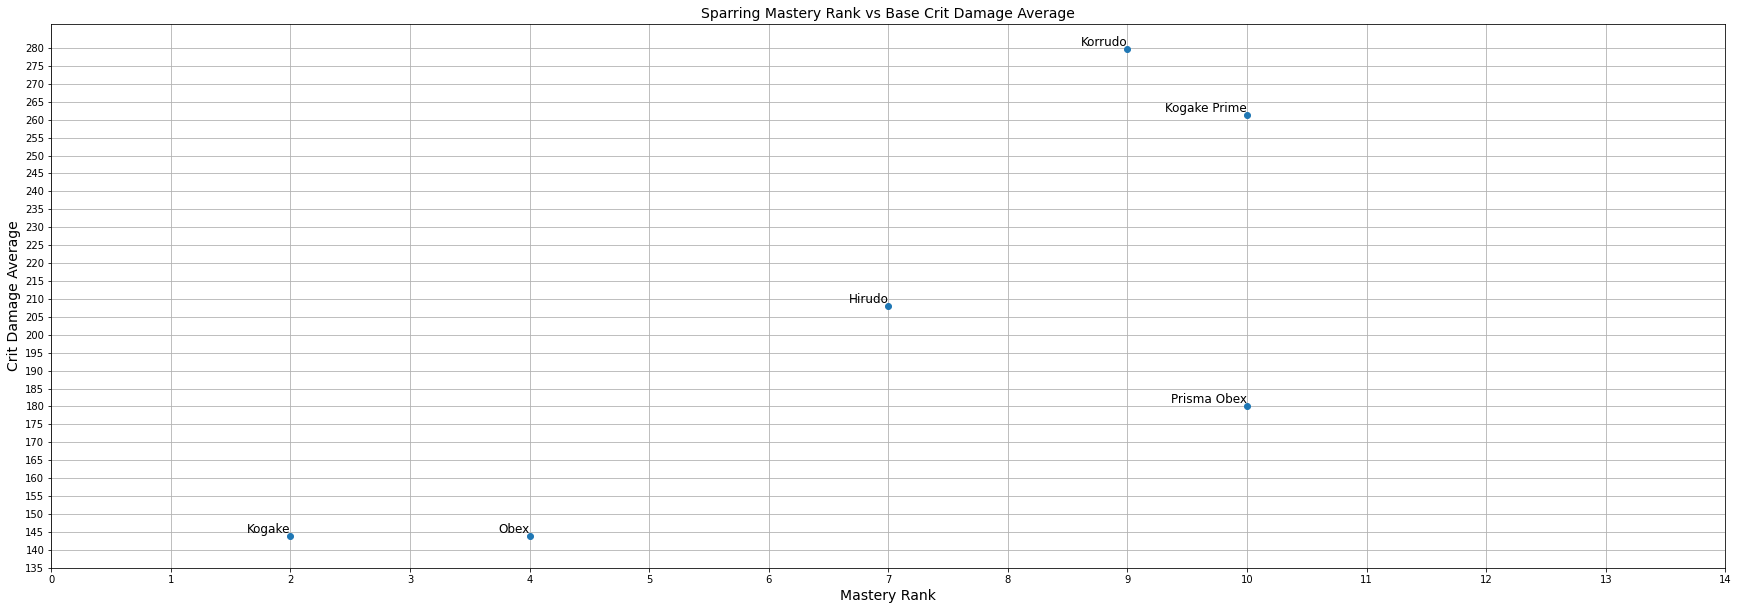

In [58]:
plt.figure(figsize=(30, 10))
ax = SparringDF.set_index('Mastery_Rank')['AverageCritDamage'].plot(style='o')

label_point(SparringDF.Mastery_Rank, SparringDF.AverageCritDamage, SparringDF.Name, ax)
plt.xticks(np.arange(0, 15, 1))
plt.yticks(np.arange(135, 285, 5.0))
plt.title("Sparring Mastery Rank vs Base Crit Damage Average", fontsize = 14)
plt.xlabel("Mastery Rank", fontsize = 14)
plt.ylabel("Crit Damage Average", fontsize = 14)
plt.grid()
plt.show()

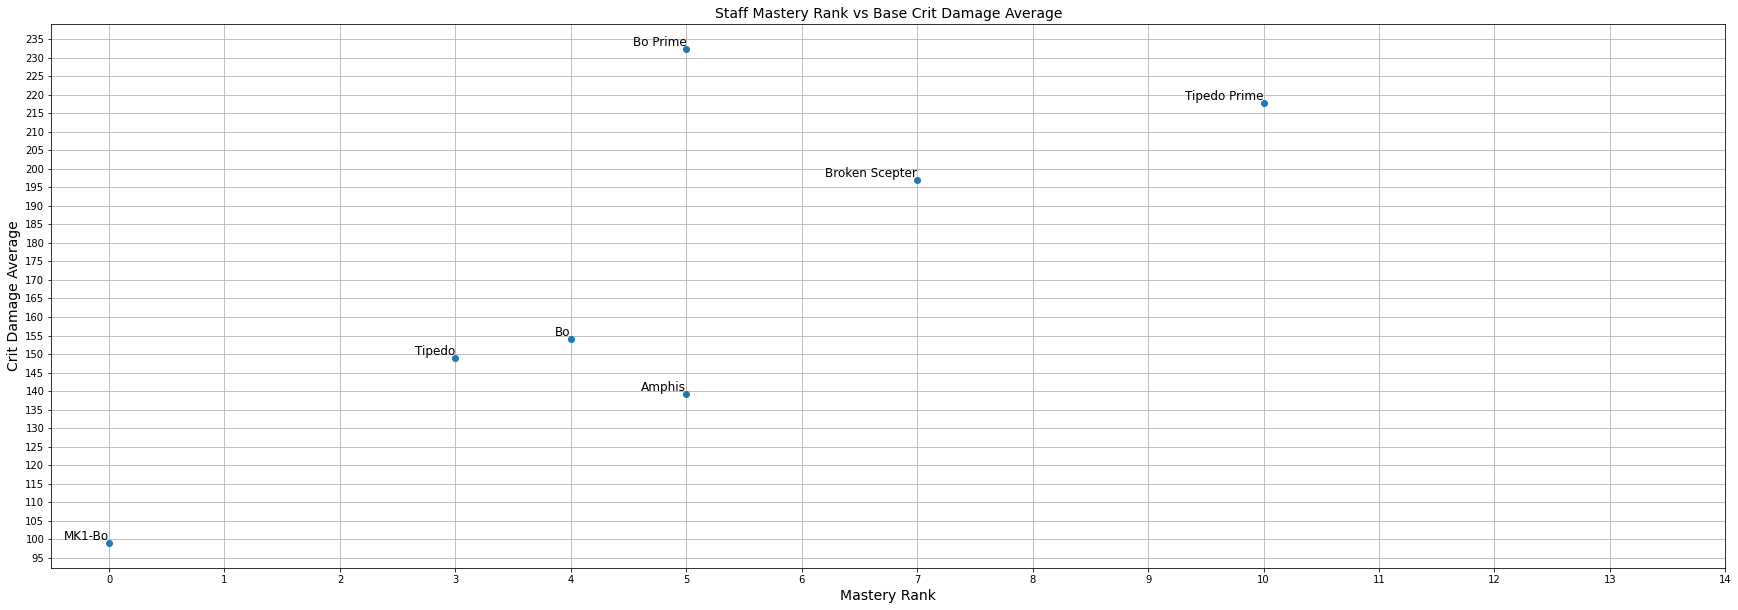

In [59]:
plt.figure(figsize=(30, 10))
ax = StaffDF.set_index('Mastery_Rank')['AverageCritDamage'].plot(style='o')

label_point(StaffDF.Mastery_Rank, StaffDF.AverageCritDamage, StaffDF.Name, ax)
plt.xticks(np.arange(0, 15, 1))
plt.yticks(np.arange(95, 240, 5.0))
plt.title("Staff Mastery Rank vs Base Crit Damage Average", fontsize = 14)
plt.xlabel("Mastery Rank", fontsize = 14)
plt.ylabel("Crit Damage Average", fontsize = 14)
plt.grid()
plt.show()

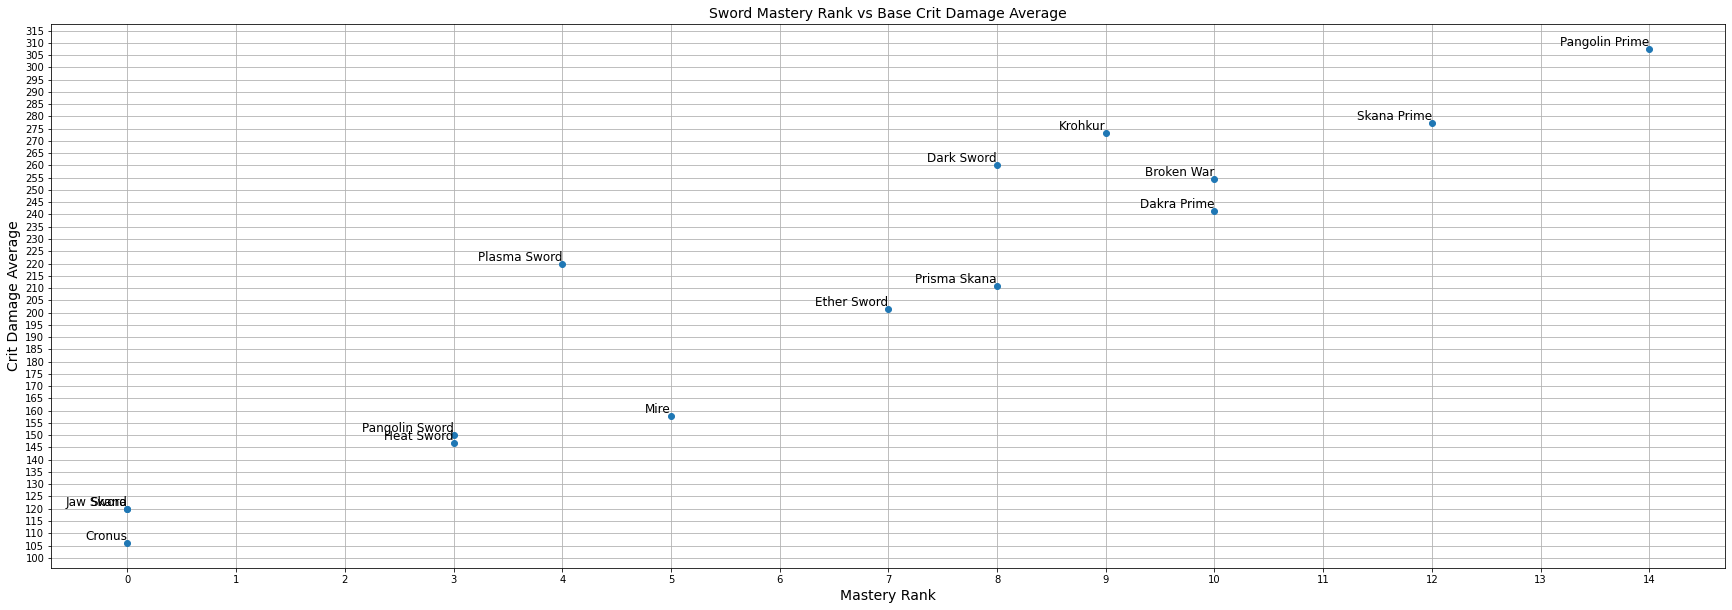

In [60]:
plt.figure(figsize=(30, 10))
ax = SwordDF.set_index('Mastery_Rank')['AverageCritDamage'].plot(style='o')

label_point(SwordDF.Mastery_Rank, SwordDF.AverageCritDamage, SwordDF.Name, ax)
plt.xticks(np.arange(0, 15, 1))
plt.yticks(np.arange(100, 320, 5.0))
plt.title("Sword Mastery Rank vs Base Crit Damage Average", fontsize = 14)
plt.xlabel("Mastery Rank", fontsize = 14)
plt.ylabel("Crit Damage Average", fontsize = 14)
plt.grid()
plt.show()

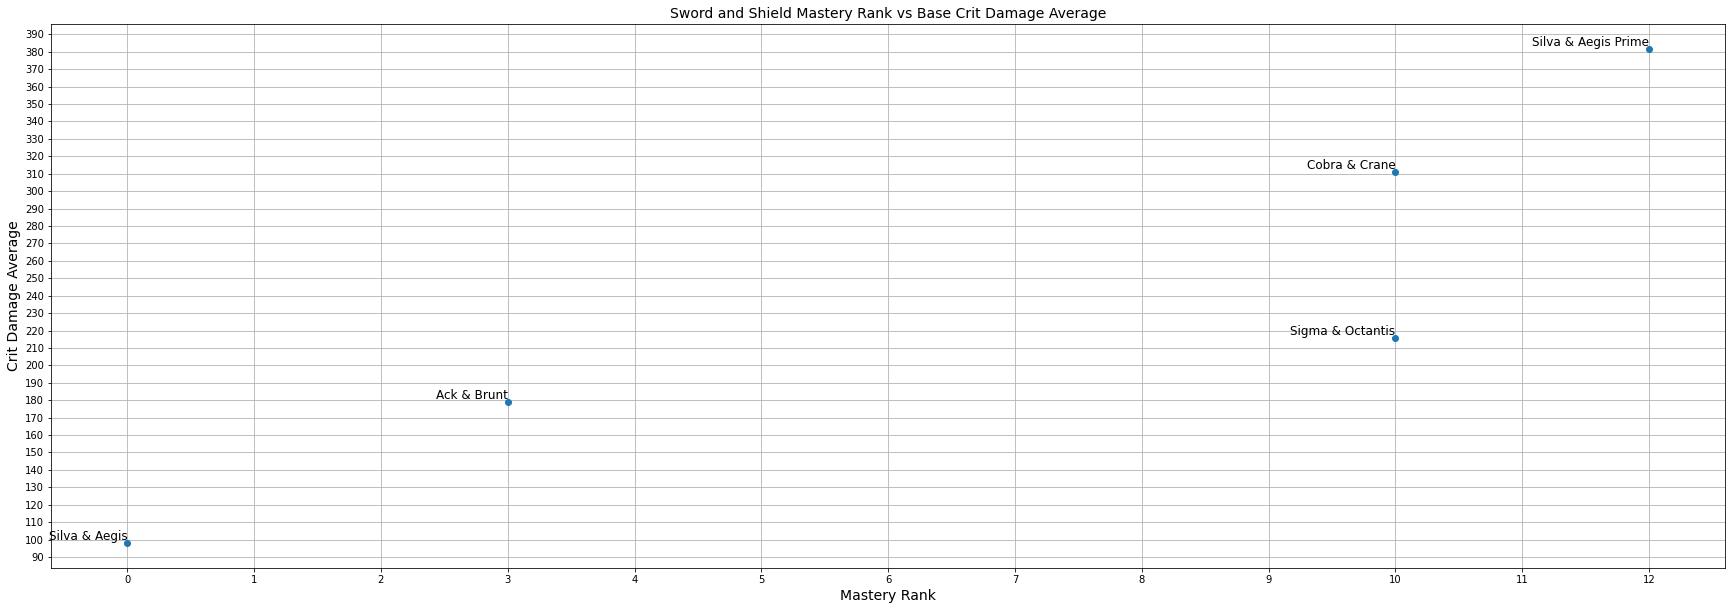

In [61]:
plt.figure(figsize=(30, 10))
ax = SWSHDF.set_index('Mastery_Rank')['AverageCritDamage'].plot(style='o')

label_point(SWSHDF.Mastery_Rank, SWSHDF.AverageCritDamage, SWSHDF.Name, ax)
plt.xticks(np.arange(0, 13, 1))
plt.yticks(np.arange(90, 400, 10.0))
plt.title("Sword and Shield Mastery Rank vs Base Crit Damage Average", fontsize = 14)
plt.xlabel("Mastery Rank", fontsize = 14)
plt.ylabel("Crit Damage Average", fontsize = 14)
plt.grid()
plt.show()

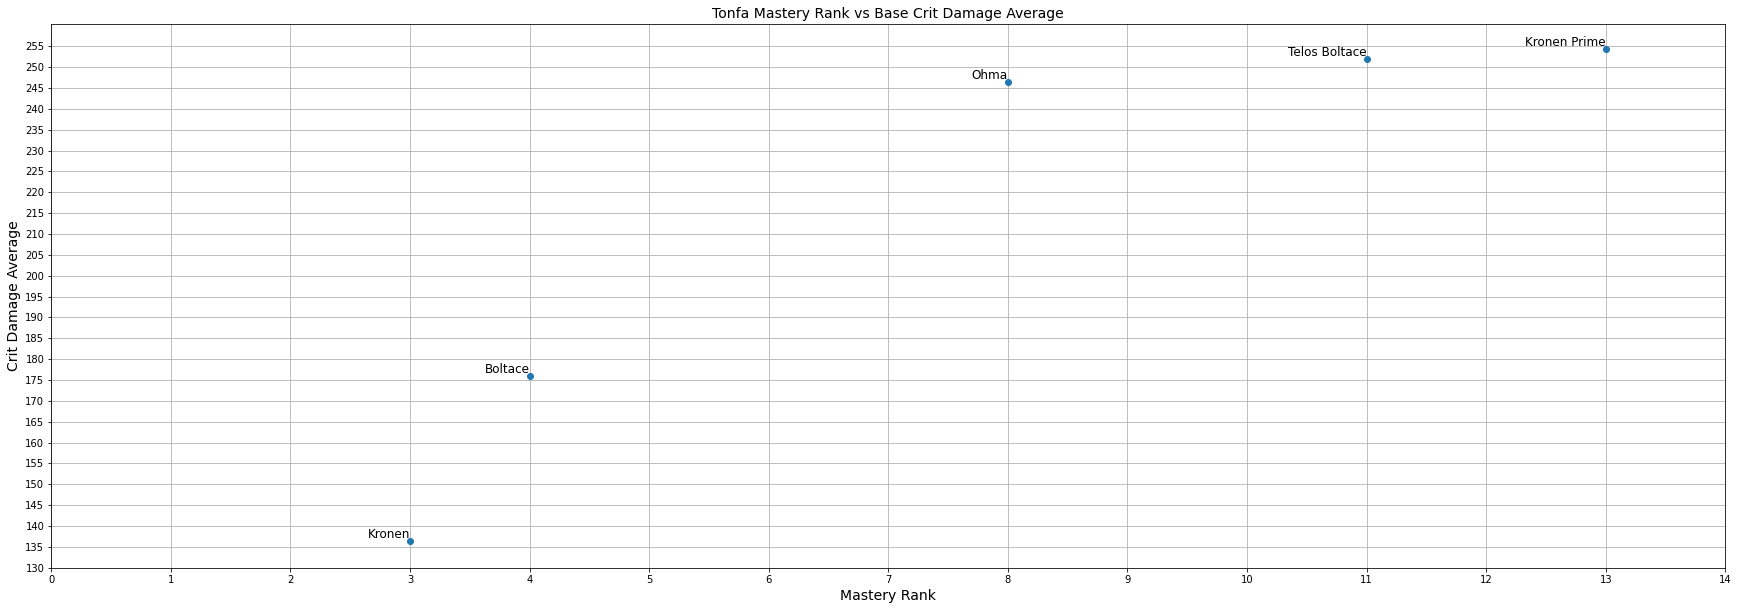

In [62]:
plt.figure(figsize=(30, 10))
ax = TonfaDF.set_index('Mastery_Rank')['AverageCritDamage'].plot(style='o')

label_point(TonfaDF.Mastery_Rank, TonfaDF.AverageCritDamage, TonfaDF.Name, ax)
plt.xticks(np.arange(0, 15, 1))
plt.yticks(np.arange(130, 260, 5.0))
plt.title("Tonfa Mastery Rank vs Base Crit Damage Average", fontsize = 14)
plt.xlabel("Mastery Rank", fontsize = 14)
plt.ylabel("Crit Damage Average", fontsize = 14)
plt.grid()
plt.show()

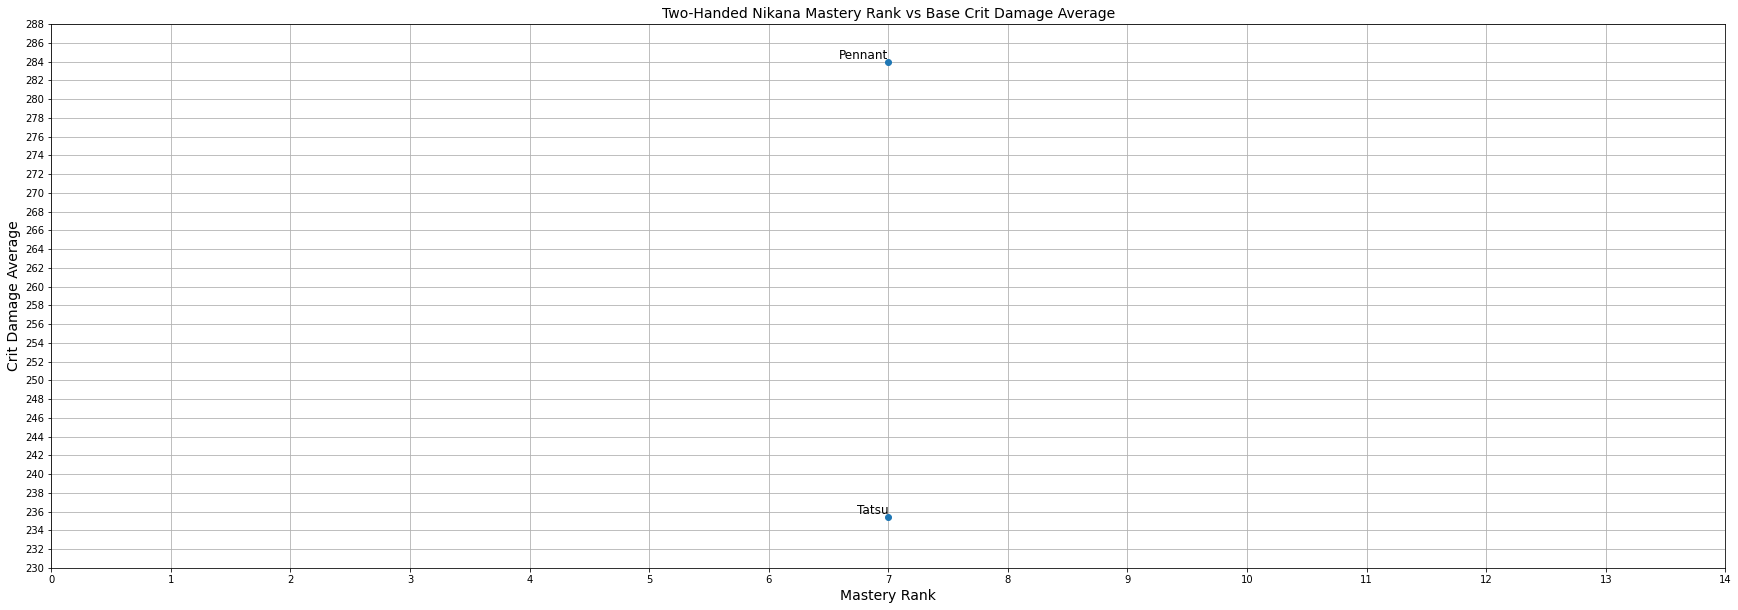

In [63]:
plt.figure(figsize=(30, 10))
ax = HeavyNikDF.set_index('Mastery_Rank')['AverageCritDamage'].plot(style='o')

label_point(HeavyNikDF.Mastery_Rank, HeavyNikDF.AverageCritDamage, HeavyNikDF.Name, ax)
plt.xticks(np.arange(0, 15, 1))
plt.yticks(np.arange(230, 290, 2.0))
plt.title("Two-Handed Nikana Mastery Rank vs Base Crit Damage Average", fontsize = 14)
plt.xlabel("Mastery Rank", fontsize = 14)
plt.ylabel("Crit Damage Average", fontsize = 14)
plt.grid()
plt.show()

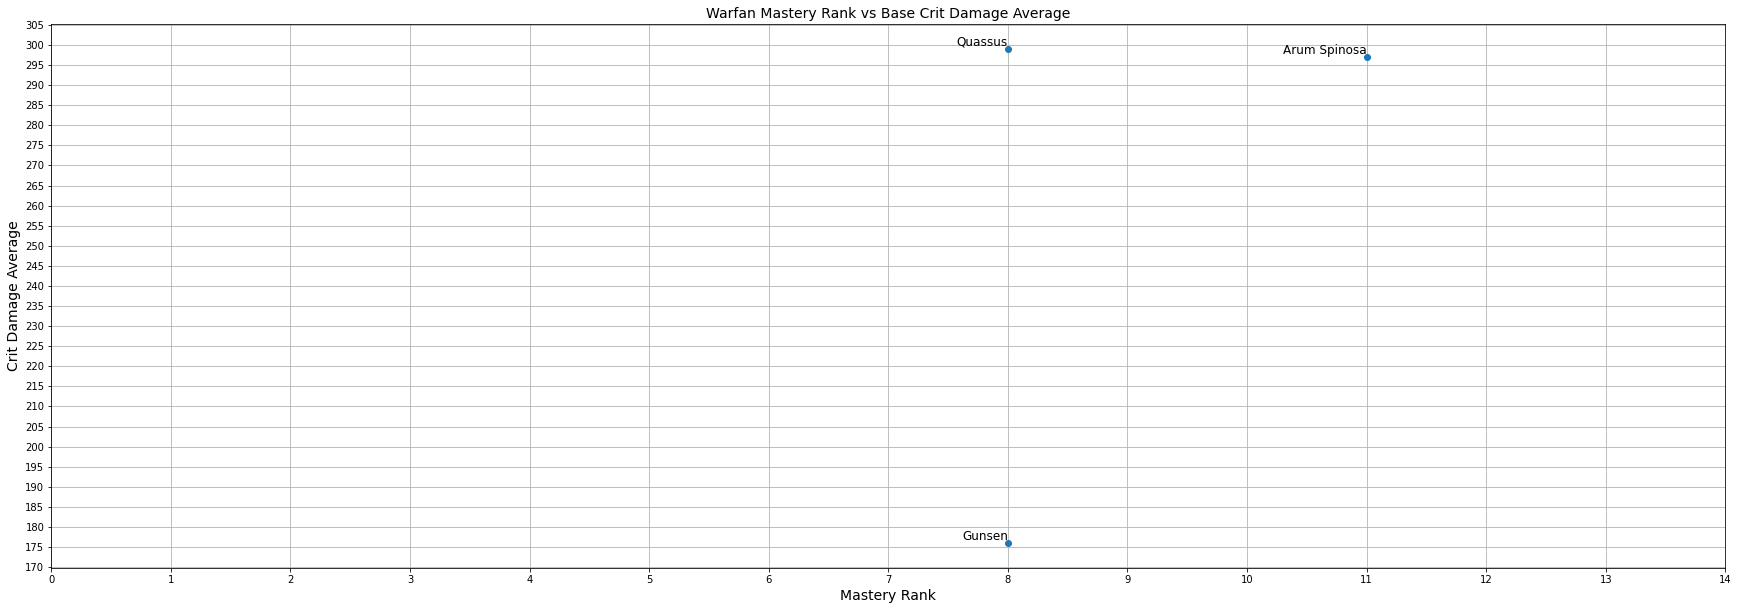

In [64]:
plt.figure(figsize=(30, 10))
ax = FanDF.set_index('Mastery_Rank')['AverageCritDamage'].plot(style='o')

label_point(FanDF.Mastery_Rank, FanDF.AverageCritDamage, FanDF.Name, ax)
plt.xticks(np.arange(0, 15, 1))
plt.yticks(np.arange(170, 310, 5.0))
plt.title("Warfan Mastery Rank vs Base Crit Damage Average", fontsize = 14)
plt.xlabel("Mastery Rank", fontsize = 14)
plt.ylabel("Crit Damage Average", fontsize = 14)
plt.grid()
plt.show()

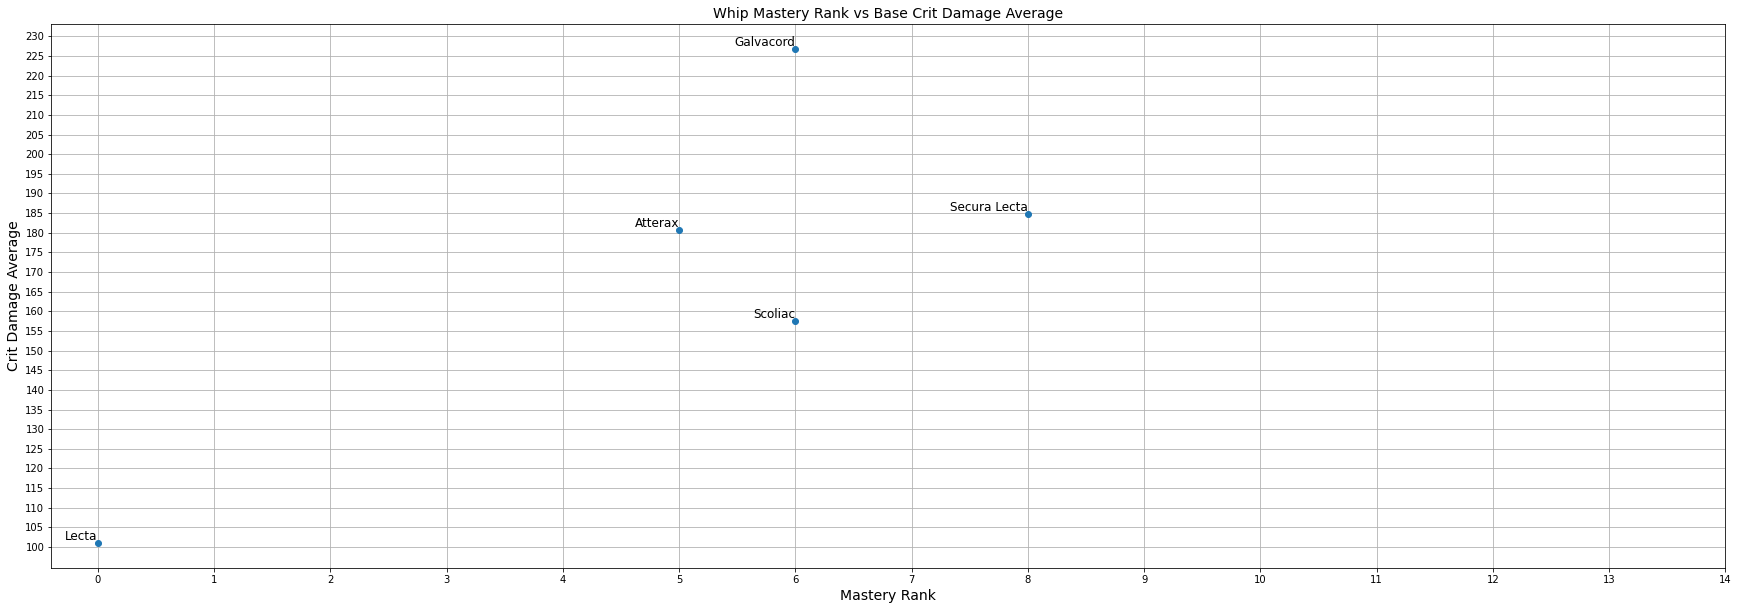

In [65]:
plt.figure(figsize=(30, 10))
ax = WhipDF.set_index('Mastery_Rank')['AverageCritDamage'].plot(style='o')

label_point(WhipDF.Mastery_Rank, WhipDF.AverageCritDamage, WhipDF.Name, ax)
plt.xticks(np.arange(0, 15, 1))
plt.yticks(np.arange(100, 235, 5.0))
plt.title("Whip Mastery Rank vs Base Crit Damage Average", fontsize = 14)
plt.xlabel("Mastery Rank", fontsize = 14)
plt.ylabel("Crit Damage Average", fontsize = 14)
plt.grid()
plt.show()

# Task 7 Blood Rush Damage before and after the Nerf

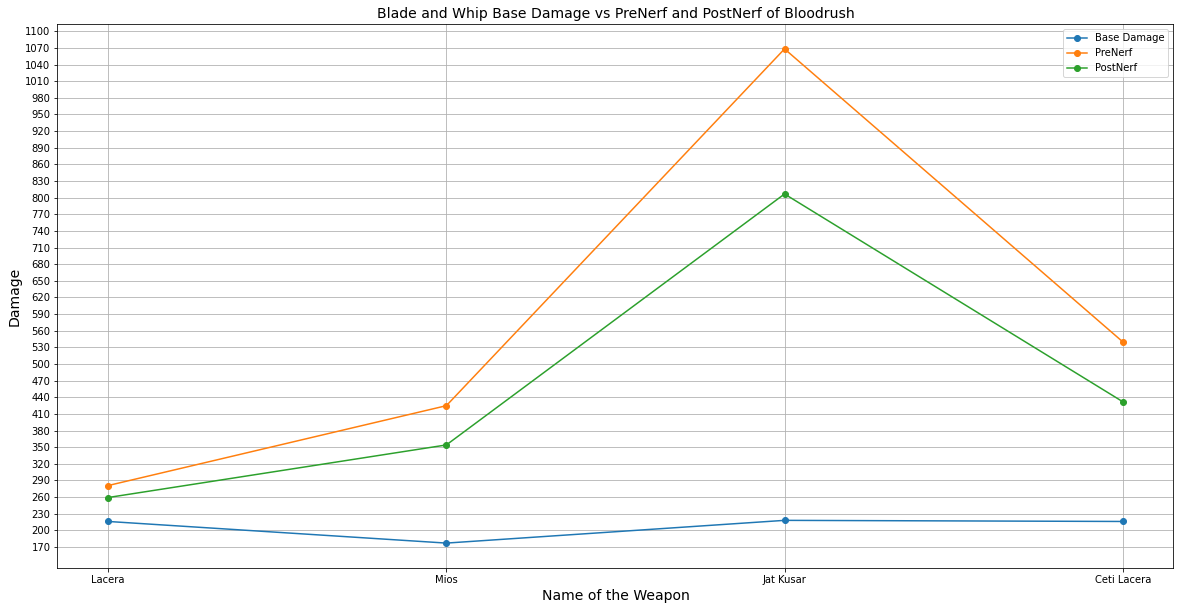

In [66]:
plt.figure(figsize=(20, 10))
plt.plot(BLWPDF['Name'], BLWPDF['Total_Damage'], label="Base Damage", marker='o')
plt.plot(BLWPDF['Name'], BLWPDF['PreNerfDamage'], label="PreNerf", marker='o')
plt.plot(BLWPDF['Name'], BLWPDF['PostNerfDamage'], label="PostNerf", marker='o')

plt.yticks(np.arange(170, 1120, 30.0))
plt.title("Blade and Whip Base Damage vs PreNerf and PostNerf of Bloodrush", fontsize = 14)
plt.xlabel("Name of the Weapon", fontsize = 14)
plt.ylabel("Damage", fontsize = 14)
plt.legend()
plt.grid()
plt.show()

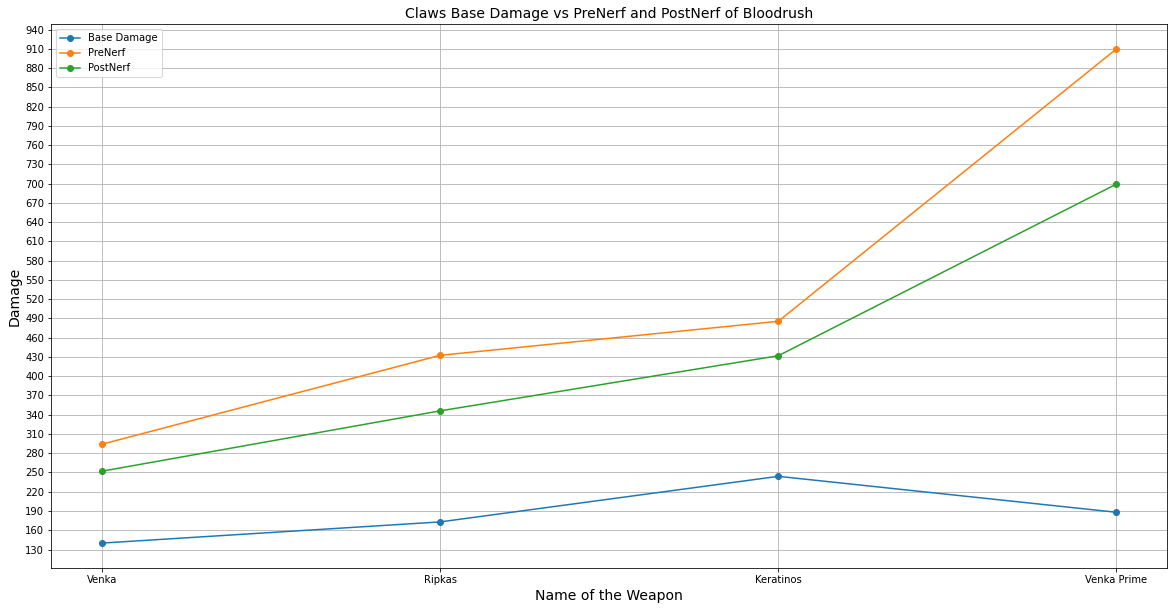

In [67]:
plt.figure(figsize=(20, 10))
plt.plot(ClawDF['Name'], ClawDF['Total_Damage'], label="Base Damage", marker='o')
plt.plot(ClawDF['Name'], ClawDF['PreNerfDamage'], label="PreNerf", marker='o')
plt.plot(ClawDF['Name'], ClawDF['PostNerfDamage'], label="PostNerf", marker='o')

plt.yticks(np.arange(130, 950, 30.0))
plt.title("Claws Base Damage vs PreNerf and PostNerf of Bloodrush", fontsize = 14)
plt.xlabel("Name of the Weapon", fontsize = 14)
plt.ylabel("Damage", fontsize = 14)
plt.legend()
plt.grid()
plt.show()

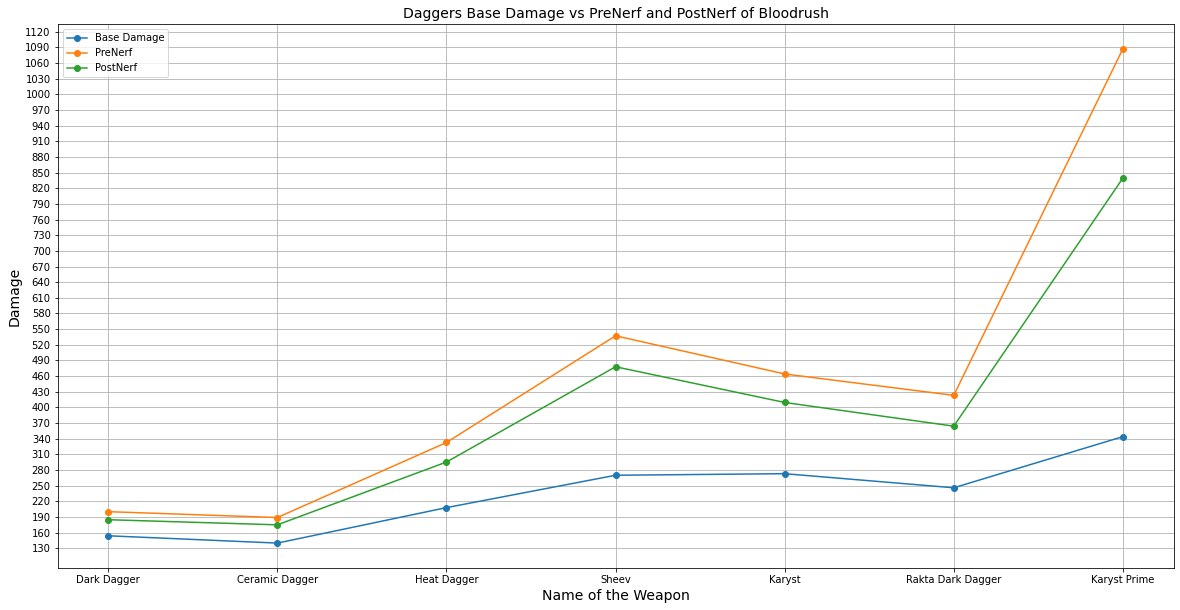

In [68]:
plt.figure(figsize=(20, 10))
plt.plot(DaggerDF['Name'], DaggerDF['Total_Damage'], label="Base Damage", marker='o')
plt.plot(DaggerDF['Name'], DaggerDF['PreNerfDamage'], label="PreNerf", marker='o')
plt.plot(DaggerDF['Name'], DaggerDF['PostNerfDamage'], label="PostNerf", marker='o')

plt.yticks(np.arange(130, 1150, 30.0))
plt.title("Daggers Base Damage vs PreNerf and PostNerf of Bloodrush", fontsize = 14)
plt.xlabel("Name of the Weapon", fontsize = 14)
plt.ylabel("Damage", fontsize = 14)
plt.legend()
plt.grid()
plt.show()

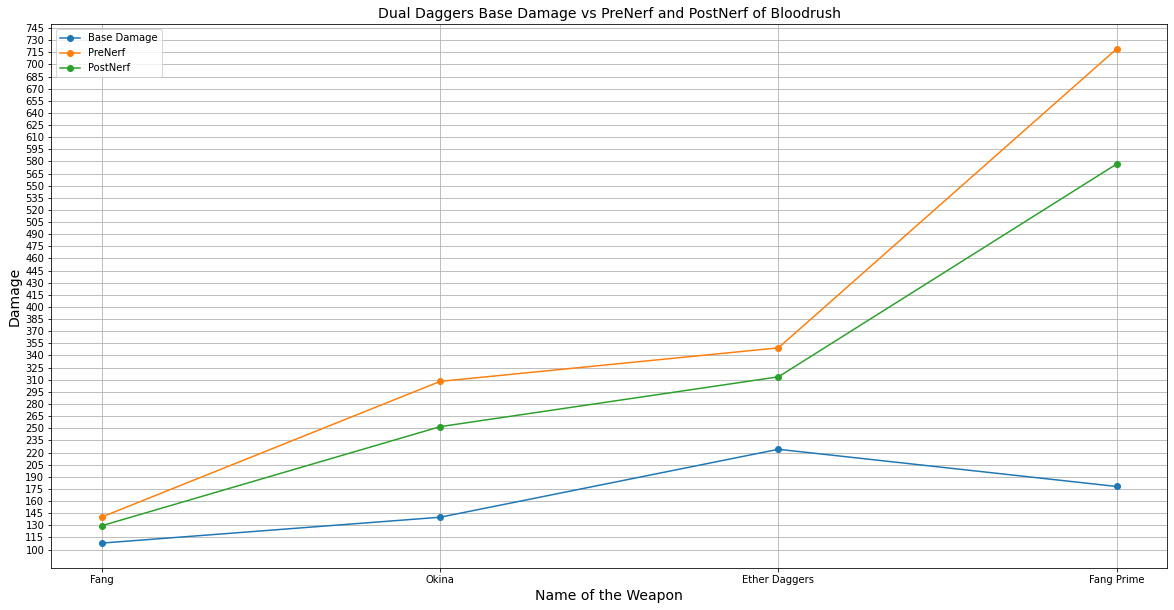

In [69]:
plt.figure(figsize=(20, 10))
plt.plot(DDaggerDF['Name'], DDaggerDF['Total_Damage'], label="Base Damage", marker='o')
plt.plot(DDaggerDF['Name'], DDaggerDF['PreNerfDamage'], label="PreNerf", marker='o')
plt.plot(DDaggerDF['Name'], DDaggerDF['PostNerfDamage'], label="PostNerf", marker='o')

plt.yticks(np.arange(100, 750, 15.0))
plt.title("Dual Daggers Base Damage vs PreNerf and PostNerf of Bloodrush", fontsize = 14)
plt.xlabel("Name of the Weapon", fontsize = 14)
plt.ylabel("Damage", fontsize = 14)
plt.legend()
plt.grid()
plt.show()

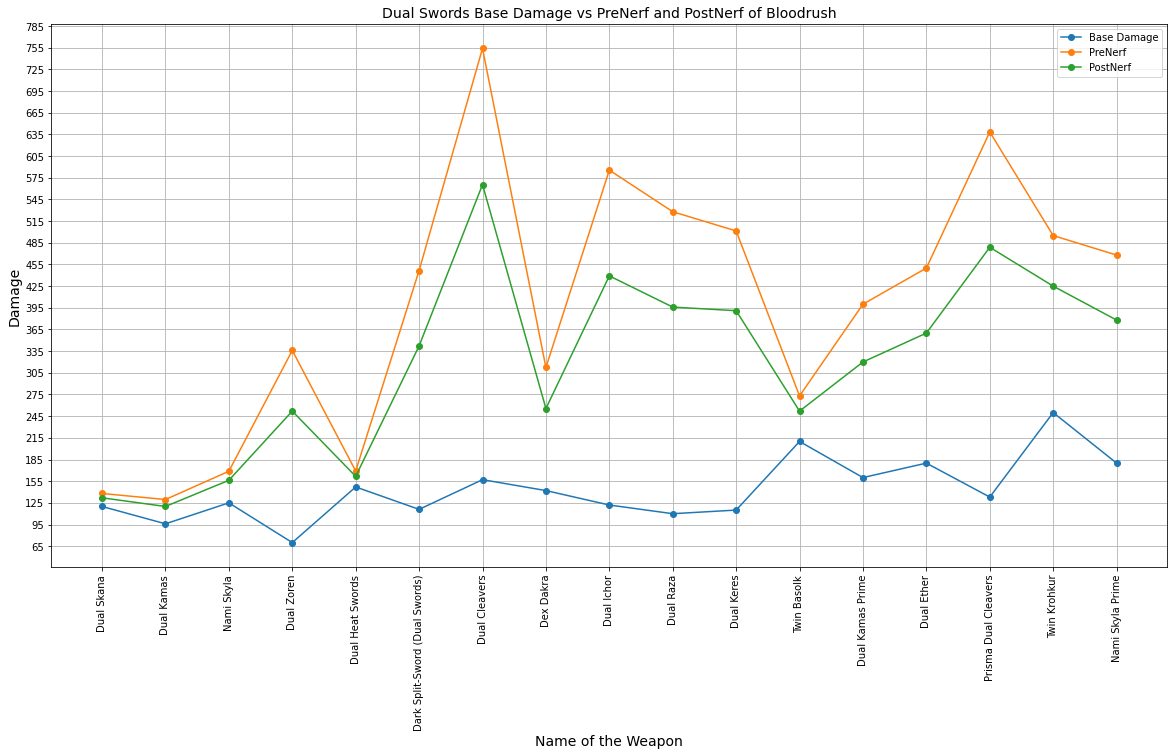

In [70]:
plt.figure(figsize=(20, 10))
plt.plot(DualDF['Name'], DualDF['Total_Damage'], label="Base Damage", marker='o')
plt.plot(DualDF['Name'], DualDF['PreNerfDamage'], label="PreNerf", marker='o')
plt.plot(DualDF['Name'], DualDF['PostNerfDamage'], label="PostNerf", marker='o')

plt.xticks(rotation = 90)
plt.yticks(np.arange(65, 790, 30.0))
plt.title("Dual Swords Base Damage vs PreNerf and PostNerf of Bloodrush", fontsize = 14)
plt.xlabel("Name of the Weapon", fontsize = 14)
plt.ylabel("Damage", fontsize = 14)
plt.legend()
plt.grid()
plt.show()

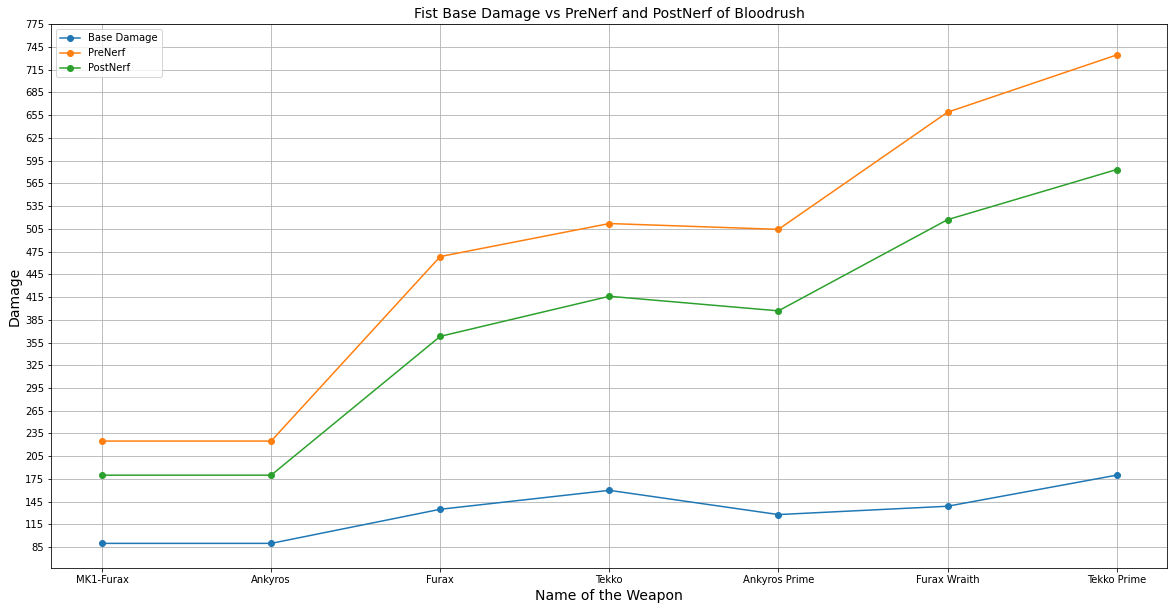

In [71]:
plt.figure(figsize=(20, 10))
plt.plot(FistDF['Name'], FistDF['Total_Damage'], label="Base Damage", marker='o')
plt.plot(FistDF['Name'], FistDF['PreNerfDamage'], label="PreNerf", marker='o')
plt.plot(FistDF['Name'], FistDF['PostNerfDamage'], label="PostNerf", marker='o')

plt.yticks(np.arange(85, 790, 30.0))
plt.title("Fist Base Damage vs PreNerf and PostNerf of Bloodrush", fontsize = 14)
plt.xlabel("Name of the Weapon", fontsize = 14)
plt.ylabel("Damage", fontsize = 14)
plt.legend()
plt.grid()
plt.show()

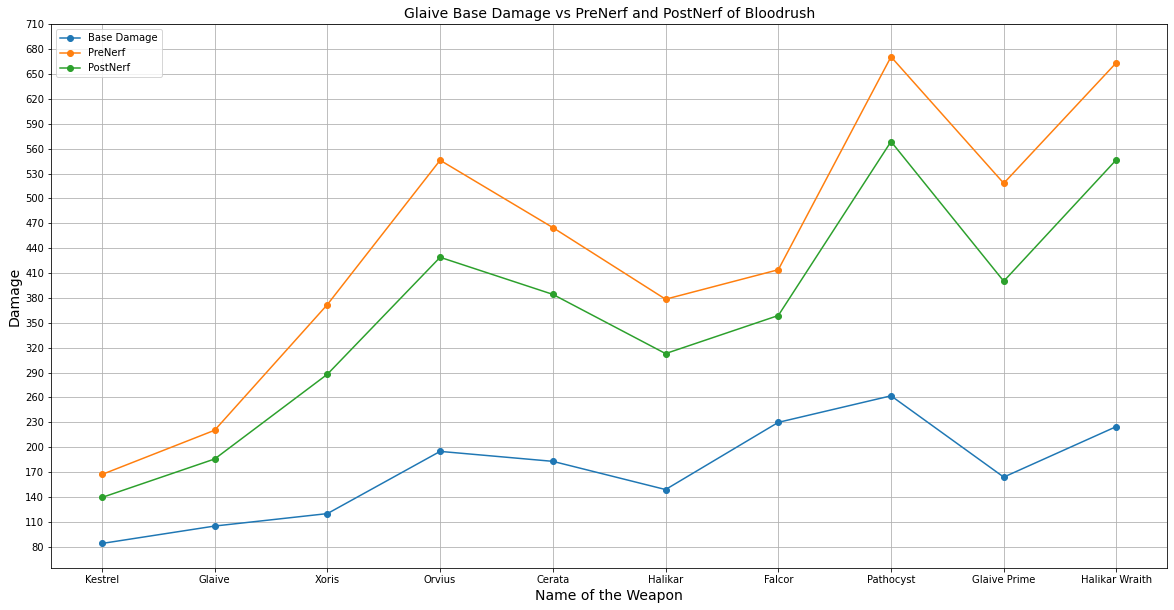

In [72]:
plt.figure(figsize=(20, 10))
plt.plot(GlaiveDF['Name'], GlaiveDF['Total_Damage'], label="Base Damage", marker='o')
plt.plot(GlaiveDF['Name'], GlaiveDF['PreNerfDamage'], label="PreNerf", marker='o')
plt.plot(GlaiveDF['Name'], GlaiveDF['PostNerfDamage'], label="PostNerf", marker='o')

plt.yticks(np.arange(80, 720, 30.0))
plt.title("Glaive Base Damage vs PreNerf and PostNerf of Bloodrush", fontsize = 14)
plt.xlabel("Name of the Weapon", fontsize = 14)
plt.ylabel("Damage", fontsize = 14)
plt.legend()
plt.grid()
plt.show()

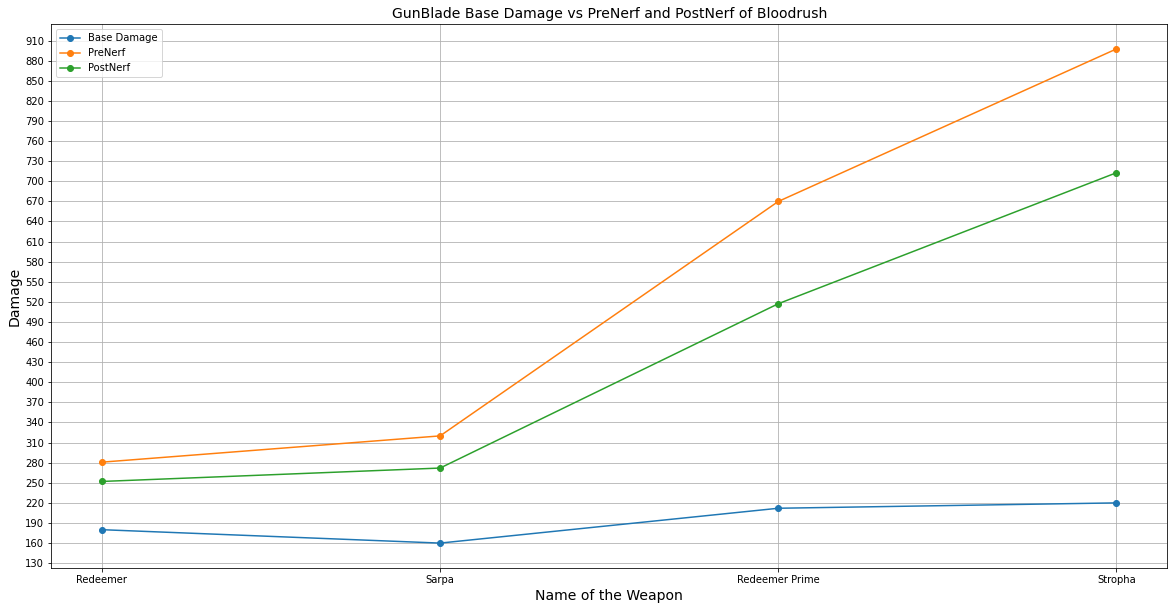

In [73]:
plt.figure(figsize=(20, 10))
plt.plot(GunBladeDF['Name'], GunBladeDF['Total_Damage'], label="Base Damage", marker='o')
plt.plot(GunBladeDF['Name'], GunBladeDF['PreNerfDamage'], label="PreNerf", marker='o')
plt.plot(GunBladeDF['Name'], GunBladeDF['PostNerfDamage'], label="PostNerf", marker='o')

plt.yticks(np.arange(130, 940, 30.0))
plt.title("GunBlade Base Damage vs PreNerf and PostNerf of Bloodrush", fontsize = 14)
plt.xlabel("Name of the Weapon", fontsize = 14)
plt.ylabel("Damage", fontsize = 14)
plt.legend()
plt.grid()
plt.show()

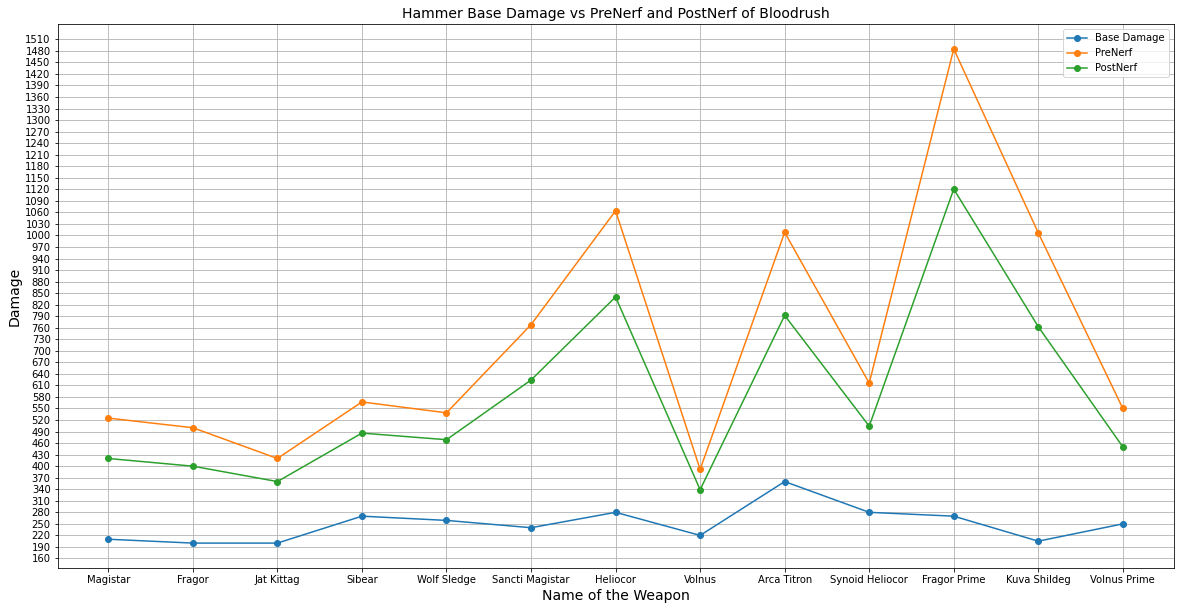

In [74]:
plt.figure(figsize=(20, 10))
plt.plot(HammerDF['Name'], HammerDF['Total_Damage'], label="Base Damage", marker='o')
plt.plot(HammerDF['Name'], HammerDF['PreNerfDamage'], label="PreNerf", marker='o')
plt.plot(HammerDF['Name'], HammerDF['PostNerfDamage'], label="PostNerf", marker='o')

plt.yticks(np.arange(160, 1520, 30.0))
plt.title("Hammer Base Damage vs PreNerf and PostNerf of Bloodrush", fontsize = 14)
plt.xlabel("Name of the Weapon", fontsize = 14)
plt.ylabel("Damage", fontsize = 14)
plt.legend()
plt.grid()
plt.show()

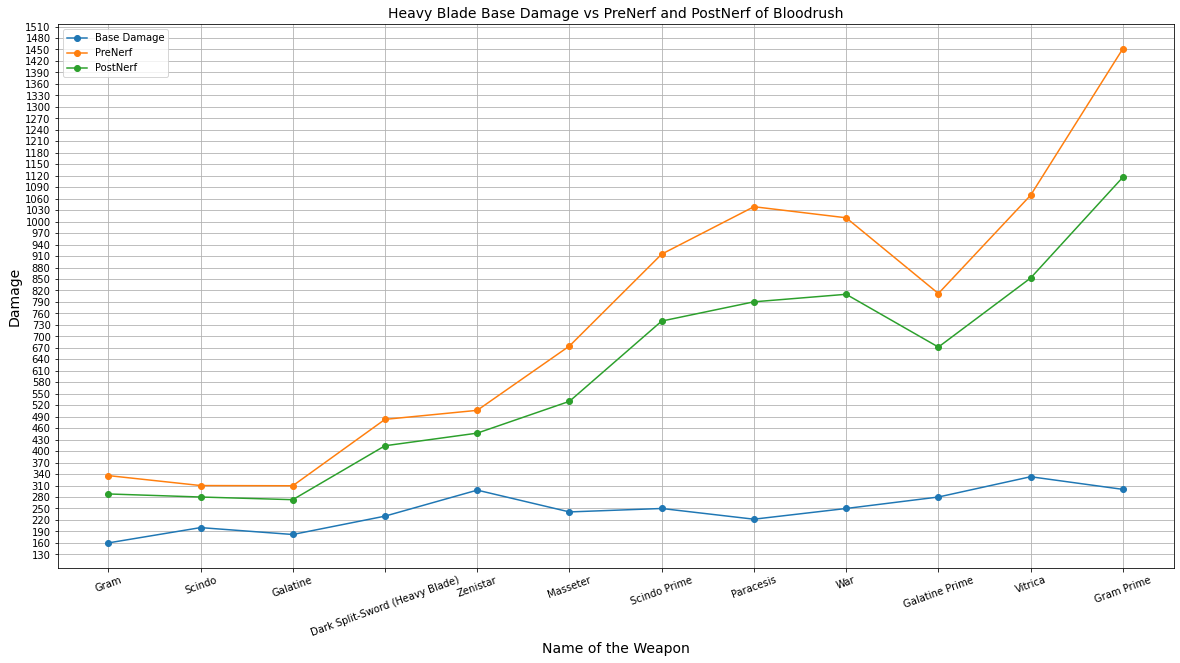

In [75]:
plt.figure(figsize=(20, 10))
plt.plot(HeavyBLDF['Name'], HeavyBLDF['Total_Damage'], label="Base Damage", marker='o')
plt.plot(HeavyBLDF['Name'], HeavyBLDF['PreNerfDamage'], label="PreNerf", marker='o')
plt.plot(HeavyBLDF['Name'], HeavyBLDF['PostNerfDamage'], label="PostNerf", marker='o')
plt.xticks(rotation = 20)
plt.yticks(np.arange(130, 1520, 30.0))
plt.title("Heavy Blade Base Damage vs PreNerf and PostNerf of Bloodrush", fontsize = 14)
plt.xlabel("Name of the Weapon", fontsize = 14)
plt.ylabel("Damage", fontsize = 14)
plt.legend()
plt.grid()
plt.show()

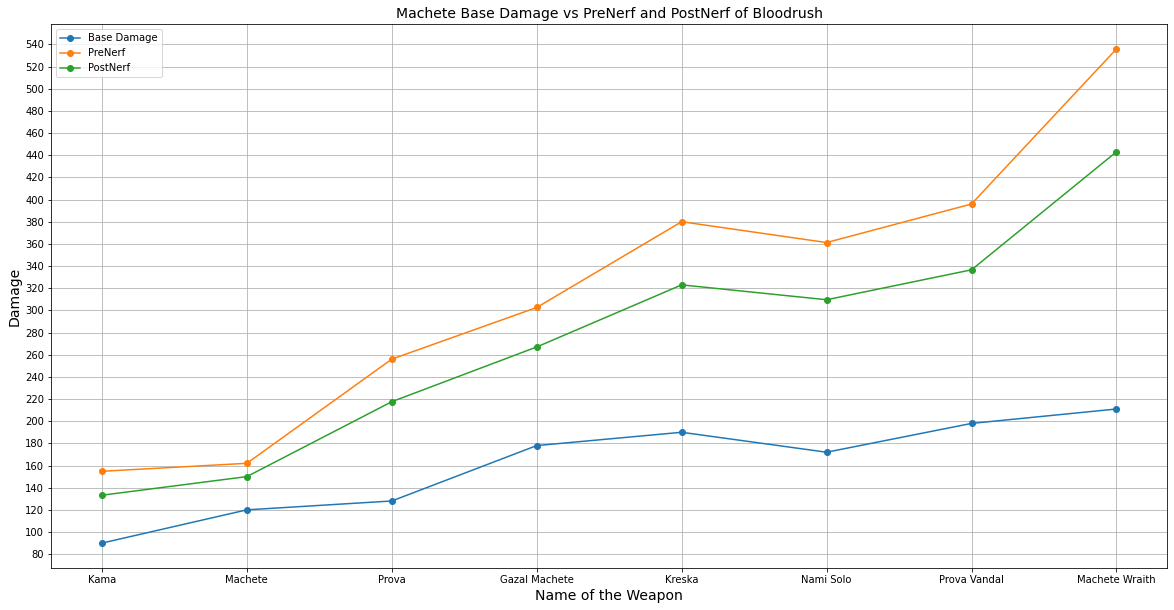

In [76]:
plt.figure(figsize=(20, 10))
plt.plot(MacheteDF['Name'], MacheteDF['Total_Damage'], label="Base Damage", marker='o')
plt.plot(MacheteDF['Name'], MacheteDF['PreNerfDamage'], label="PreNerf", marker='o')
plt.plot(MacheteDF['Name'], MacheteDF['PostNerfDamage'], label="PostNerf", marker='o')

plt.yticks(np.arange(80, 550, 20.0))
plt.title("Machete Base Damage vs PreNerf and PostNerf of Bloodrush", fontsize = 14)
plt.xlabel("Name of the Weapon", fontsize = 14)
plt.ylabel("Damage", fontsize = 14)
plt.legend()
plt.grid()
plt.show()

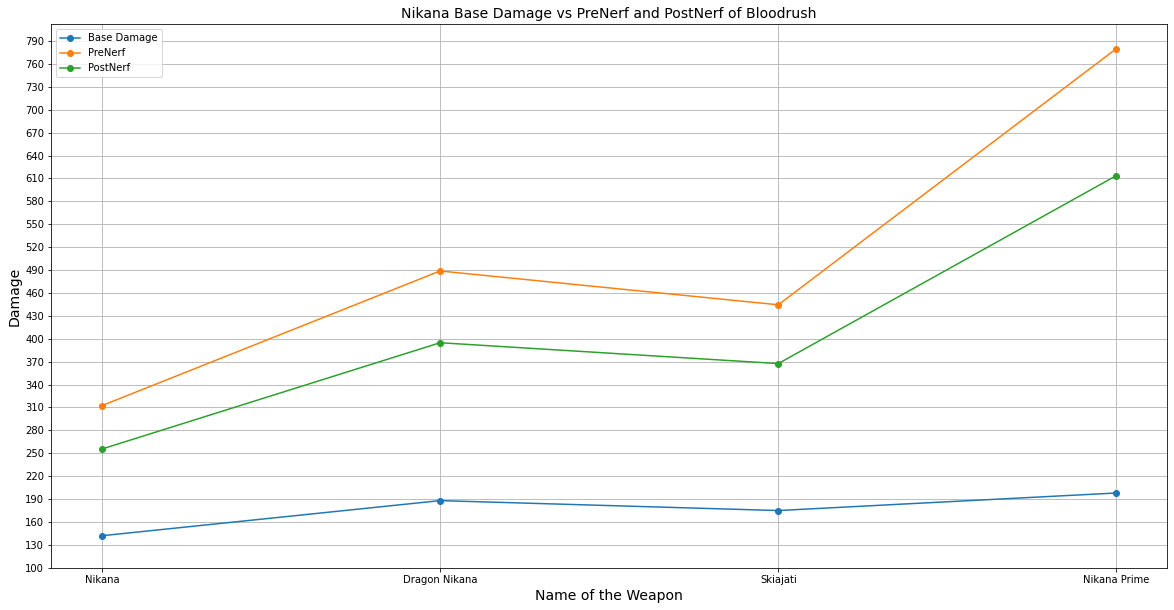

In [77]:
plt.figure(figsize=(20, 10))
plt.plot(NikanaDF['Name'], NikanaDF['Total_Damage'], label="Base Damage", marker='o')
plt.plot(NikanaDF['Name'], NikanaDF['PreNerfDamage'], label="PreNerf", marker='o')
plt.plot(NikanaDF['Name'], NikanaDF['PostNerfDamage'], label="PostNerf", marker='o')

plt.yticks(np.arange(100, 800, 30.0))
plt.title("Nikana Base Damage vs PreNerf and PostNerf of Bloodrush", fontsize = 14)
plt.xlabel("Name of the Weapon", fontsize = 14)
plt.ylabel("Damage", fontsize = 14)
plt.legend()
plt.grid()
plt.show()

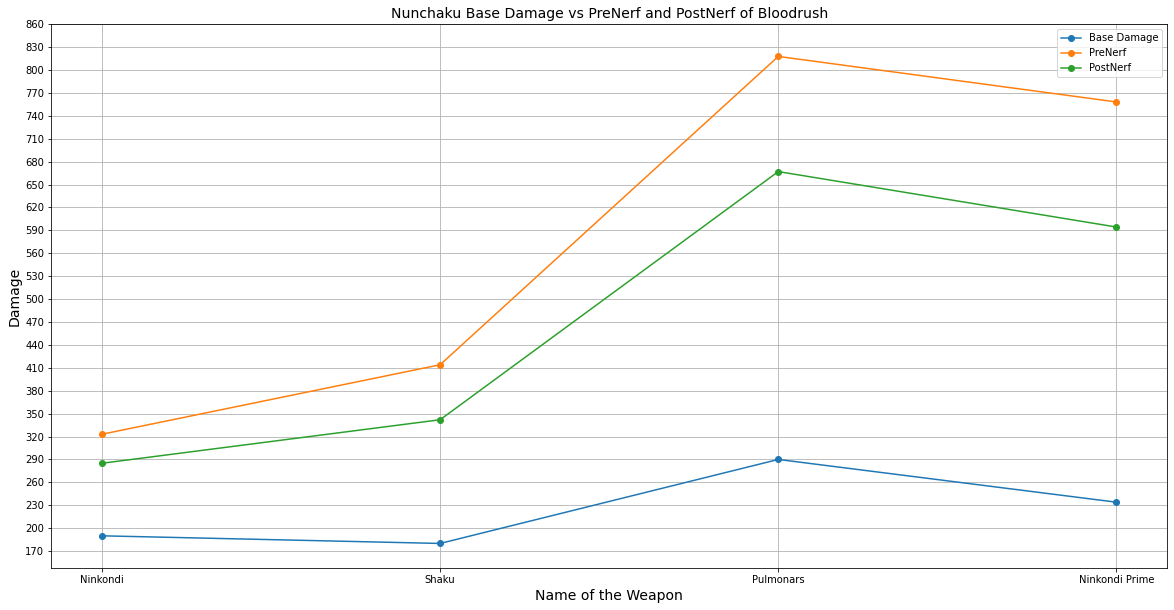

In [78]:
plt.figure(figsize=(20, 10))
plt.plot(NunchakuDF['Name'], NunchakuDF['Total_Damage'], label="Base Damage", marker='o')
plt.plot(NunchakuDF['Name'], NunchakuDF['PreNerfDamage'], label="PreNerf", marker='o')
plt.plot(NunchakuDF['Name'], NunchakuDF['PostNerfDamage'], label="PostNerf", marker='o')

plt.yticks(np.arange(170, 880, 30.0))
plt.title("Nunchaku Base Damage vs PreNerf and PostNerf of Bloodrush", fontsize = 14)
plt.xlabel("Name of the Weapon", fontsize = 14)
plt.ylabel("Damage", fontsize = 14)
plt.legend()
plt.grid()
plt.show()

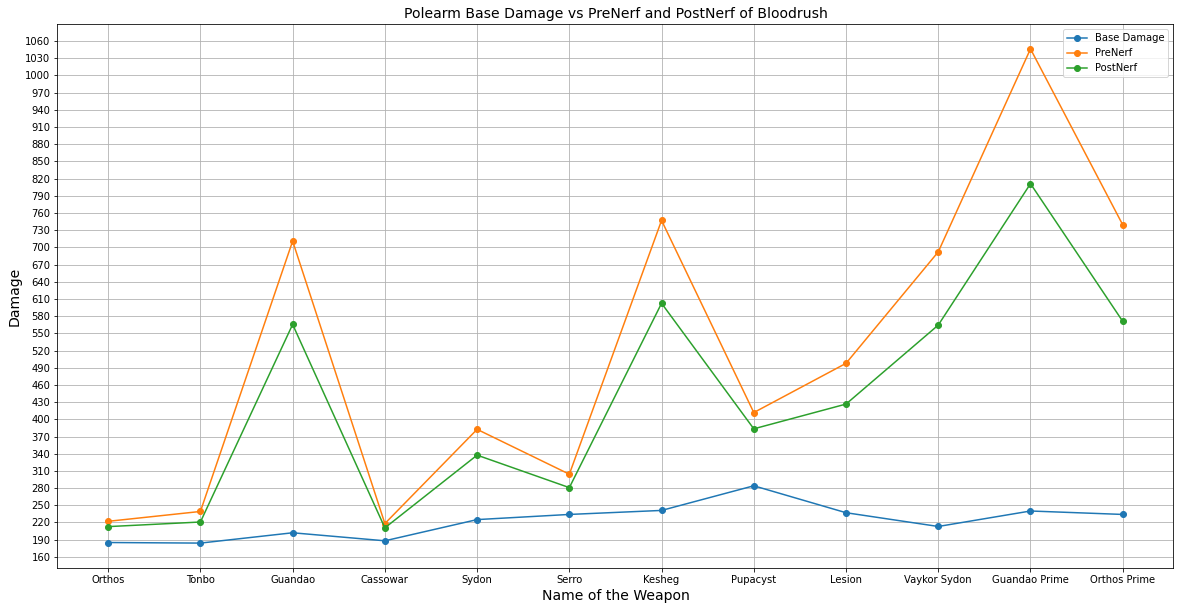

In [79]:
plt.figure(figsize=(20, 10))
plt.plot(PolearmDF['Name'], PolearmDF['Total_Damage'], label="Base Damage", marker='o')
plt.plot(PolearmDF['Name'], PolearmDF['PreNerfDamage'], label="PreNerf", marker='o')
plt.plot(PolearmDF['Name'], PolearmDF['PostNerfDamage'], label="PostNerf", marker='o')

plt.yticks(np.arange(160, 1090, 30.0))
plt.title("Polearm Base Damage vs PreNerf and PostNerf of Bloodrush", fontsize = 14)
plt.xlabel("Name of the Weapon", fontsize = 14)
plt.ylabel("Damage", fontsize = 14)
plt.legend()
plt.grid()
plt.show()

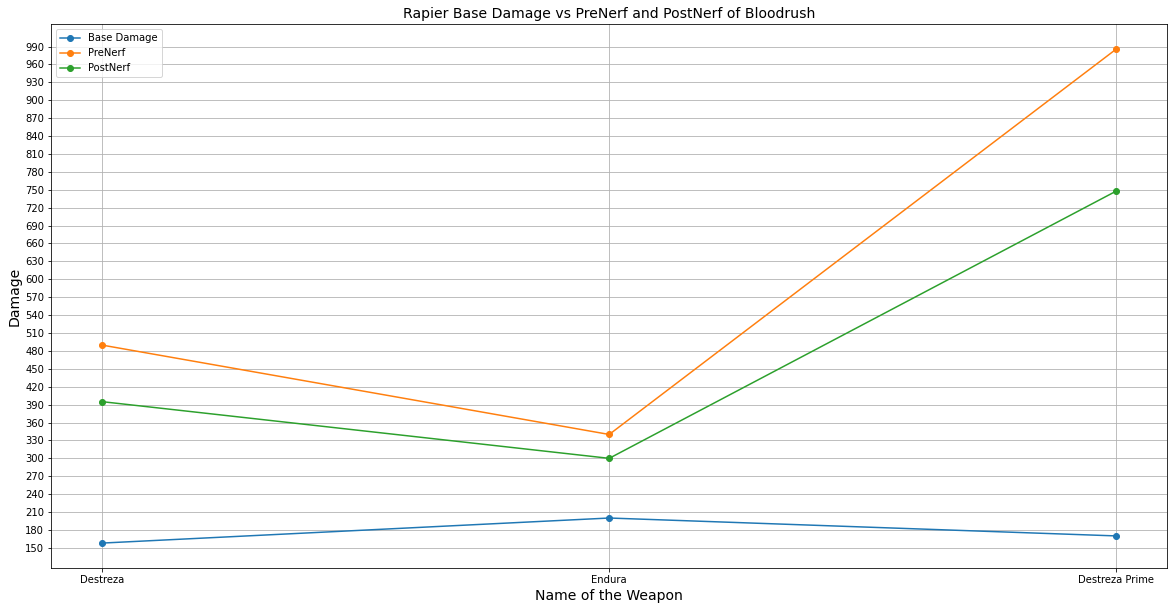

In [80]:
plt.figure(figsize=(20, 10))
plt.plot(RapierDF['Name'], RapierDF['Total_Damage'], label="Base Damage", marker='o')
plt.plot(RapierDF['Name'], RapierDF['PreNerfDamage'], label="PreNerf", marker='o')
plt.plot(RapierDF['Name'], RapierDF['PostNerfDamage'], label="PostNerf", marker='o')

plt.yticks(np.arange(150, 1000, 30.0))
plt.title("Rapier Base Damage vs PreNerf and PostNerf of Bloodrush", fontsize = 14)
plt.xlabel("Name of the Weapon", fontsize = 14)
plt.ylabel("Damage", fontsize = 14)
plt.legend()
plt.grid()
plt.show()

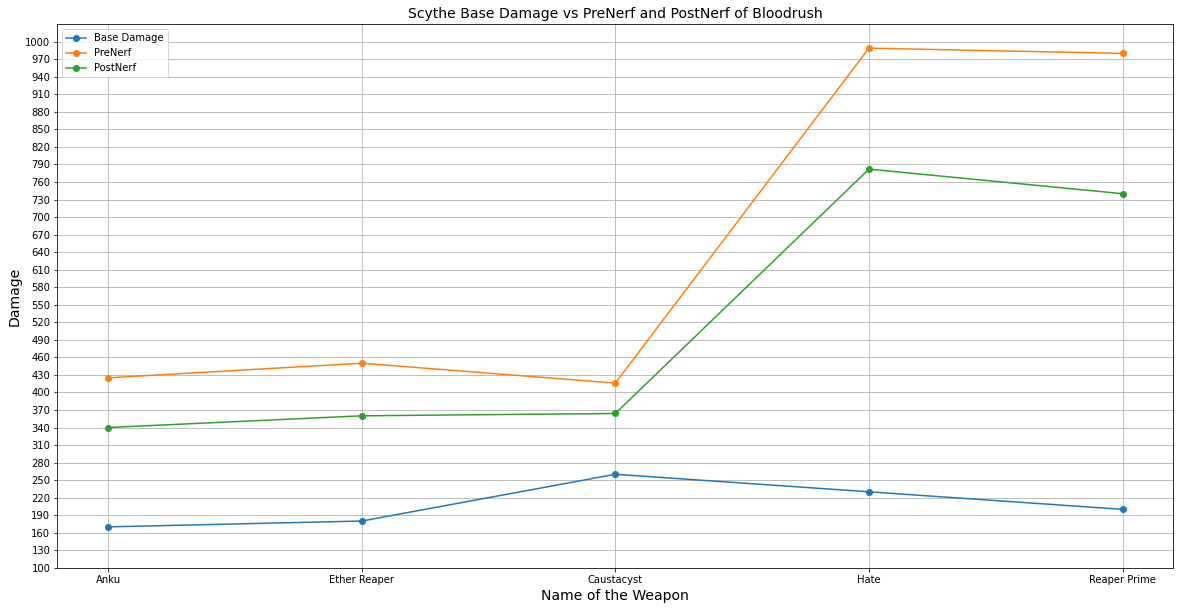

In [81]:
plt.figure(figsize=(20, 10))
plt.plot(ScytheDF['Name'], ScytheDF['Total_Damage'], label="Base Damage", marker='o')
plt.plot(ScytheDF['Name'], ScytheDF['PreNerfDamage'], label="PreNerf", marker='o')
plt.plot(ScytheDF['Name'], ScytheDF['PostNerfDamage'], label="PostNerf", marker='o')

plt.yticks(np.arange(100, 1010, 30.0))
plt.title("Scythe Base Damage vs PreNerf and PostNerf of Bloodrush", fontsize = 14)
plt.xlabel("Name of the Weapon", fontsize = 14)
plt.ylabel("Damage", fontsize = 14)
plt.legend()
plt.grid()
plt.show()

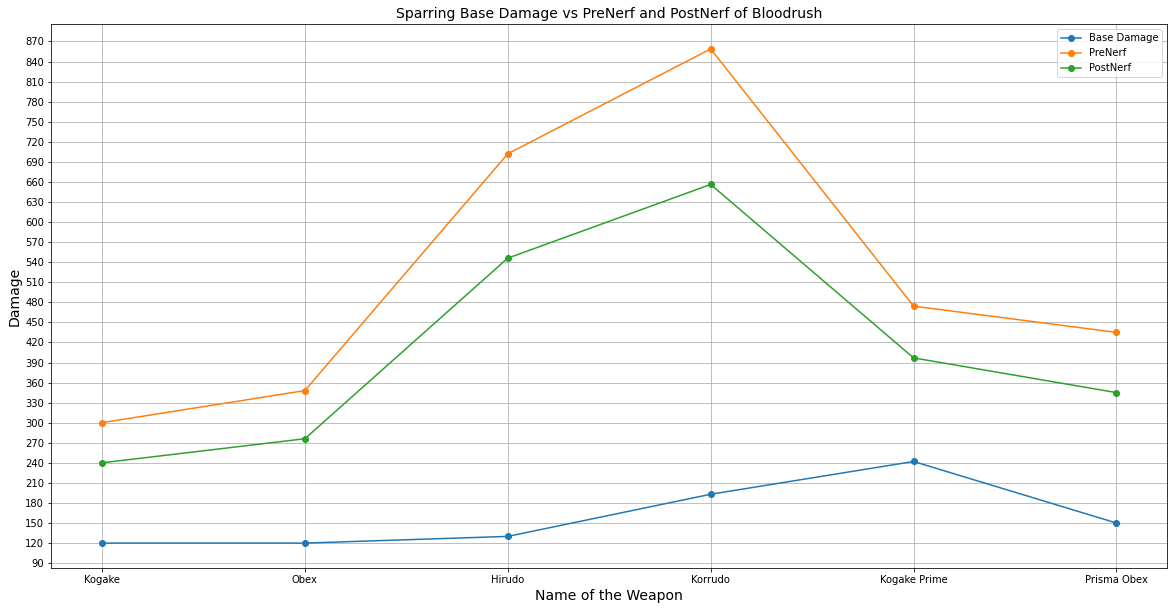

In [82]:
plt.figure(figsize=(20, 10))
plt.plot(SparringDF['Name'], SparringDF['Total_Damage'], label="Base Damage", marker='o')
plt.plot(SparringDF['Name'], SparringDF['PreNerfDamage'], label="PreNerf", marker='o')
plt.plot(SparringDF['Name'], SparringDF['PostNerfDamage'], label="PostNerf", marker='o')

plt.yticks(np.arange(90, 890, 30.0))
plt.title("Sparring Base Damage vs PreNerf and PostNerf of Bloodrush", fontsize = 14)
plt.xlabel("Name of the Weapon", fontsize = 14)
plt.ylabel("Damage", fontsize = 14)
plt.legend()
plt.grid()
plt.show()

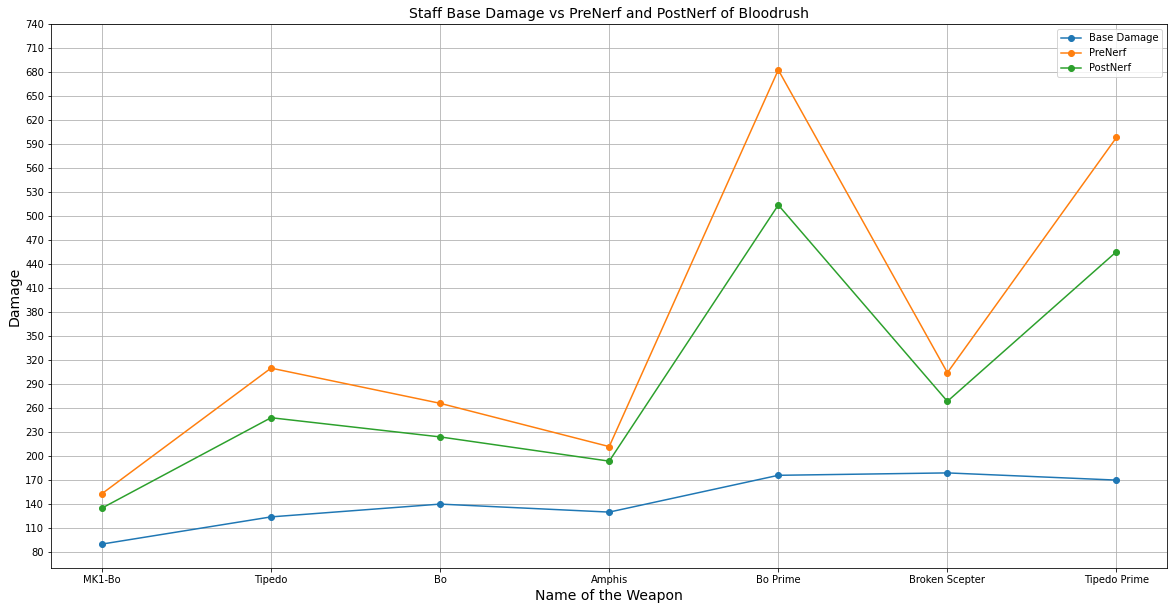

In [83]:
plt.figure(figsize=(20, 10))
plt.plot(StaffDF['Name'], StaffDF['Total_Damage'], label="Base Damage", marker='o')
plt.plot(StaffDF['Name'], StaffDF['PreNerfDamage'], label="PreNerf", marker='o')
plt.plot(StaffDF['Name'], StaffDF['PostNerfDamage'], label="PostNerf", marker='o')

plt.yticks(np.arange(80, 760, 30.0))
plt.title("Staff Base Damage vs PreNerf and PostNerf of Bloodrush", fontsize = 14)
plt.xlabel("Name of the Weapon", fontsize = 14)
plt.ylabel("Damage", fontsize = 14)
plt.legend()
plt.grid()
plt.show()

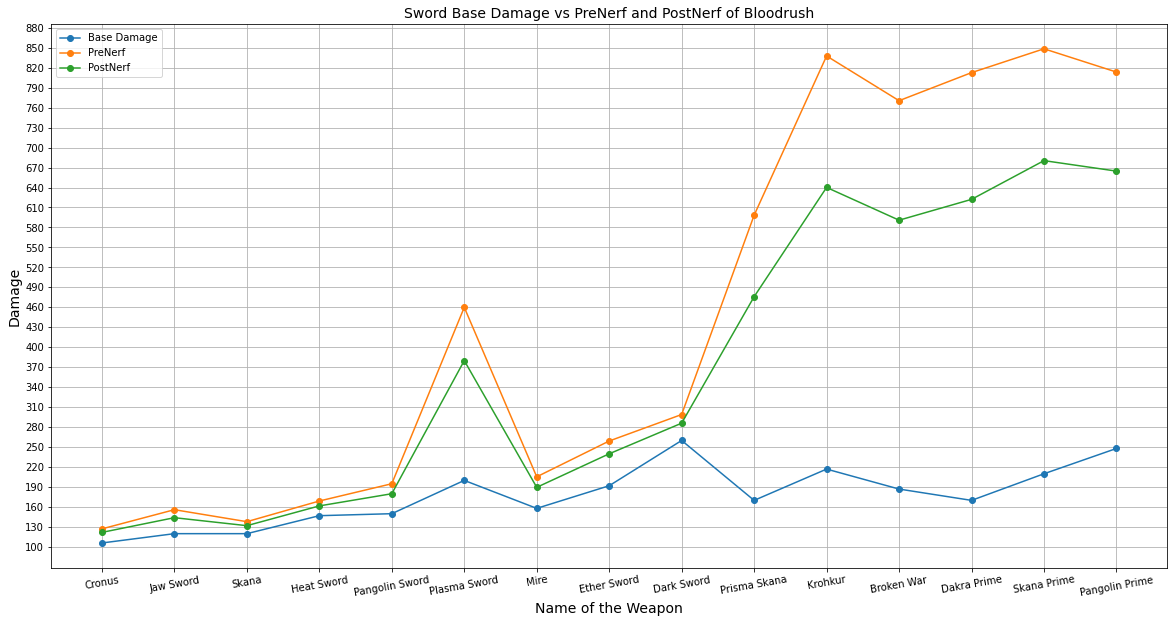

In [84]:
plt.figure(figsize=(20, 10))
plt.plot(SwordDF['Name'], SwordDF['Total_Damage'], label="Base Damage", marker='o')
plt.plot(SwordDF['Name'], SwordDF['PreNerfDamage'], label="PreNerf", marker='o')
plt.plot(SwordDF['Name'], SwordDF['PostNerfDamage'], label="PostNerf", marker='o')
plt.xticks(rotation=10)
plt.yticks(np.arange(100, 890, 30.0))
plt.title("Sword Base Damage vs PreNerf and PostNerf of Bloodrush", fontsize = 14)
plt.xlabel("Name of the Weapon", fontsize = 14)
plt.ylabel("Damage", fontsize = 14)
plt.legend()
plt.grid()
plt.show()

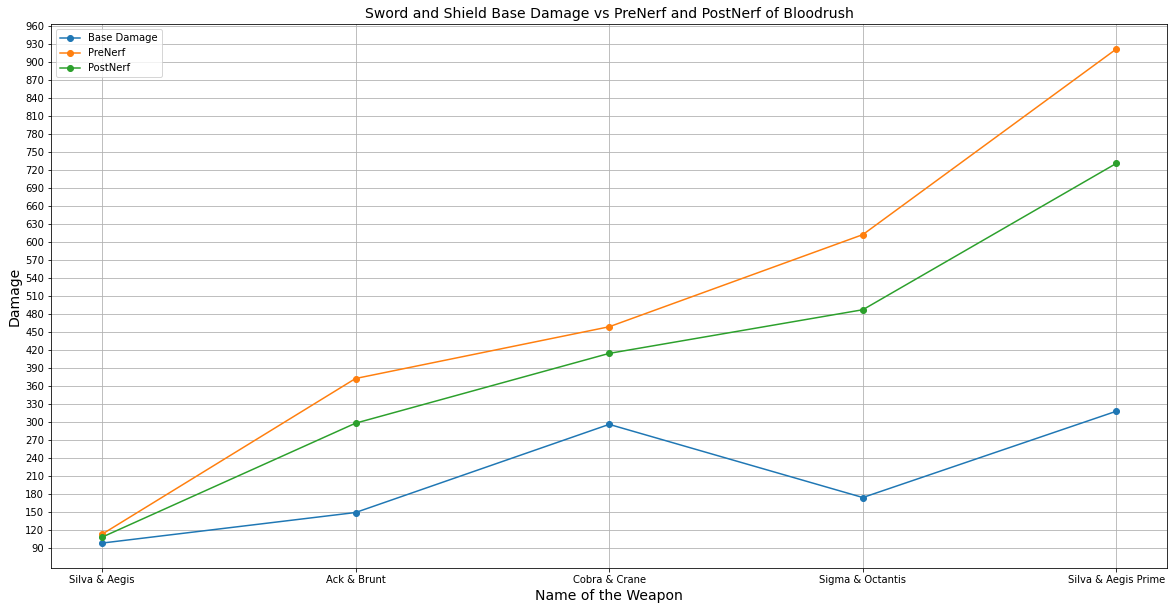

In [85]:
plt.figure(figsize=(20, 10))
plt.plot(SWSHDF['Name'], SWSHDF['Total_Damage'], label="Base Damage", marker='o')
plt.plot(SWSHDF['Name'], SWSHDF['PreNerfDamage'], label="PreNerf", marker='o')
plt.plot(SWSHDF['Name'], SWSHDF['PostNerfDamage'], label="PostNerf", marker='o')

plt.yticks(np.arange(90, 990, 30.0))
plt.title("Sword and Shield Base Damage vs PreNerf and PostNerf of Bloodrush", fontsize = 14)
plt.xlabel("Name of the Weapon", fontsize = 14)
plt.ylabel("Damage", fontsize = 14)
plt.legend()
plt.grid()
plt.show()

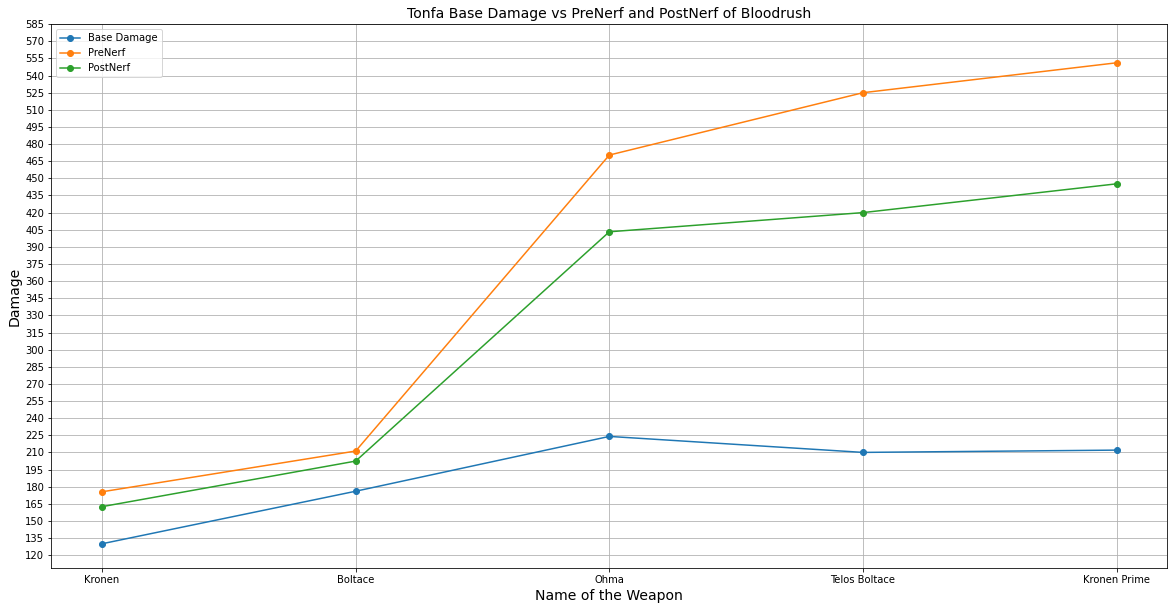

In [86]:
plt.figure(figsize=(20, 10))
plt.plot(TonfaDF['Name'], TonfaDF['Total_Damage'], label="Base Damage", marker='o')
plt.plot(TonfaDF['Name'], TonfaDF['PreNerfDamage'], label="PreNerf", marker='o')
plt.plot(TonfaDF['Name'], TonfaDF['PostNerfDamage'], label="PostNerf", marker='o')

plt.yticks(np.arange(120, 600, 15.0))
plt.title("Tonfa Base Damage vs PreNerf and PostNerf of Bloodrush", fontsize = 14)
plt.xlabel("Name of the Weapon", fontsize = 14)
plt.ylabel("Damage", fontsize = 14)
plt.legend()
plt.grid()
plt.show()

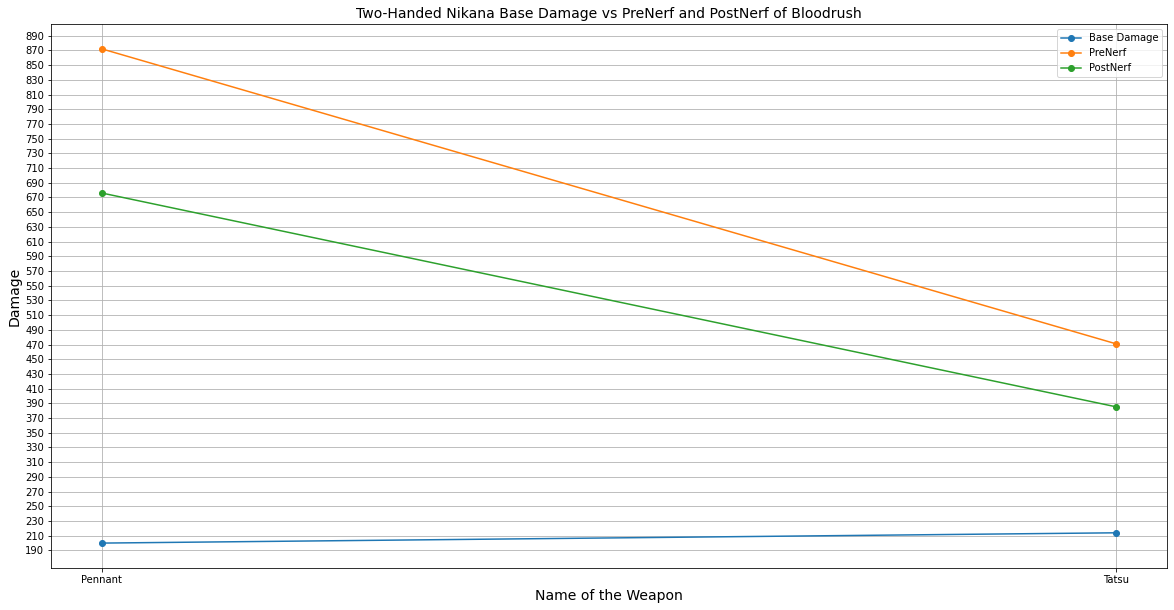

In [87]:
plt.figure(figsize=(20, 10))
plt.plot(HeavyNikDF['Name'], HeavyNikDF['Total_Damage'], label="Base Damage", marker='o')
plt.plot(HeavyNikDF['Name'], HeavyNikDF['PreNerfDamage'], label="PreNerf", marker='o')
plt.plot(HeavyNikDF['Name'], HeavyNikDF['PostNerfDamage'], label="PostNerf", marker='o')

plt.yticks(np.arange(190, 900, 20.0))
plt.title("Two-Handed Nikana Base Damage vs PreNerf and PostNerf of Bloodrush", fontsize = 14)
plt.xlabel("Name of the Weapon", fontsize = 14)
plt.ylabel("Damage", fontsize = 14)
plt.legend()
plt.grid()
plt.show()

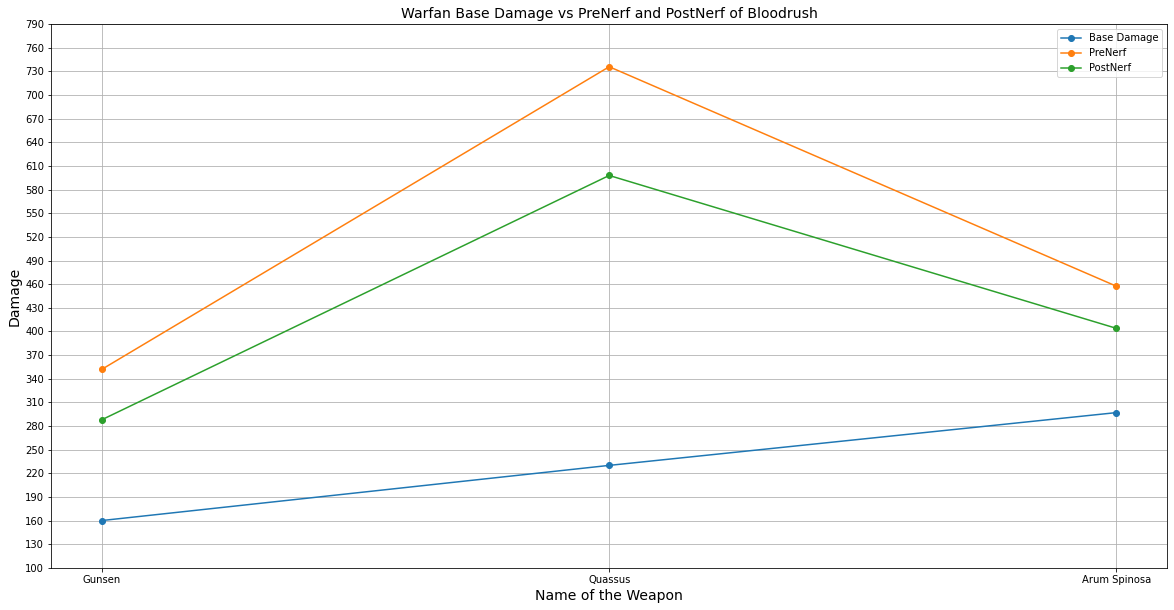

In [88]:
plt.figure(figsize=(20, 10))
plt.plot(FanDF['Name'], FanDF['Total_Damage'], label="Base Damage", marker='o')
plt.plot(FanDF['Name'], FanDF['PreNerfDamage'], label="PreNerf", marker='o')
plt.plot(FanDF['Name'], FanDF['PostNerfDamage'], label="PostNerf", marker='o')

plt.yticks(np.arange(100, 800, 30.0))
plt.title("Warfan Base Damage vs PreNerf and PostNerf of Bloodrush", fontsize = 14)
plt.xlabel("Name of the Weapon", fontsize = 14)
plt.ylabel("Damage", fontsize = 14)
plt.legend()
plt.grid()
plt.show()

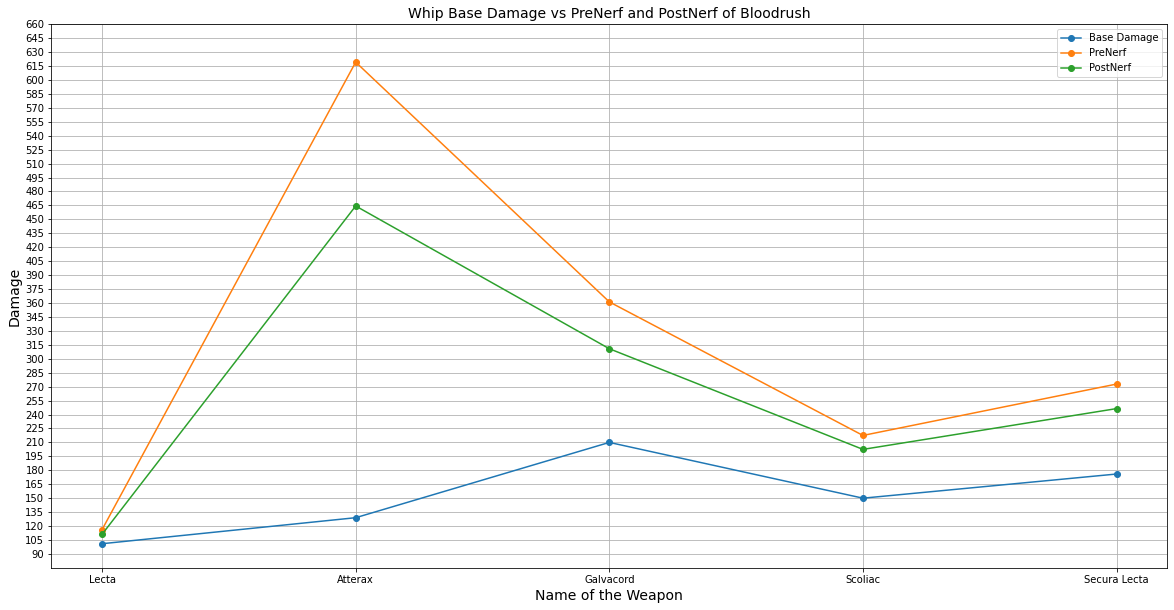

In [89]:
plt.figure(figsize=(20, 10))
plt.plot(WhipDF['Name'], WhipDF['Total_Damage'], label="Base Damage", marker='o')
plt.plot(WhipDF['Name'], WhipDF['PreNerfDamage'], label="PreNerf", marker='o')
plt.plot(WhipDF['Name'], WhipDF['PostNerfDamage'], label="PostNerf", marker='o')

plt.yticks(np.arange(90, 670, 15.0))
plt.title("Whip Base Damage vs PreNerf and PostNerf of Bloodrush", fontsize = 14)
plt.xlabel("Name of the Weapon", fontsize = 14)
plt.ylabel("Damage", fontsize = 14)
plt.legend()
plt.grid()
plt.show()